# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data and Basic Summary

In [4]:
import tensorflow as tf
from traffic.traffic_test_data_provider import TrafficDataRealFileProviderAutoSplitValidationData
from traffic.traffic_lenet import Lenet
from traffic.traffic_data import TrafficDataSets
from traffic.data_explorer import SignNames
from traffic.data_explorer import DataExplorer
from traffic.traffic_data_enhance import *
from IPython.display import Image
from traffic.traffic_lenet_v2 import LenetV2
from traffic.traffic_lenet_v3 import LenetV3
from traffic.traffic_lenet_v4 import LenetV4
from traffic.traffic_lenet_v5 import LenetV5
from traffic.traffic_lenet_v6 import LenetV6Deep24x96
from traffic.traffic_lenet_v7 import LenetV7LessMaxPooling
from traffic.traffic_lenet_v8_108x200 import LenetV8Deep108x200
from traffic.traffic_net_inception import NetInception

%matplotlib inline

print("tensorflow", tf.__version__)

sign_names = SignNames("signnames.csv")
original_data_provider = TrafficDataRealFileProviderAutoSplitValidationData(
            split_validation_from_train=True, validation_size=0.20)
original_data_explorer = DataExplorer.from_data_provider(sign_names, original_data_provider)

print("orignal data loaded")
print("Original Data Summary")
print(original_data_explorer.summary())

tensorflow 0.12.0-rc1
orignal data loaded
Original Data Summary

        training data set: 
            examples:31367
            shape:(31367, 32, 32, 3)
        
        validation data set: 
            examples:7842
            shape:(7842, 32, 32, 3)
        
        testing data set: 
            examples:12630
            shape:(12630, 32, 32, 3)
        
        unique classes: 43
        


In [5]:

def augment_data_random_rotate(ratio, provider=original_data_provider):
    images, labels = enhance_with_random_rotate(provider.X_train, provider.y_train, ratio)
    provider = provider.to_other_provider(X_train_overwrite=images, y_train_overwrite=labels)
    return provider

rotated_data_provider = augment_data_random_rotate(1)
rotated_data_explorer = DataExplorer.from_data_provider(sign_names, rotated_data_provider)

print("random roated data loaded")
print("Augmented Data Summary - Random Rotate")
print(rotated_data_explorer.summary())

generating class:0 with ratio:10, max input:1800, current:172
generating class:1 with ratio:1, max input:1800, current:1724
generating class:2 with ratio:0, max input:1800, current:1800
generating class:3 with ratio:1, max input:1800, current:1130
generating class:4 with ratio:1, max input:1800, current:1562
generating class:5 with ratio:1, max input:1800, current:1496
generating class:6 with ratio:4, max input:1800, current:361
generating class:7 with ratio:1, max input:1800, current:1162
generating class:8 with ratio:1, max input:1800, current:1109
generating class:9 with ratio:1, max input:1800, current:1202
generating class:10 with ratio:1, max input:1800, current:1640
generating class:11 with ratio:1, max input:1800, current:1084
generating class:12 with ratio:1, max input:1800, current:1650
generating class:13 with ratio:1, max input:1800, current:1708
generating class:14 with ratio:2, max input:1800, current:618
generating class:15 with ratio:3, max input:1800, current:510
gener

---

## Step 1: Dataset Summary & Exploration


In [3]:
def data_distribution(explorer):
    distribution = explorer.training_data_distribution()
    highest = explorer.highest_sign_names_count(distribution)
    distribution = explorer.training_data_distribution()
    lowest = explorer.lowest_sign_names_count(distribution)
    print("highest count of sign names:", highest)
    print("lowest count of sign names:", lowest)
    
    explorer.bar_chart_data_distribution(explorer.training_data_distribution(),
                                         "Training Data Distribution").show()
    explorer.bar_chart_data_distribution(explorer.validation_data_distribution(),
                                         "Validation Data Distribution").show()
    explorer.bar_chart_data_distribution(explorer.testing_data_distribution(),
                                         "Testing Data Distribution").show()



### Original Dataset Distribution


highest count of sign names: ('Speed limit (50km/h)', 1800)
lowest count of sign names: ('Go straight or left', 163)


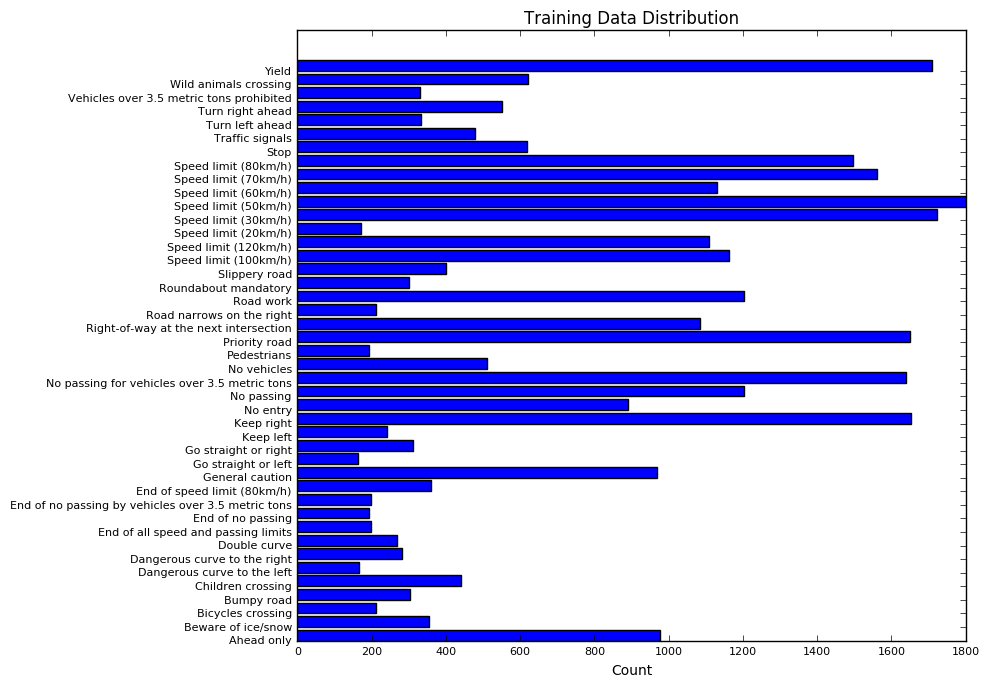

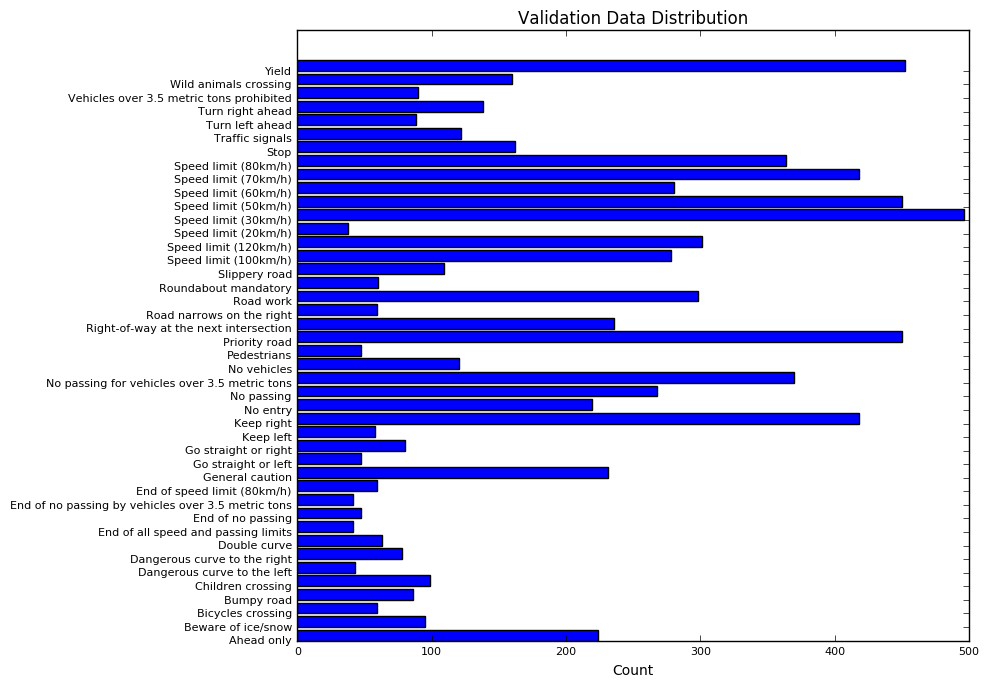

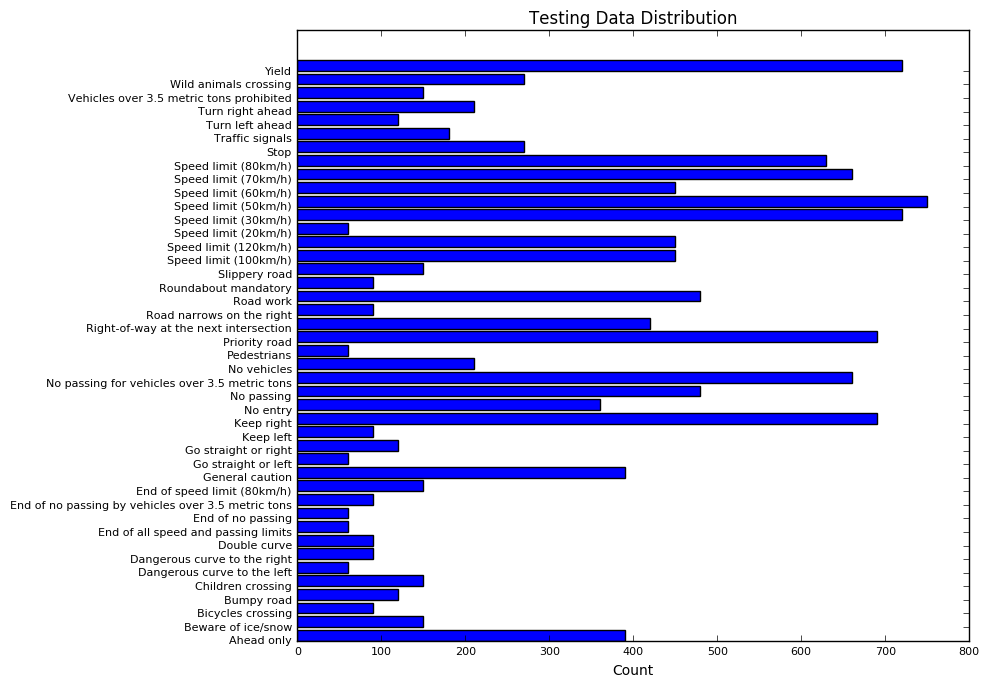

In [4]:
data_distribution(original_data_explorer)

### Random Rotated Dataset Distribution


highest count of sign names: ('No entry', 2673)
lowest count of sign names: ('General caution', 969)


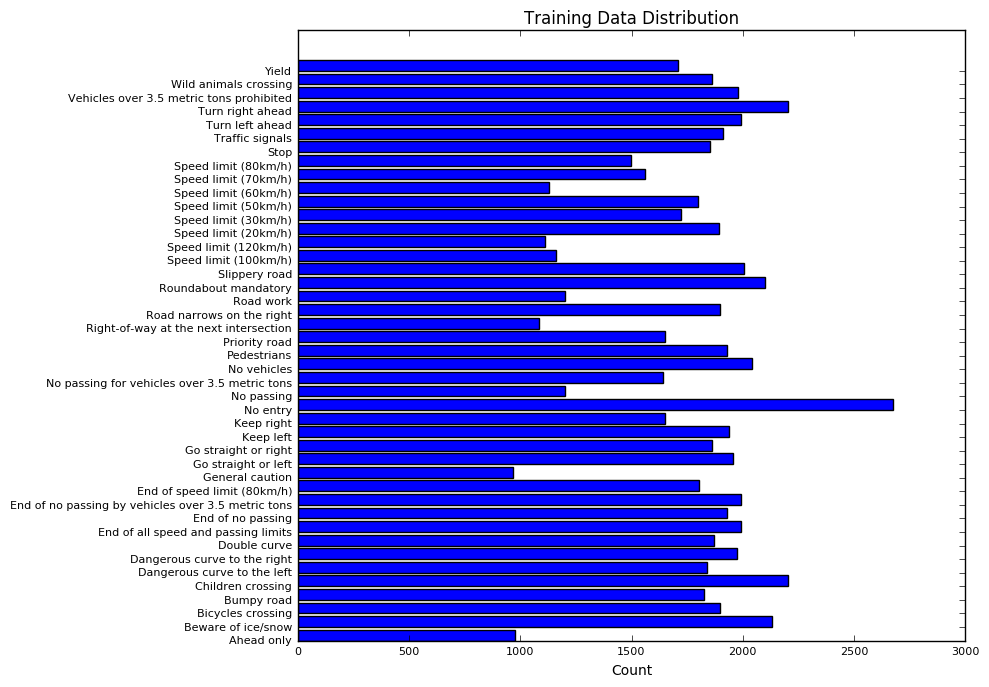

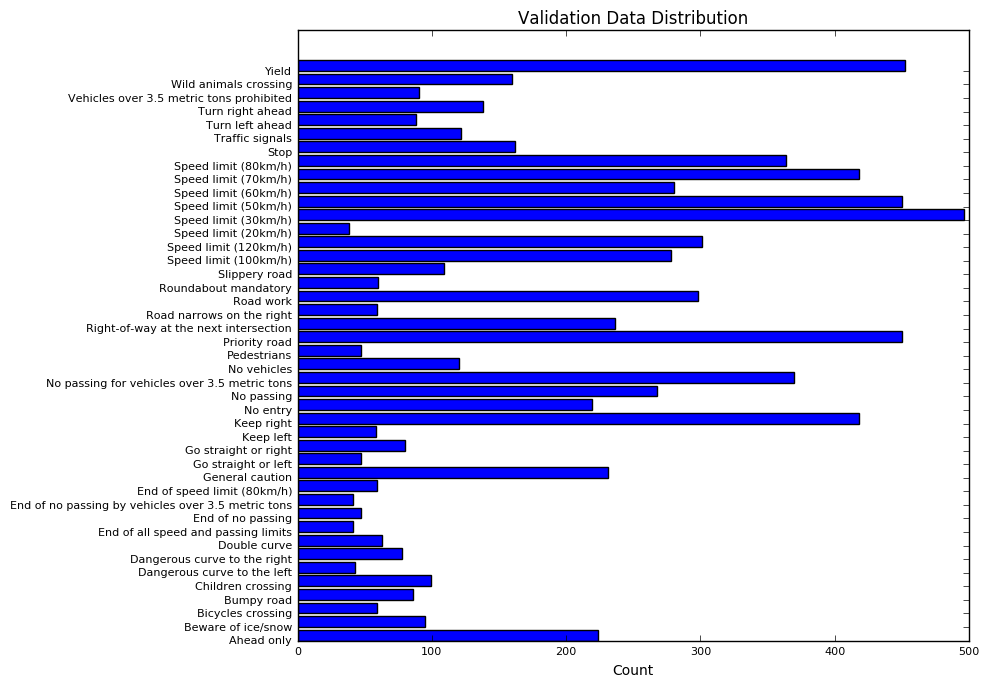

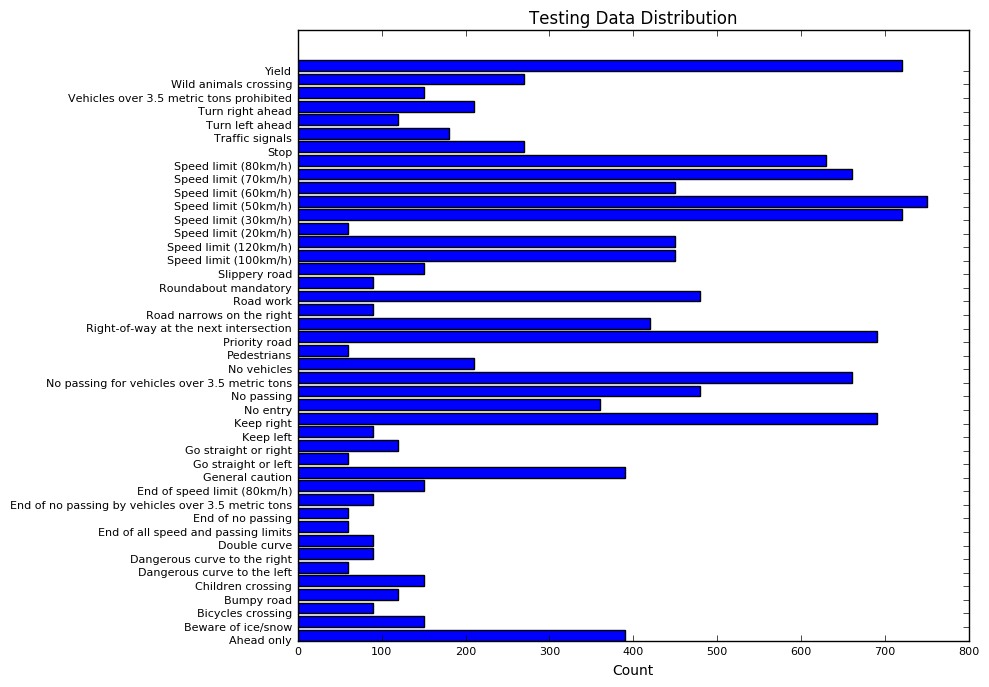

In [14]:
data_distribution_original_data(rotated_data_explorer)

### Sample Images

with DataExplorer class, you can sample all data with a slice

training data set samples


showing image : 100%|██████████| 10/10 [00:00<00:00, 986.25it/s]


validation data set samples


showing image : 100%|██████████| 10/10 [00:00<00:00, 1037.14it/s]


testing data set samples


showing image : 100%|██████████| 30/30 [00:00<00:00, 1057.18it/s]


<function matplotlib.pyplot.show>

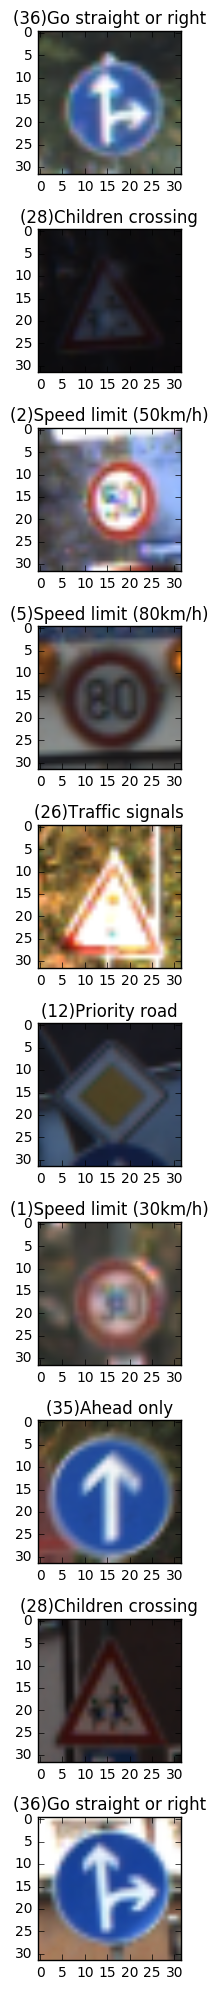

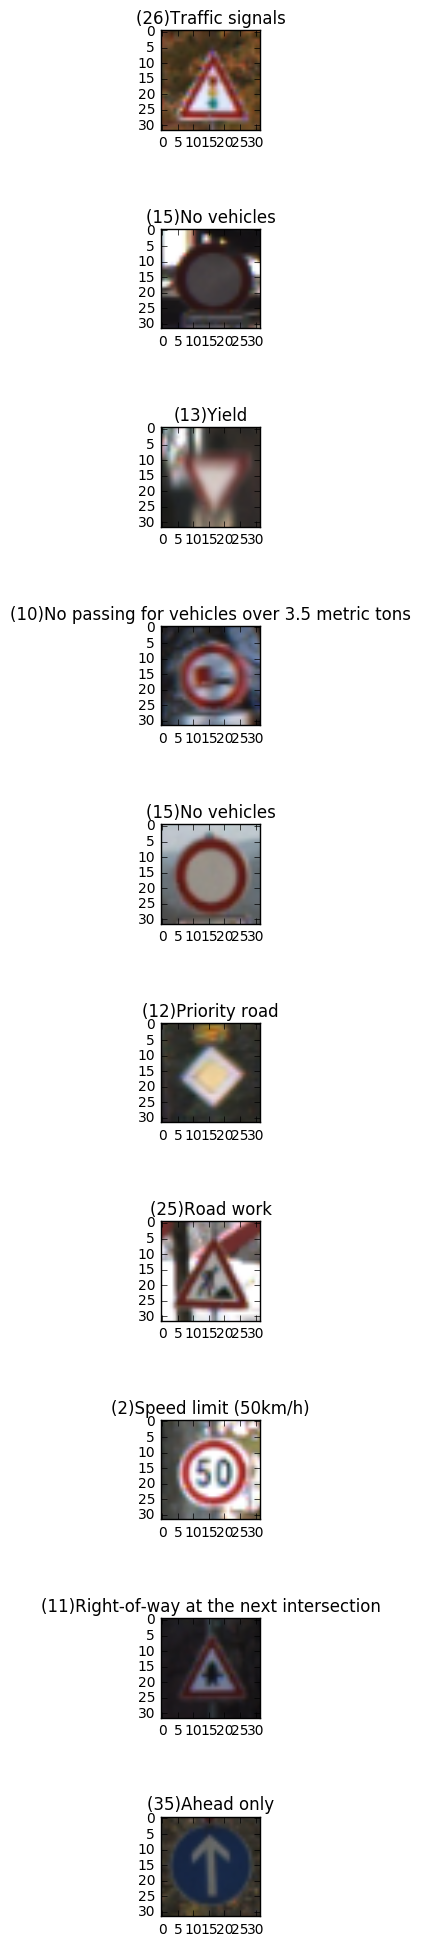

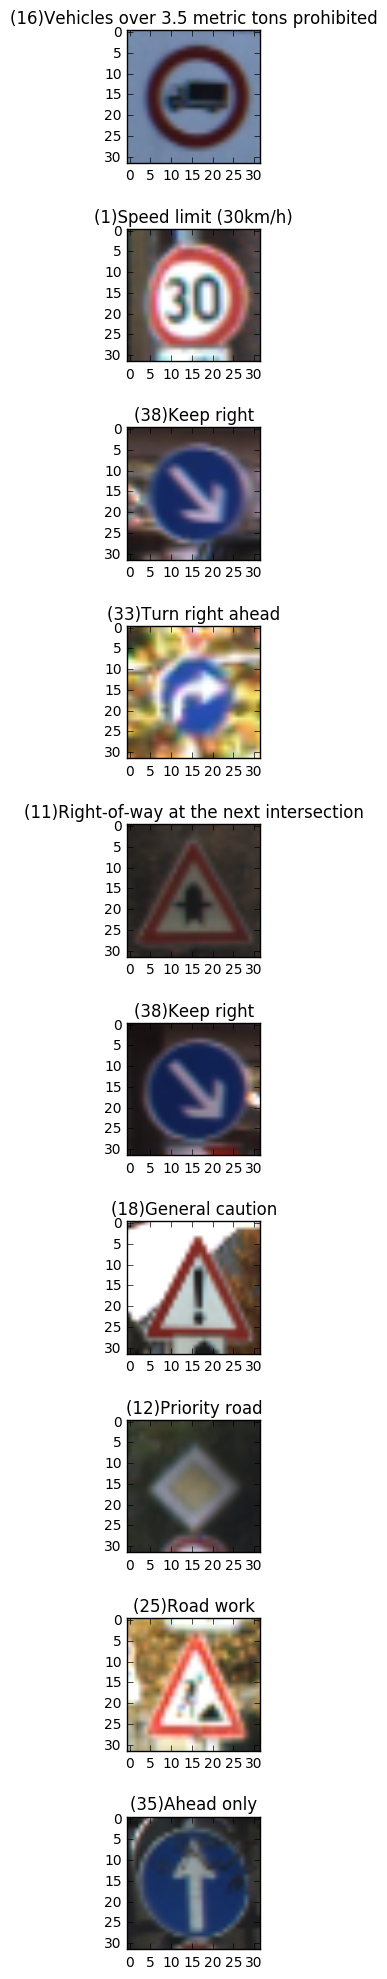

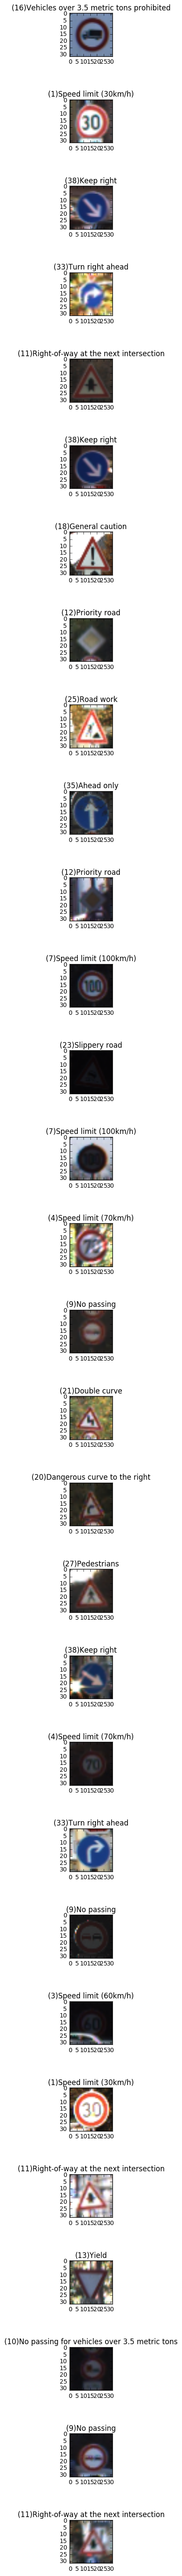

In [5]:
print("training data set samples")
original_data_explorer.sample_training_data(slice(0, 10)).show
print("validation data set samples")
original_data_explorer.sample_validation_data(slice(0, 10)).show
print("testing data set samples")
original_data_explorer.sample_testing_data(slice(0, 10)).show

rotated_data_explorer.sample_testing_data(slice(0, 30)).show
        

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In [ ]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

2017-01-08 11:46:35,101 - training data 31367
2017-01-08 11:46:38,175 - EPOCH 1 training loss = 5.427 accuracy = 0.146 Validation loss = 2.199 accuracy = 0.431
2017-01-08 11:46:41,331 - EPOCH 2 training loss = 2.112 accuracy = 0.405 Validation loss = 1.289 accuracy = 0.622
2017-01-08 11:46:44,379 - EPOCH 3 training loss = 1.490 accuracy = 0.549 Validation loss = 0.845 accuracy = 0.755
2017-01-08 11:46:47,303 - EPOCH 4 training loss = 1.127 accuracy = 0.647 Validation loss = 0.645 accuracy = 0.803
2017-01-08 11:46:50,245 - EPOCH 5 training loss = 0.873 accuracy = 0.722 Validation loss = 0.485 accuracy = 0.851
2017-01-08 11:46:53,202 - EPOCH 6 training loss = 0.734 accuracy = 0.770 Validation loss = 0.405 accuracy = 0.876
2017-01-08 11:46:56,128 - EPOCH 7 training loss = 0.614 accuracy = 0.804 Validation loss = 0.342 accuracy = 0.894
2017-01-08 11:46:59,166 - EPOCH 8 training loss = 0.520 accuracy = 0.836 Validation loss = 0.266 accuracy = 0.921
2017-01-08 11:47:02,212 - EPOCH 9 training

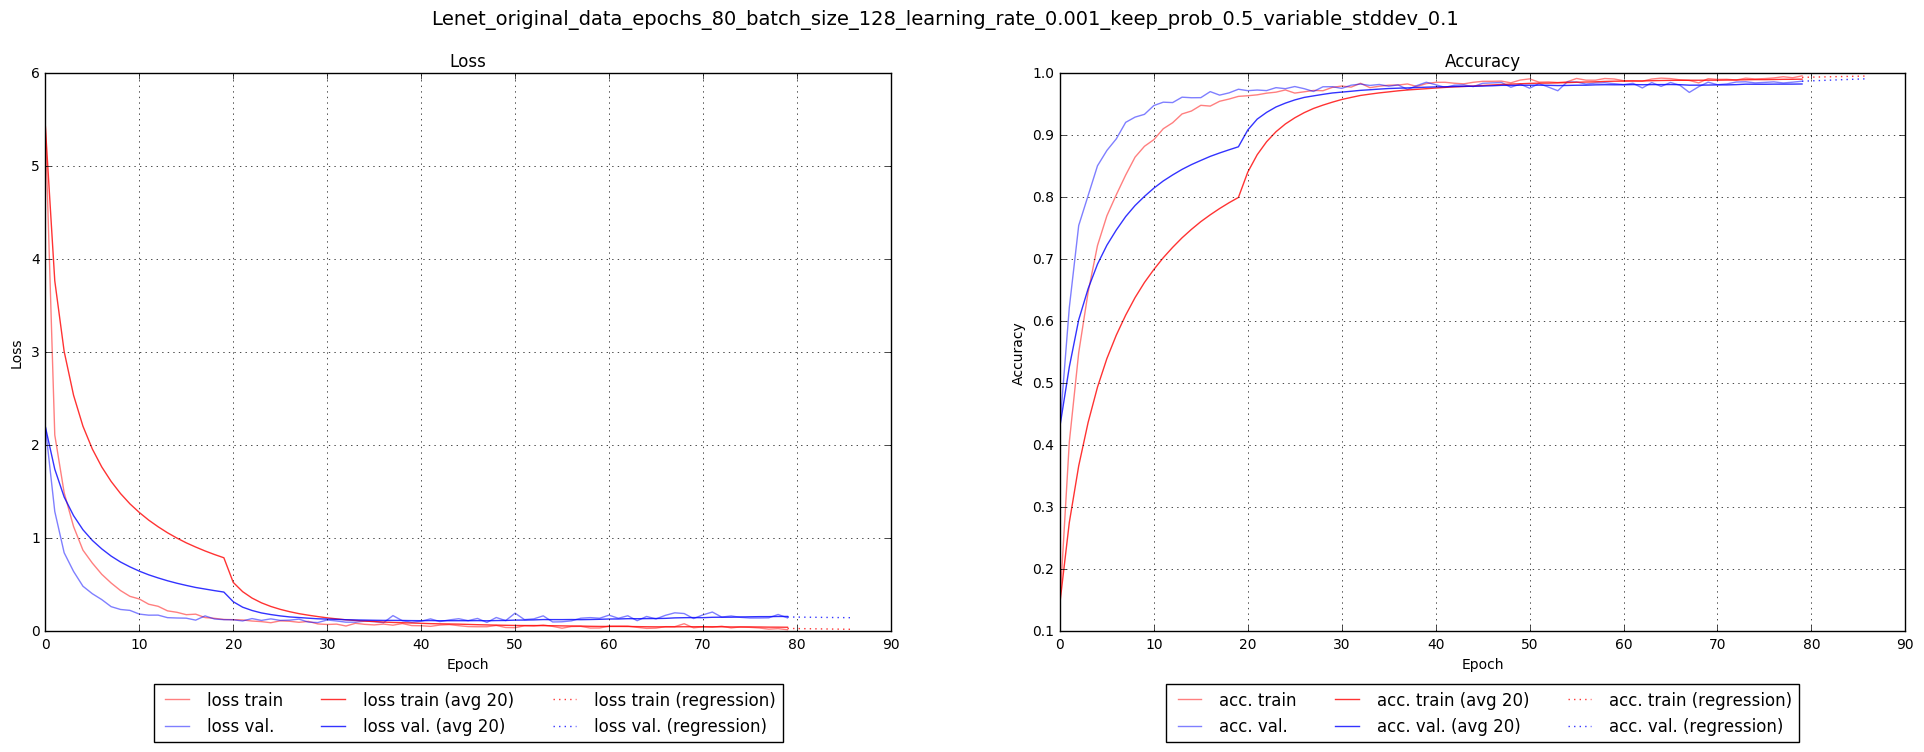

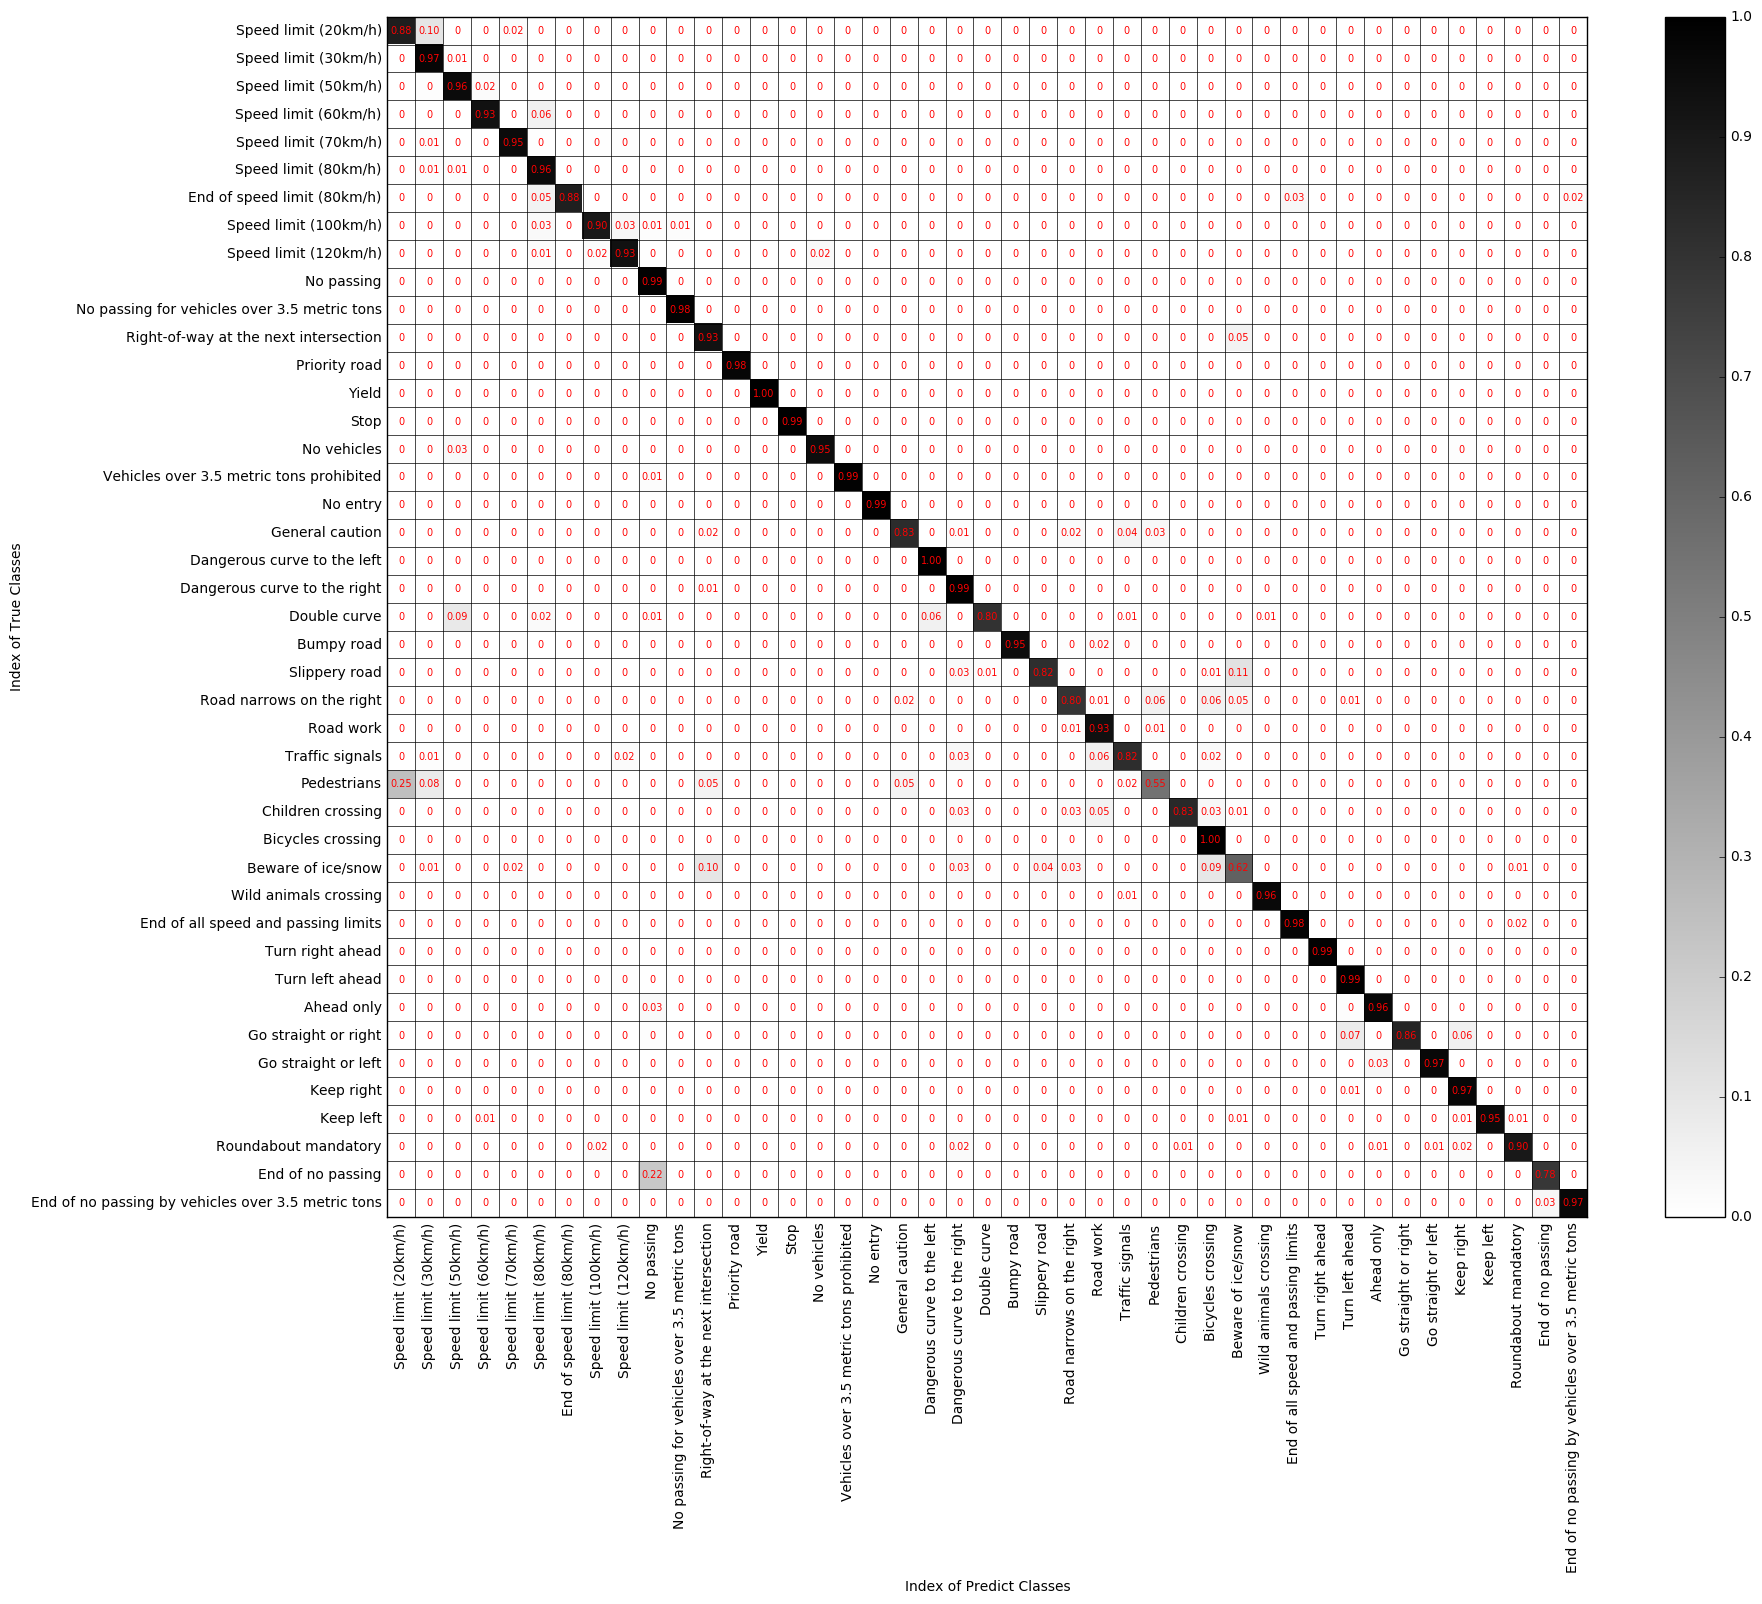

In [2]:
def test_basic_lenet_original_data():
    """
    0.941
    """
    provider = original_data_provider
    lenet = Lenet(TrafficDataSets(provider),
                  name="original_data",
                  epochs=80, batch_size=128, variable_mean=0, variable_stddev=0.1,
                  learning_rate=0.001,
                  drop_out_keep_prob=0.5)
    lenet.train()
    Image(filename=lenet.file_name) 
    
test_basic_lenet_original_data()

2017-01-08 12:02:11,563 - training data 31367
2017-01-08 12:02:14,867 - EPOCH 1 training loss = 1.890 accuracy = 0.478 Validation loss = 0.499 accuracy = 0.864
2017-01-08 12:02:18,168 - EPOCH 2 training loss = 0.564 accuracy = 0.826 Validation loss = 0.241 accuracy = 0.929
2017-01-08 12:02:21,291 - EPOCH 3 training loss = 0.340 accuracy = 0.896 Validation loss = 0.147 accuracy = 0.959
2017-01-08 12:02:24,521 - EPOCH 4 training loss = 0.241 accuracy = 0.927 Validation loss = 0.107 accuracy = 0.973
2017-01-08 12:02:27,699 - EPOCH 5 training loss = 0.181 accuracy = 0.945 Validation loss = 0.087 accuracy = 0.978
2017-01-08 12:02:30,808 - EPOCH 6 training loss = 0.152 accuracy = 0.954 Validation loss = 0.085 accuracy = 0.978
2017-01-08 12:02:33,917 - EPOCH 7 training loss = 0.118 accuracy = 0.963 Validation loss = 0.065 accuracy = 0.982
2017-01-08 12:02:37,006 - EPOCH 8 training loss = 0.106 accuracy = 0.968 Validation loss = 0.068 accuracy = 0.983
2017-01-08 12:02:40,239 - EPOCH 9 training

TypeError: Cannot handle this data type

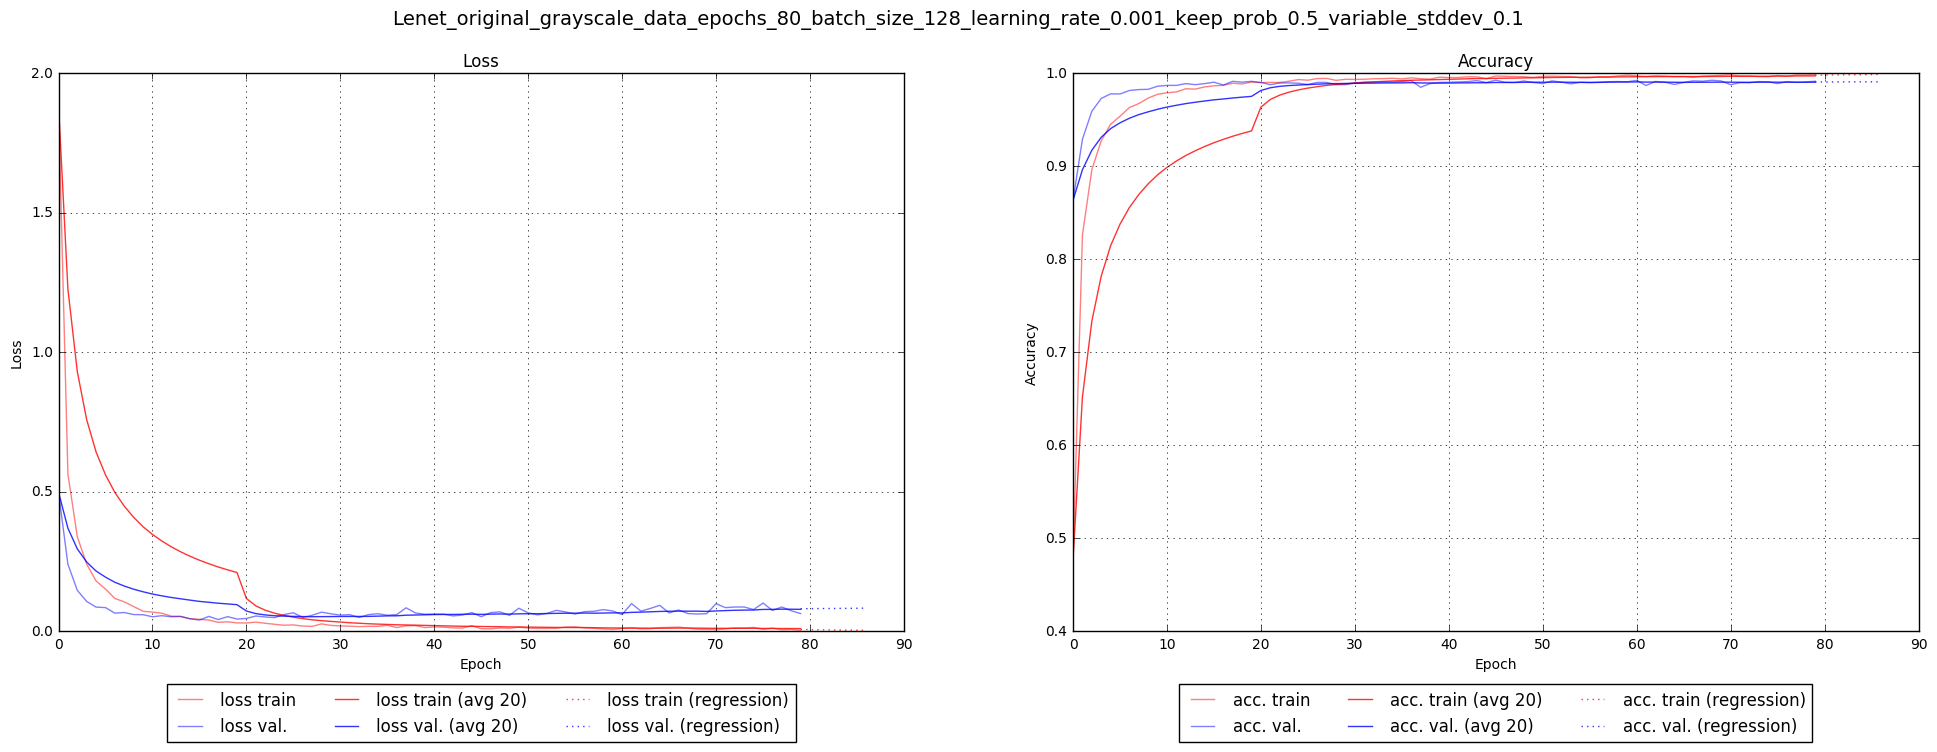

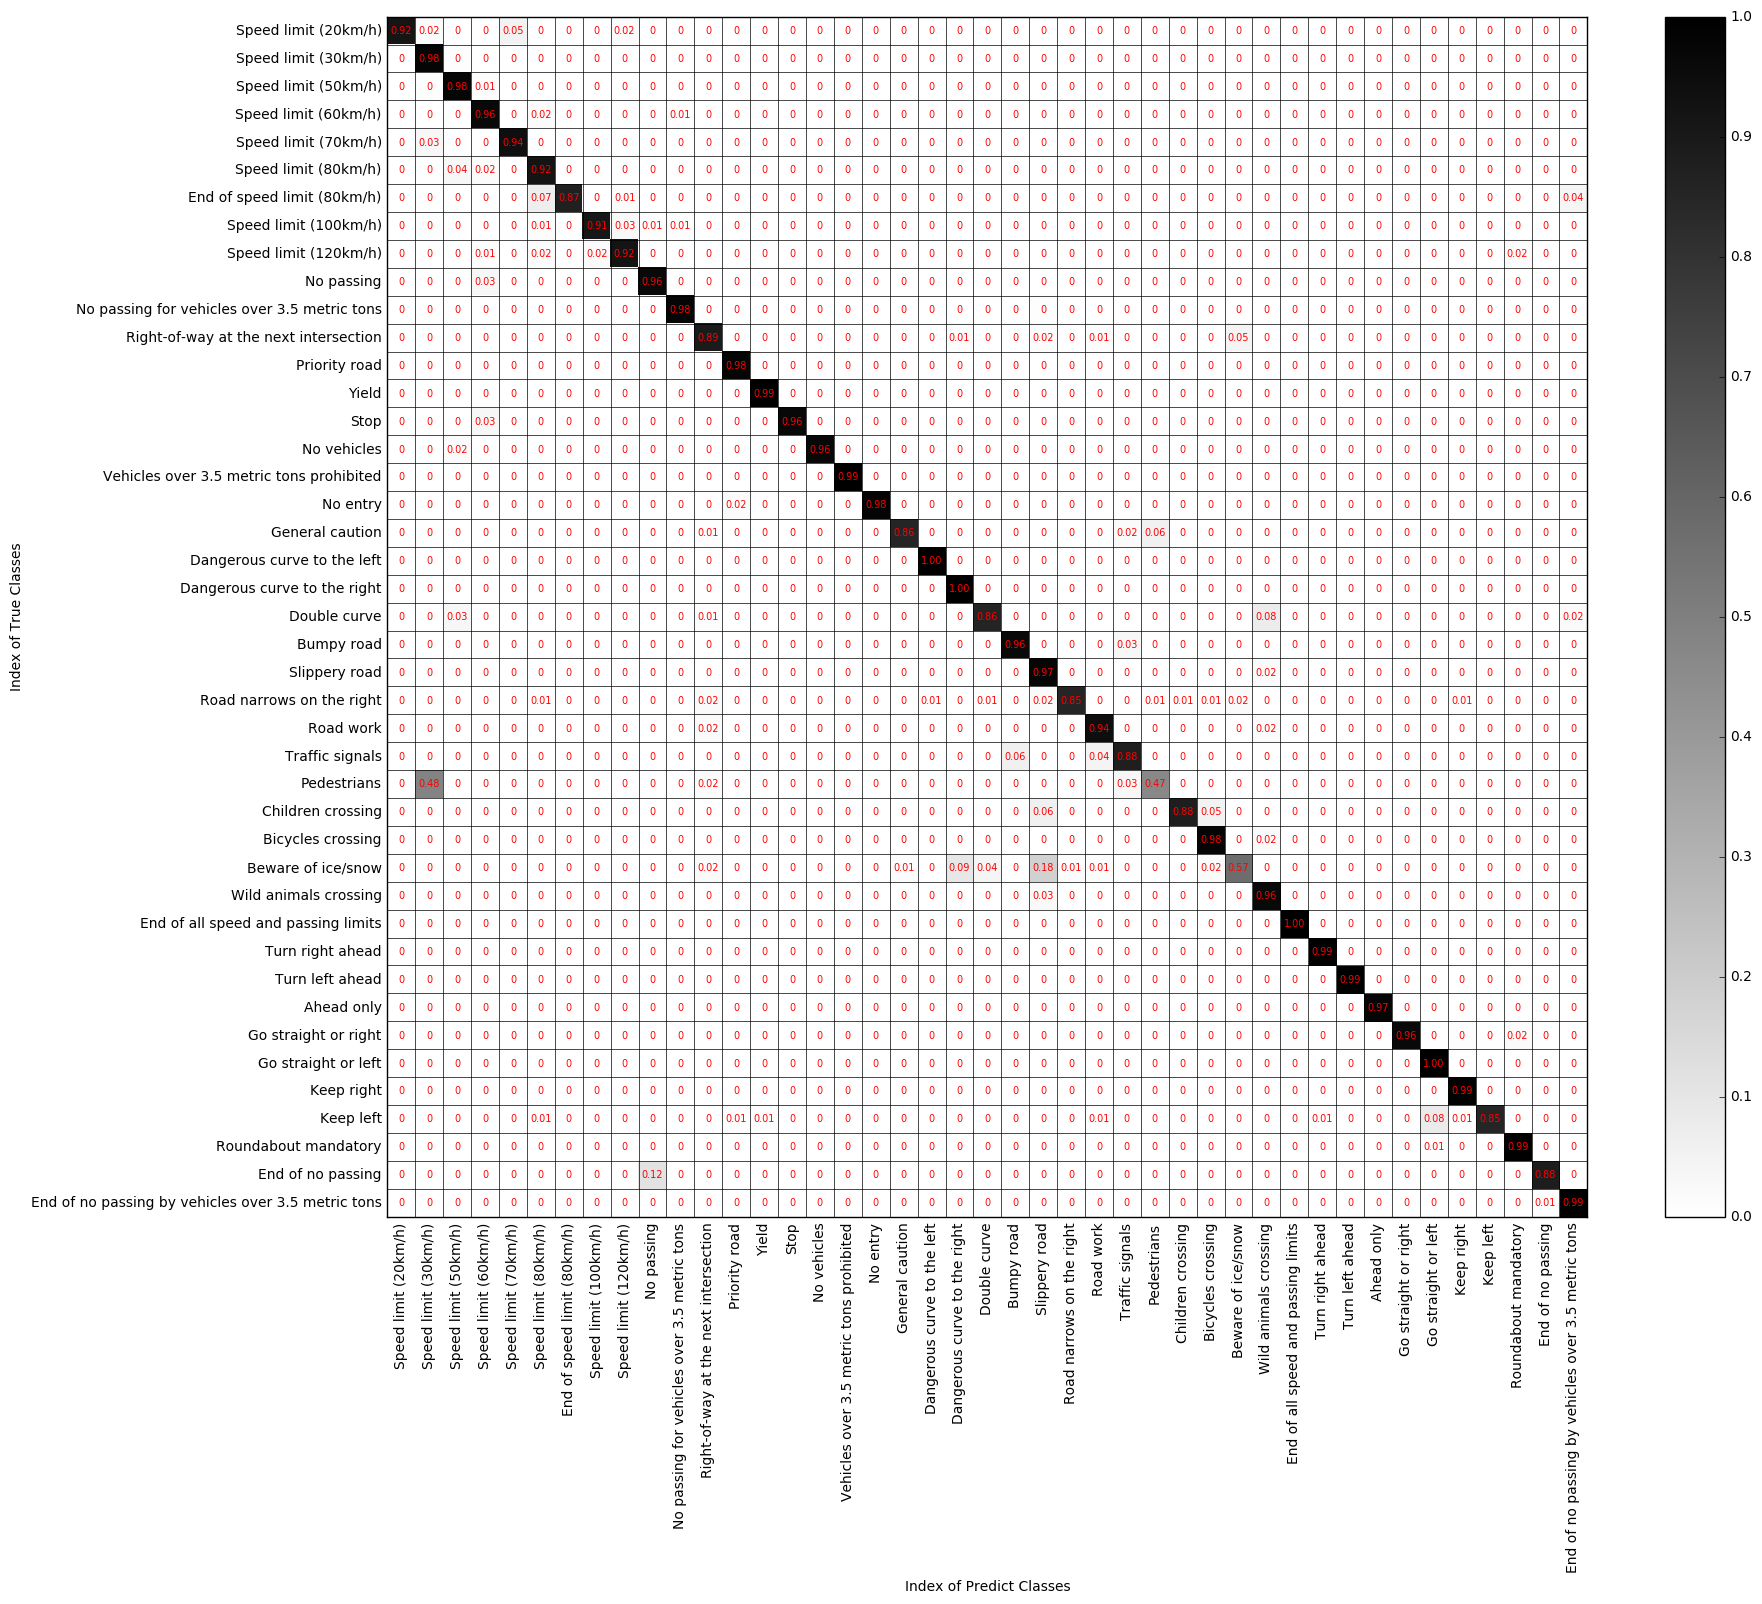

In [2]:
def test_basic_lenet_whitening_original_data():
    """
    0.946
    """
    provider = original_data_provider
    provider = normalise_image_whitening(provider)
    lenet = Lenet(TrafficDataSets(provider),
                  name="original_grayscale_data",
                  epochs=80, batch_size=128, variable_mean=0, variable_stddev=0.1,
                  learning_rate=0.001,
                  drop_out_keep_prob=0.5)
    lenet.train()
    Image(filename=lenet.file_name) 
    
test_basic_lenet_whitening_original_data()

2017-01-08 14:10:44,430 - training data 75312
2017-01-08 14:10:50,427 - EPOCH 1 training loss = 1.284 accuracy = 0.628 Validation loss = 0.348 accuracy = 0.904
2017-01-08 14:10:56,319 - EPOCH 2 training loss = 0.325 accuracy = 0.897 Validation loss = 0.155 accuracy = 0.957
2017-01-08 14:11:02,013 - EPOCH 3 training loss = 0.187 accuracy = 0.942 Validation loss = 0.116 accuracy = 0.966
2017-01-08 14:11:07,714 - EPOCH 4 training loss = 0.131 accuracy = 0.960 Validation loss = 0.080 accuracy = 0.979
2017-01-08 14:11:13,462 - EPOCH 5 training loss = 0.101 accuracy = 0.968 Validation loss = 0.070 accuracy = 0.980
2017-01-08 14:11:19,269 - EPOCH 6 training loss = 0.082 accuracy = 0.974 Validation loss = 0.066 accuracy = 0.981
2017-01-08 14:11:24,983 - EPOCH 7 training loss = 0.064 accuracy = 0.980 Validation loss = 0.064 accuracy = 0.981
2017-01-08 14:11:30,740 - EPOCH 8 training loss = 0.056 accuracy = 0.982 Validation loss = 0.054 accuracy = 0.988
2017-01-08 14:11:36,440 - EPOCH 9 training

TypeError: Cannot handle this data type

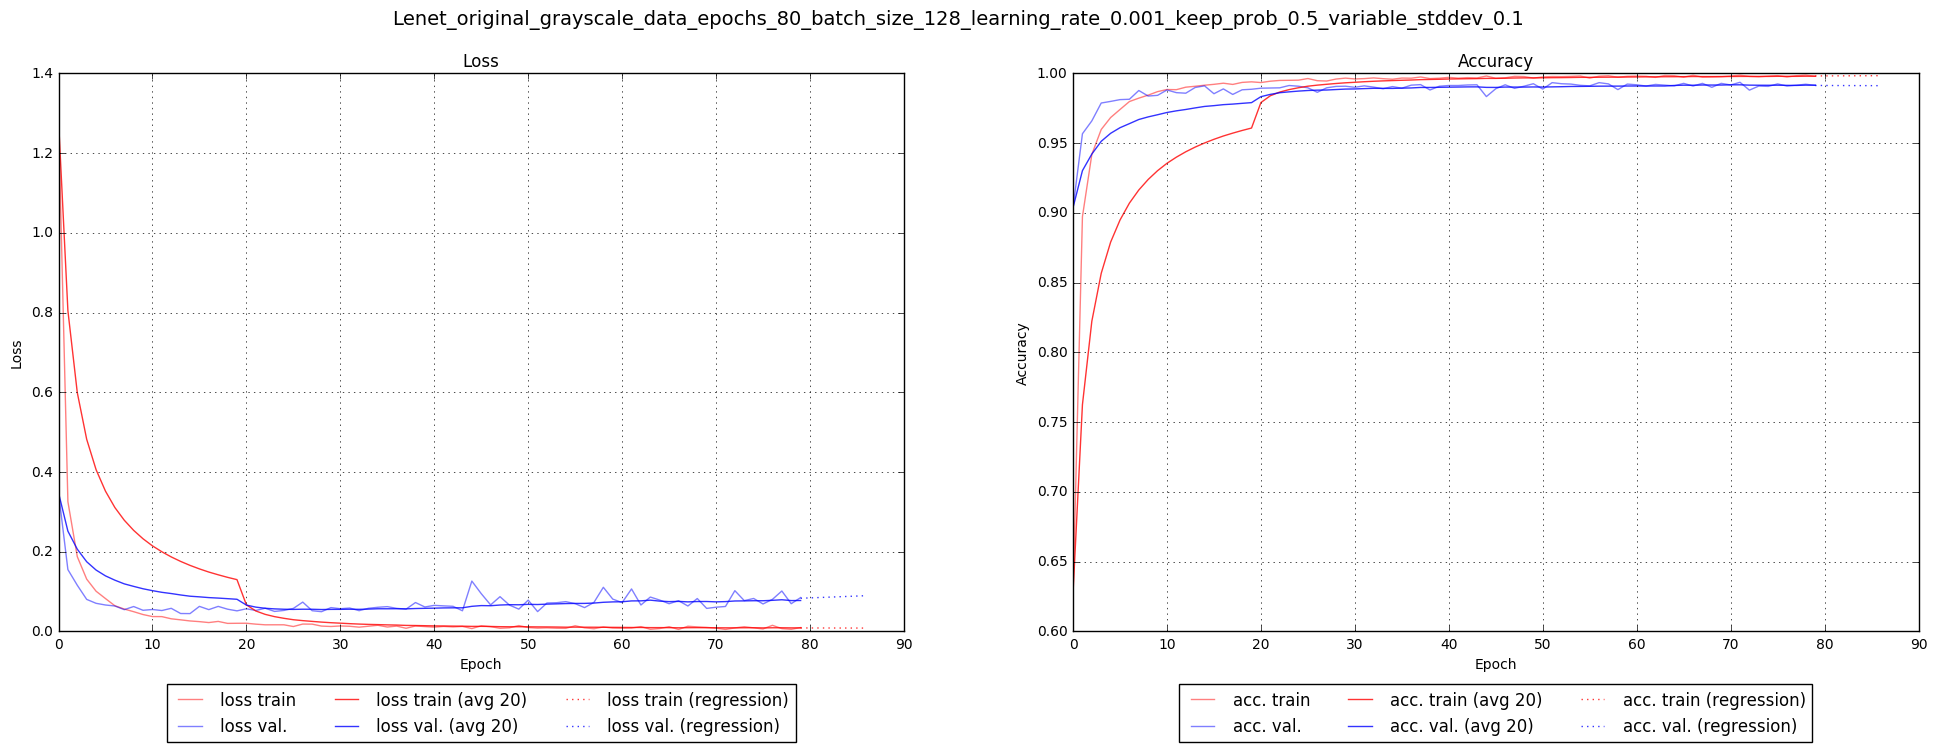

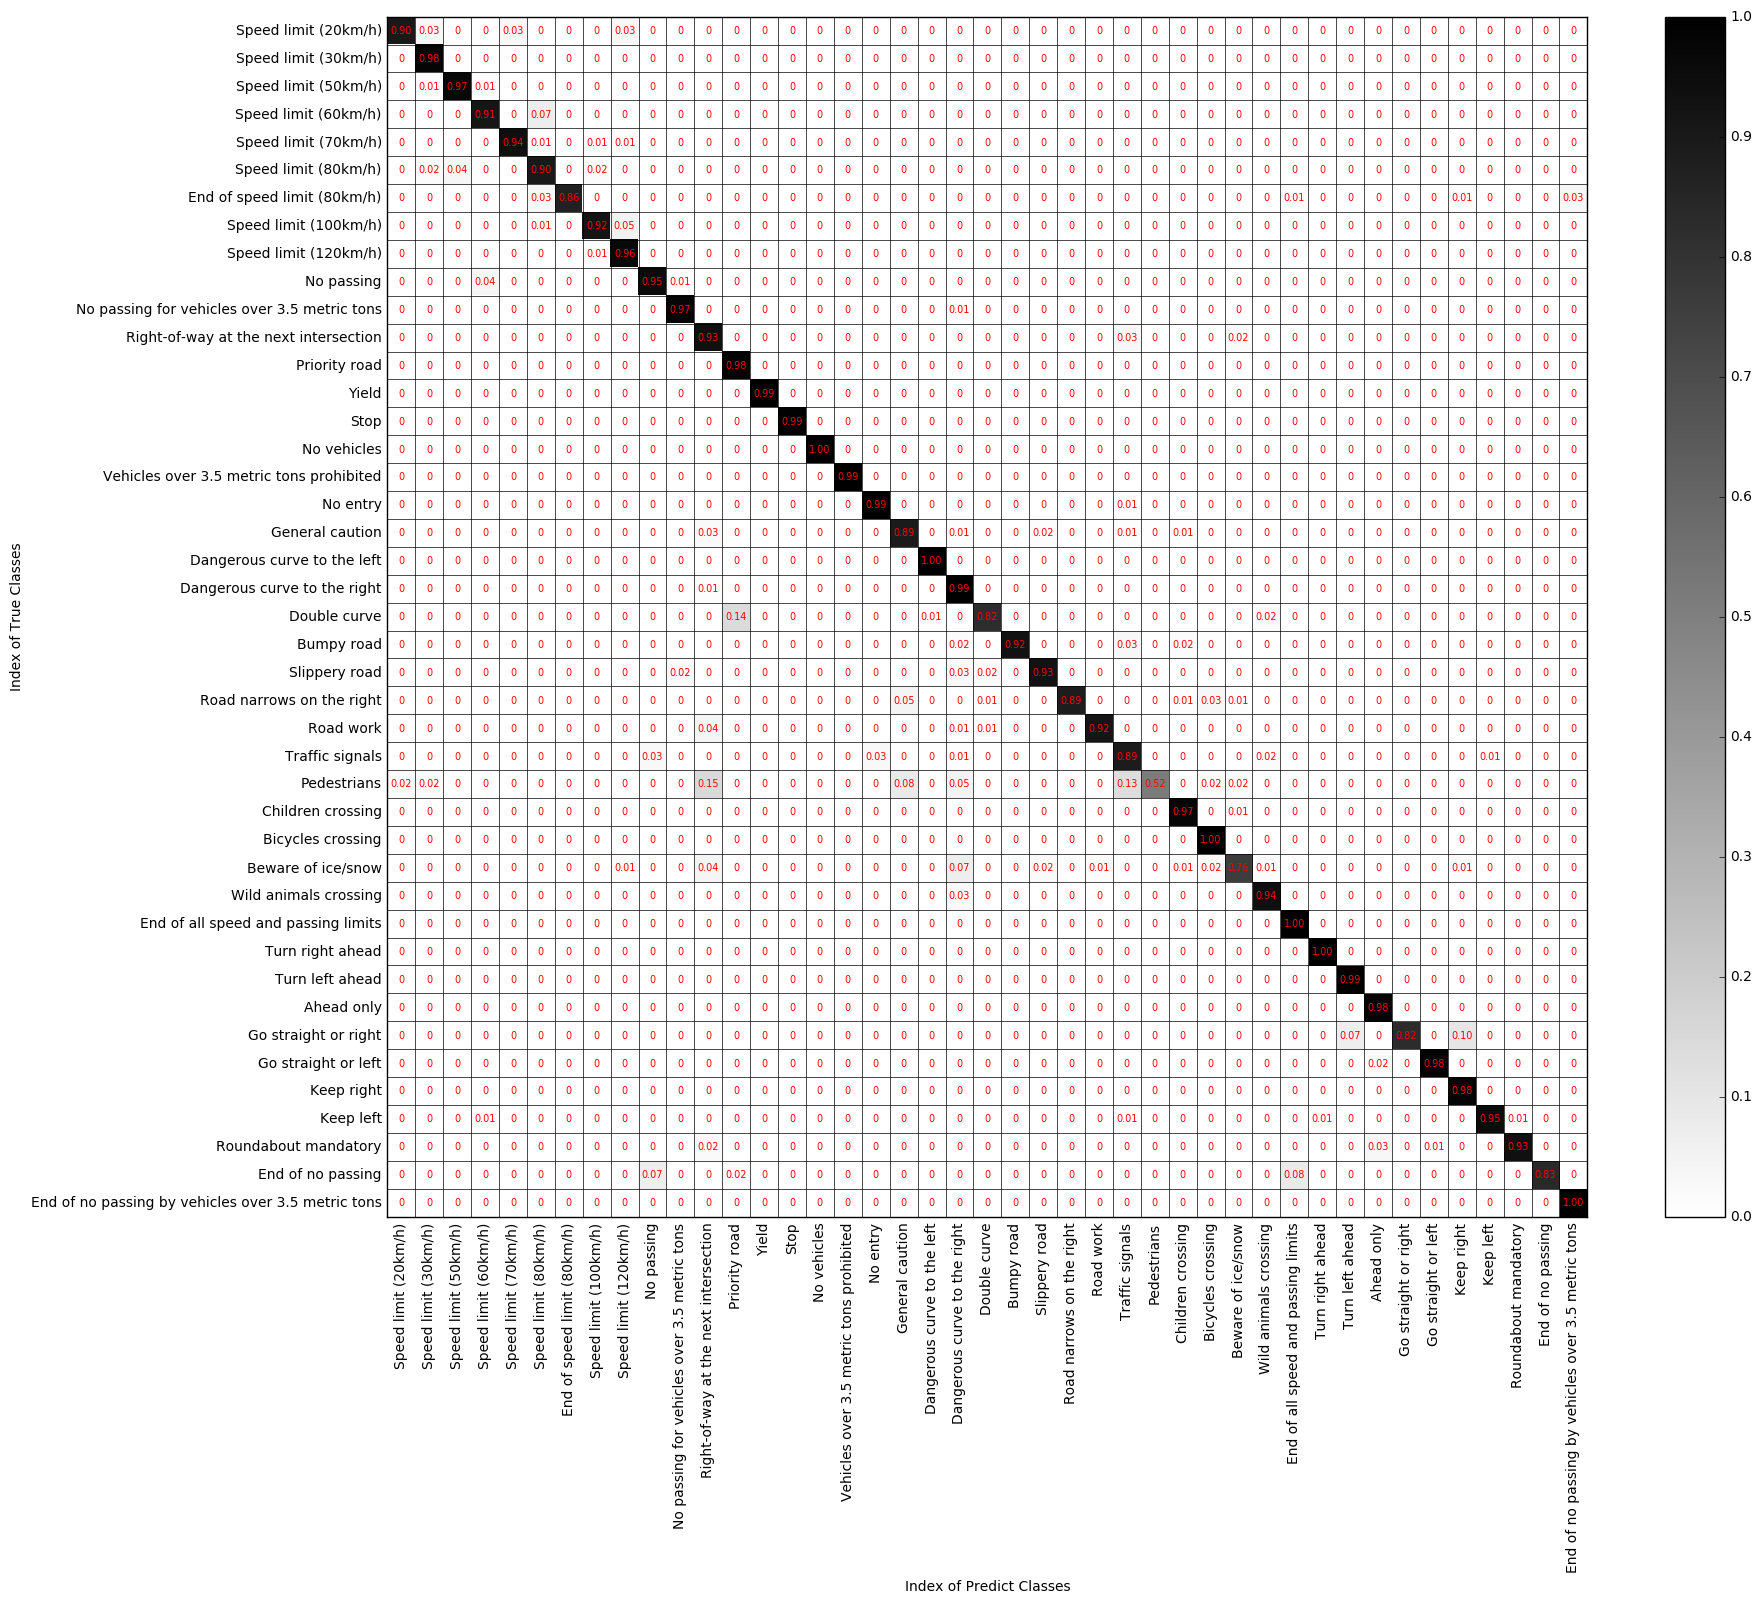

In [7]:
def test_basic_lenet_whitening_rotated_data():
    """
    0.948
    """
    provider = rotated_data_provider
    provider = normalise_image_whitening(provider)
    lenet = Lenet(TrafficDataSets(provider),
                  name="original_grayscale_data",
                  epochs=80, batch_size=128, variable_mean=0, variable_stddev=0.1,
                  learning_rate=0.001,
                  drop_out_keep_prob=0.5)
    lenet.train()
    Image(filename=lenet.file_name) 
    
test_basic_lenet_whitening_rotated_data()

2017-01-07 03:20:56,055 - training data 31367
2017-01-07 03:20:58,814 - EPOCH 1 Validation loss = 0.957 accuracy = 0.737
2017-01-07 03:21:01,615 - EPOCH 2 Validation loss = 0.519 accuracy = 0.867
2017-01-07 03:21:04,253 - EPOCH 3 Validation loss = 0.357 accuracy = 0.912
2017-01-07 03:21:06,788 - EPOCH 4 Validation loss = 0.333 accuracy = 0.921
2017-01-07 03:21:09,310 - EPOCH 5 Validation loss = 0.266 accuracy = 0.931
2017-01-07 03:21:12,035 - EPOCH 6 Validation loss = 0.248 accuracy = 0.942
2017-01-07 03:21:14,739 - EPOCH 7 Validation loss = 0.237 accuracy = 0.944
2017-01-07 03:21:17,256 - EPOCH 8 Validation loss = 0.223 accuracy = 0.954
2017-01-07 03:21:19,900 - EPOCH 9 Validation loss = 0.193 accuracy = 0.957
2017-01-07 03:21:22,418 - EPOCH 10 Validation loss = 0.180 accuracy = 0.961
2017-01-07 03:21:24,994 - EPOCH 11 Validation loss = 0.189 accuracy = 0.960
2017-01-07 03:21:27,655 - EPOCH 12 Validation loss = 0.169 accuracy = 0.962
2017-01-07 03:21:30,175 - EPOCH 13 Validation loss 

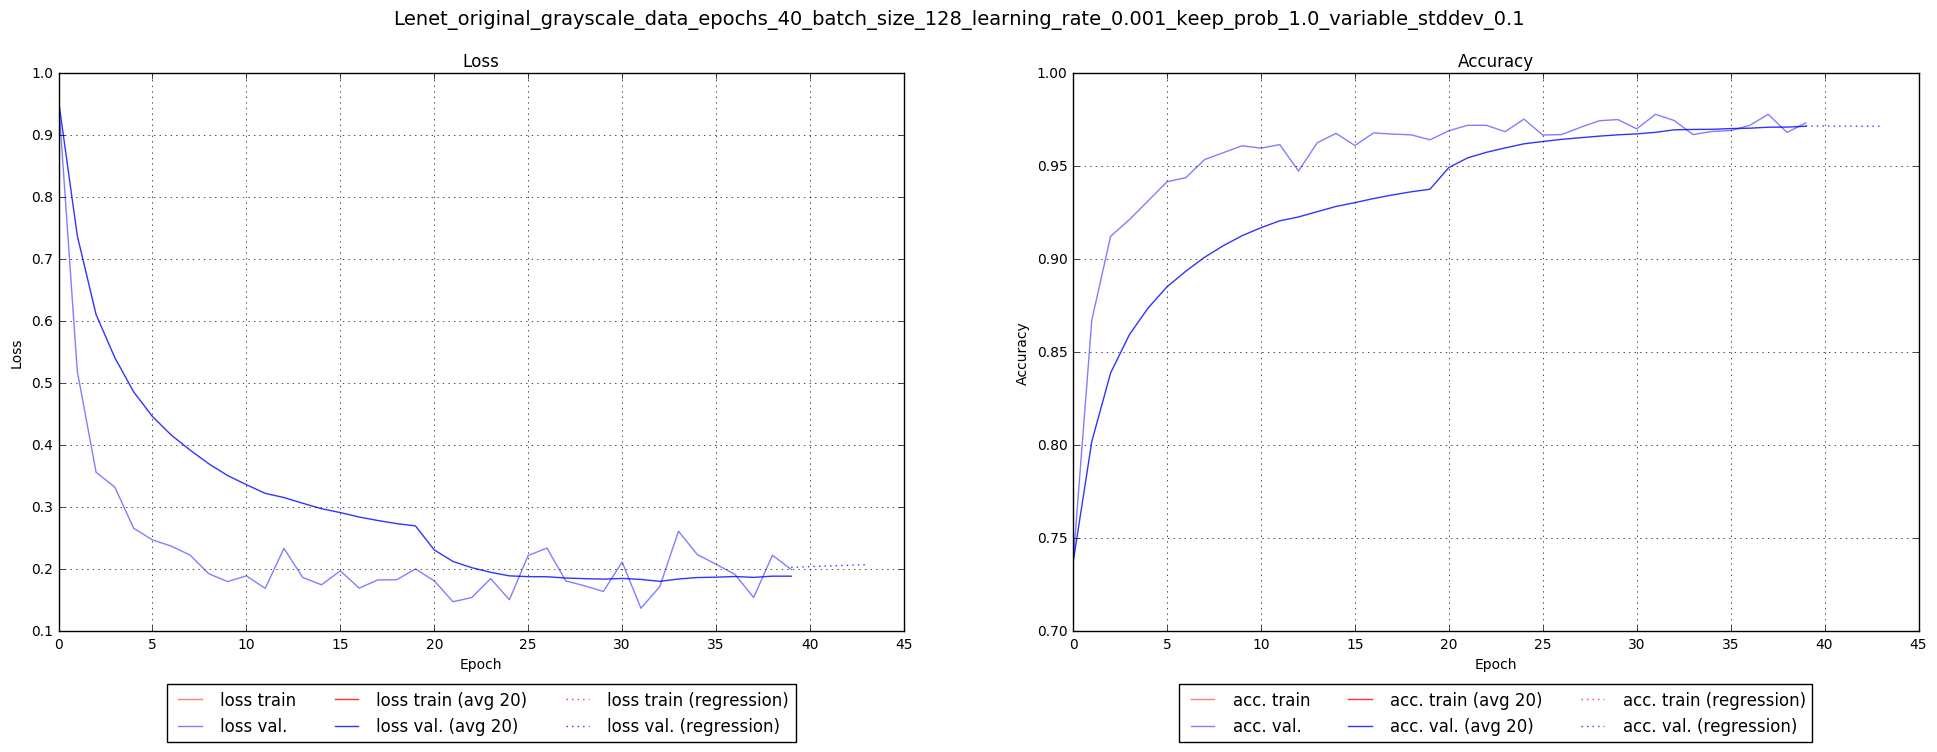

In [2]:
def test_basic_lenet_grayscale_original_data():
    """
    The basic one lenet
    GrayScale Images
    DropOut: NO
    """
    provider = original_data_provider
    provider = grayscale(provider)
    lenet = Lenet(TrafficDataSets(provider),
                  name="original_grayscale_data",
                  epochs=40, batch_size=128, variable_mean=0, variable_stddev=0.1,
                  learning_rate=0.001,
                  drop_out_keep_prob=1.0)
    lenet.train()
    Image(filename=lenet.file_name) 
    
test_basic_lenet_grayscale_original_data()

2017-01-07 04:28:29,629 - training data 31367
2017-01-07 04:28:32,667 - EPOCH 1 training loss = 4.576 accuracy = 0.146 Validation loss = 2.208 accuracy = 0.440
2017-01-07 04:28:35,497 - EPOCH 2 training loss = 2.052 accuracy = 0.425 Validation loss = 1.156 accuracy = 0.690
2017-01-07 04:28:38,038 - EPOCH 3 training loss = 1.338 accuracy = 0.609 Validation loss = 0.702 accuracy = 0.796
2017-01-07 04:28:40,716 - EPOCH 4 training loss = 1.000 accuracy = 0.705 Validation loss = 0.517 accuracy = 0.858
2017-01-07 04:28:43,364 - EPOCH 5 training loss = 0.778 accuracy = 0.766 Validation loss = 0.388 accuracy = 0.902
2017-01-07 04:28:46,107 - EPOCH 6 training loss = 0.612 accuracy = 0.818 Validation loss = 0.301 accuracy = 0.924
2017-01-07 04:28:48,720 - EPOCH 7 training loss = 0.501 accuracy = 0.851 Validation loss = 0.256 accuracy = 0.934
2017-01-07 04:28:51,298 - EPOCH 8 training loss = 0.434 accuracy = 0.872 Validation loss = 0.237 accuracy = 0.935
2017-01-07 04:28:53,974 - EPOCH 9 training

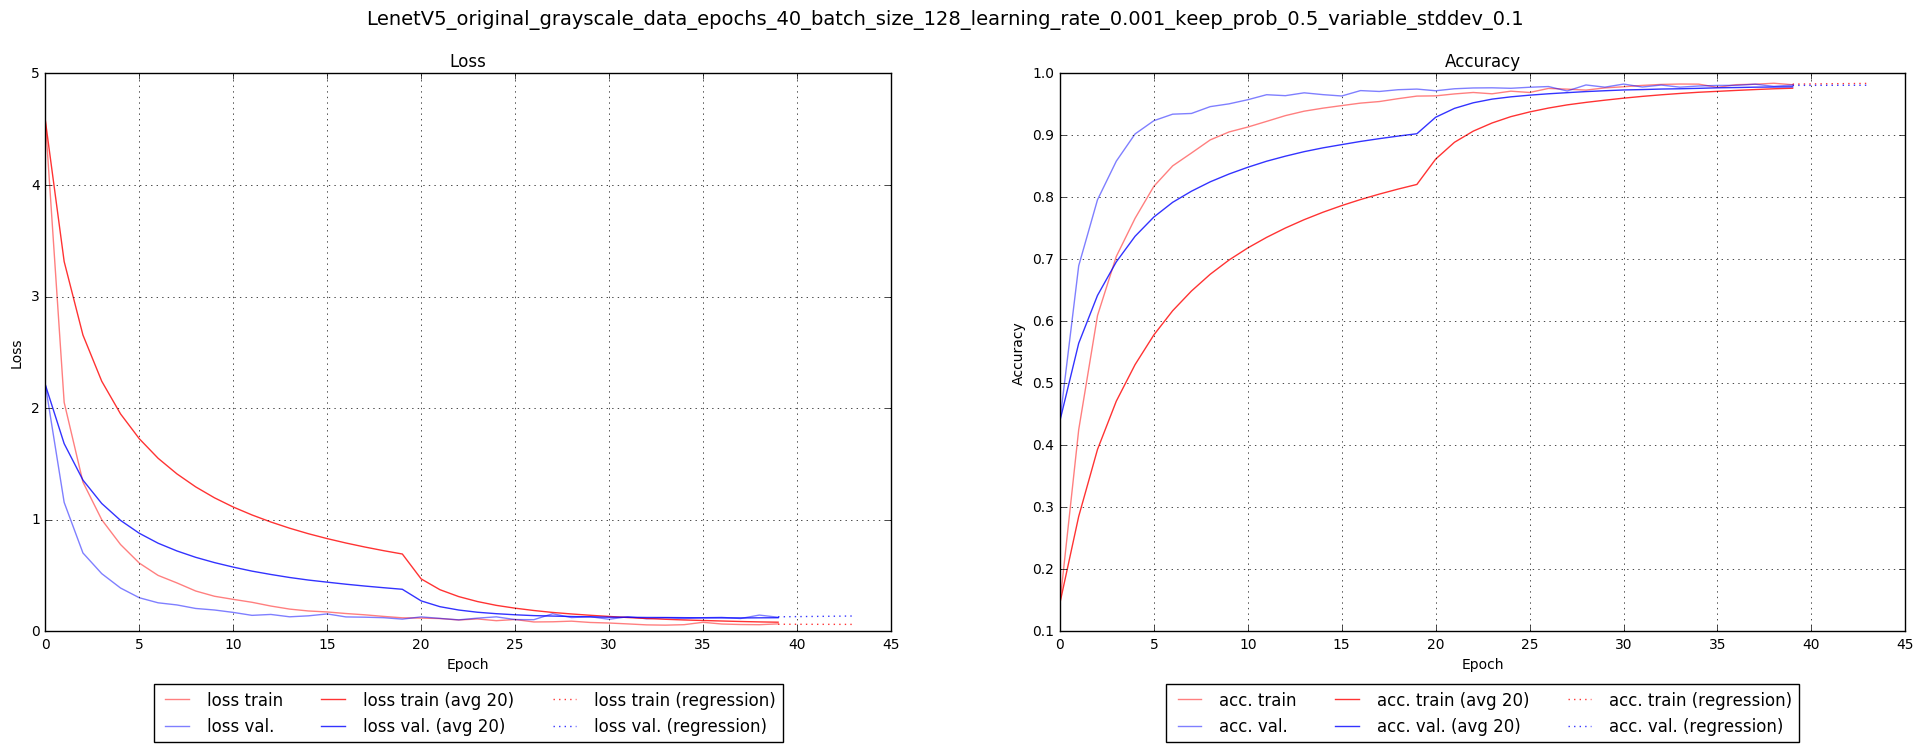

In [4]:
def test_basic_lenet_v5_original_data():
    """
    The basic one lenet
    GrayScale Images
    DropOut: NO
    """
    provider = original_data_provider
    provider = grayscale(provider)
    lenet = LenetV5(TrafficDataSets(provider),
                  name="original_grayscale_data",
                  epochs=40, batch_size=128, variable_mean=0, variable_stddev=0.1,
                  learning_rate=0.001,
                  drop_out_keep_prob=0.5)
    lenet.train()
    Image(filename=lenet.file_name) 
    
test_basic_lenet_v5_original_data()

2017-01-07 12:36:00,388 - training data 168698
2017-01-07 12:36:10,617 - EPOCH 1 training loss = 3.523 accuracy = 0.084 Validation loss = 3.700 accuracy = 0.070
2017-01-07 12:36:22,860 - EPOCH 2 training loss = 2.240 accuracy = 0.339 Validation loss = 0.891 accuracy = 0.758
2017-01-07 12:36:34,742 - EPOCH 3 training loss = 1.099 accuracy = 0.646 Validation loss = 0.513 accuracy = 0.871
2017-01-07 12:36:46,605 - EPOCH 4 training loss = 0.787 accuracy = 0.747 Validation loss = 0.347 accuracy = 0.914
2017-01-07 12:36:58,486 - EPOCH 5 training loss = 0.627 accuracy = 0.799 Validation loss = 0.254 accuracy = 0.934
2017-01-07 12:37:10,494 - EPOCH 6 training loss = 0.523 accuracy = 0.833 Validation loss = 0.209 accuracy = 0.944
2017-01-07 12:37:22,461 - EPOCH 7 training loss = 0.443 accuracy = 0.857 Validation loss = 0.172 accuracy = 0.952
2017-01-07 12:37:34,369 - EPOCH 8 training loss = 0.382 accuracy = 0.876 Validation loss = 0.140 accuracy = 0.962
2017-01-07 12:37:46,408 - EPOCH 9 trainin

TypeError: Cannot handle this data type

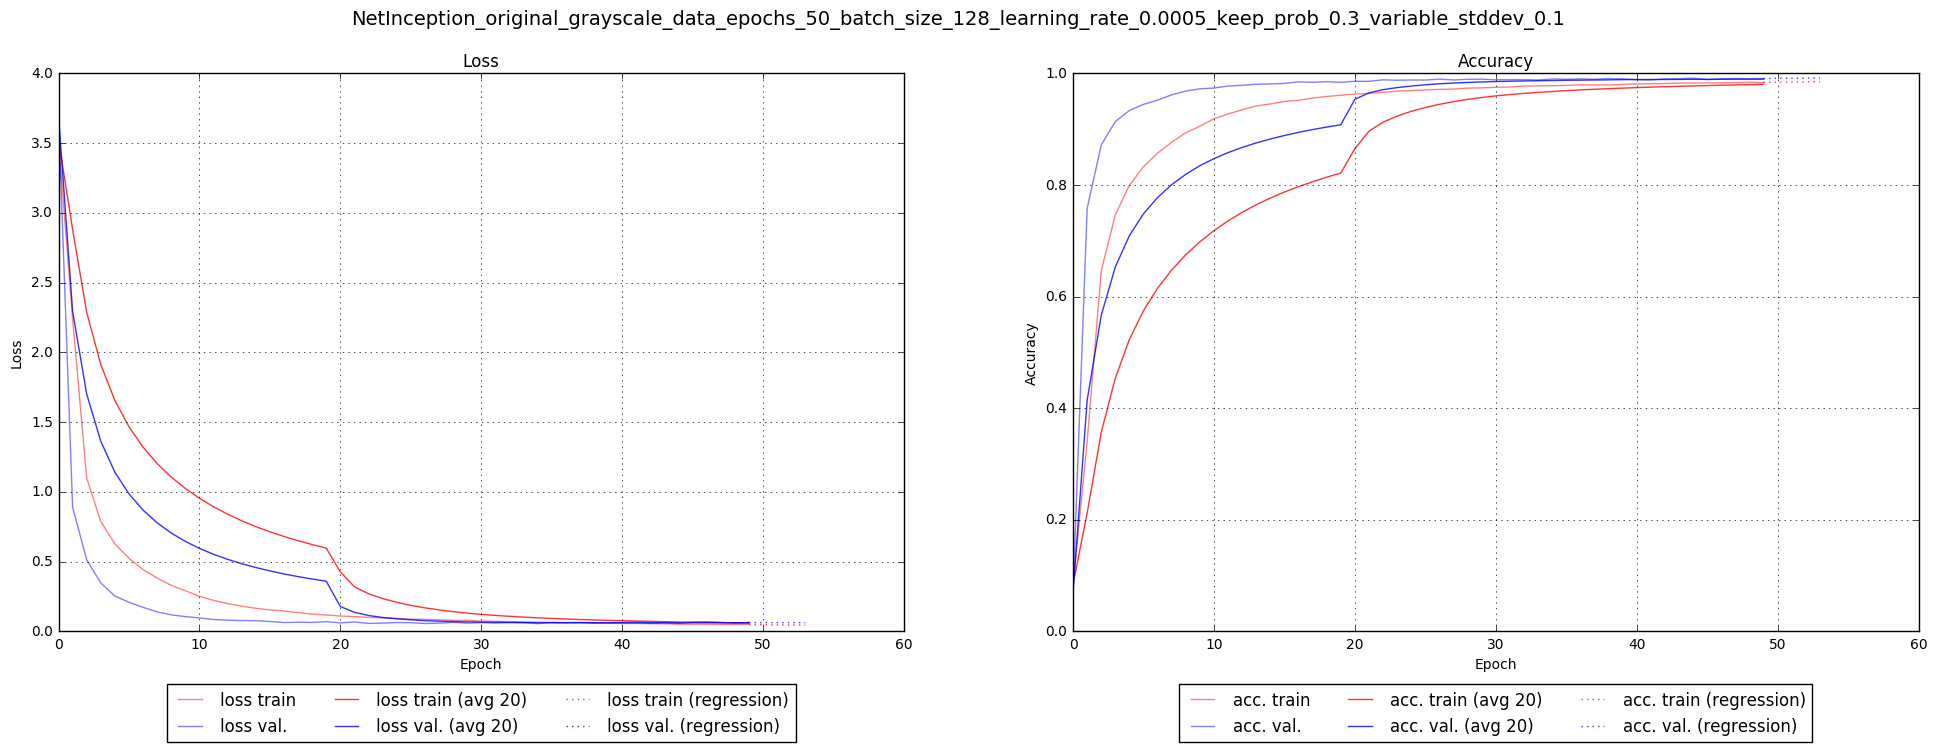

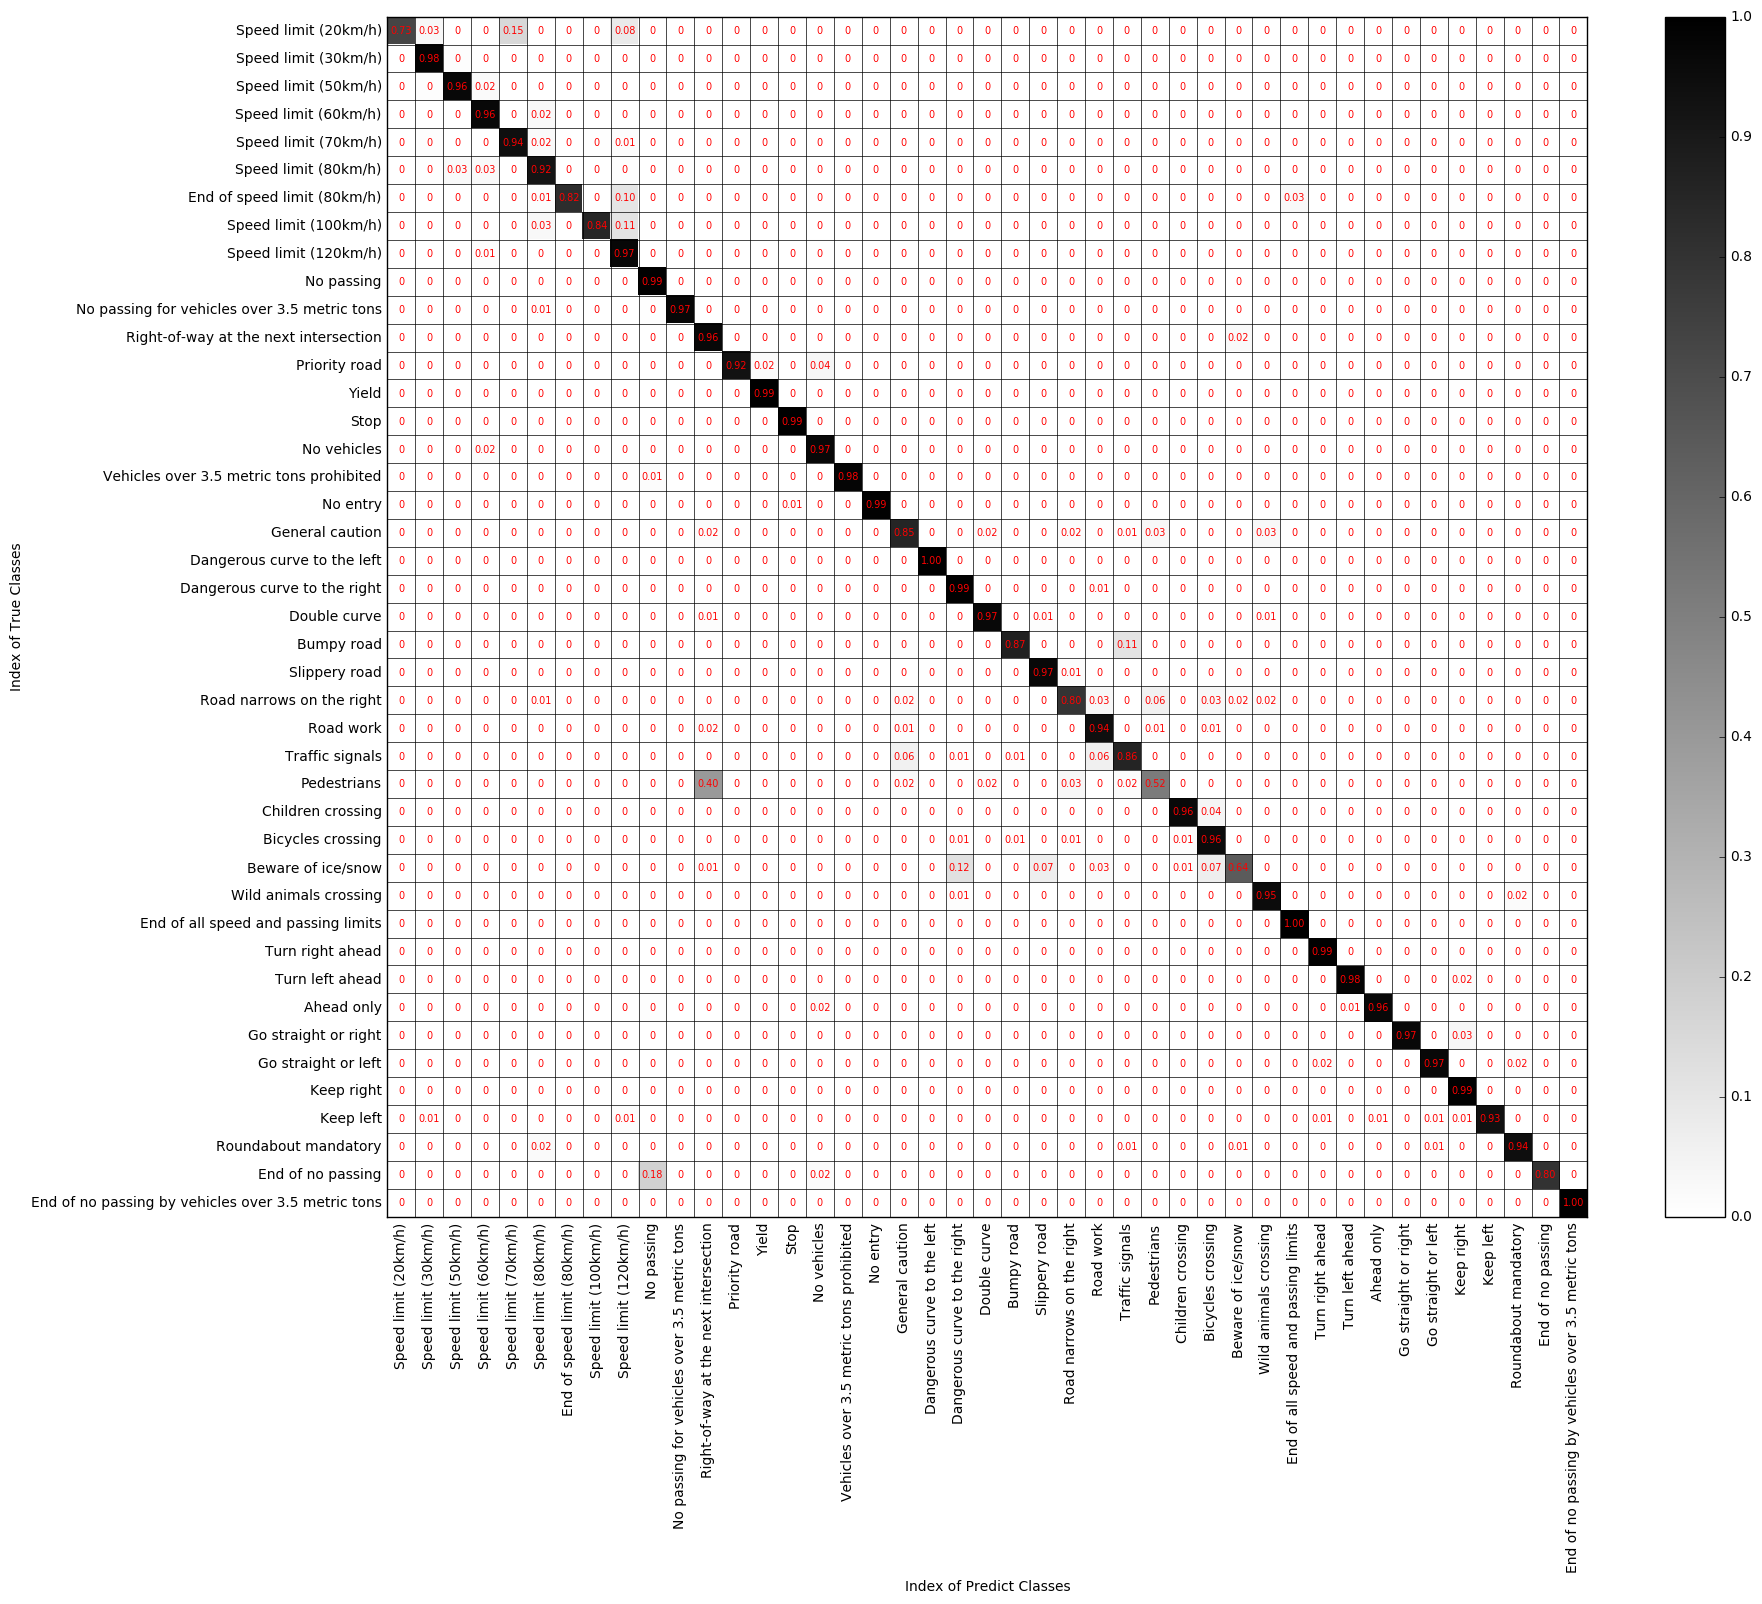

In [2]:
def test_basic_lenet_inception_original_data():
    """
    0.942, 40% validation, 3 rotate
    0.943, 40% validation, 3 zoomin
    0.944, 40% validation, 3 zoomin or rotate
    """
    provider = TrafficDataRealFileProviderAutoSplitValidationData(
            split_validation_from_train=True, validation_size=0.40)
#     provider = rotated_data_provider
#     images, labels = enhance_with_random_rotate(provider.X_train, provider.y_train, 3)
#     images, labels = enhance_with_random_zoomin(provider.X_train, provider.y_train, 3)
    images, labels = enhance_with_random_zoomin_and_rotate(provider.X_train, provider.y_train, 3)
    provider = provider.to_other_provider(X_train_overwrite=images, y_train_overwrite=labels)
#     provider = grayscale(provider)
    provider = normalise_image_positive(provider)
    lenet = NetInception(TrafficDataSets(provider),
                  name="original_grayscale_data",
                  epochs=50, batch_size=128, variable_mean=0, variable_stddev=0.1,
                  learning_rate=0.0005,
                  drop_out_keep_prob=0.3)
    lenet.train()
    Image(filename=lenet.file_name) 
    Image(filename=lenet.file_name_confusion_matrix) 
    Image(filename=lenet.file_name_wrong_predicts) 
    
test_basic_lenet_inception_original_data()

2017-01-07 10:45:03,317 - training data 163989
2017-01-07 10:45:13,285 - EPOCH 1 training loss = 3.408 accuracy = 0.131 Validation loss = 3.415 accuracy = 0.173
2017-01-07 10:45:25,181 - EPOCH 2 training loss = 1.893 accuracy = 0.415 Validation loss = 0.662 accuracy = 0.830
2017-01-07 10:45:36,649 - EPOCH 3 training loss = 0.889 accuracy = 0.709 Validation loss = 0.333 accuracy = 0.919
2017-01-07 10:45:47,909 - EPOCH 4 training loss = 0.597 accuracy = 0.806 Validation loss = 0.205 accuracy = 0.951
2017-01-07 10:45:59,352 - EPOCH 5 training loss = 0.448 accuracy = 0.854 Validation loss = 0.153 accuracy = 0.963
2017-01-07 10:46:10,867 - EPOCH 6 training loss = 0.354 accuracy = 0.885 Validation loss = 0.120 accuracy = 0.969
2017-01-07 10:46:22,425 - EPOCH 7 training loss = 0.296 accuracy = 0.905 Validation loss = 0.095 accuracy = 0.976
2017-01-07 10:46:33,762 - EPOCH 8 training loss = 0.249 accuracy = 0.920 Validation loss = 0.082 accuracy = 0.979
2017-01-07 10:46:45,269 - EPOCH 9 trainin

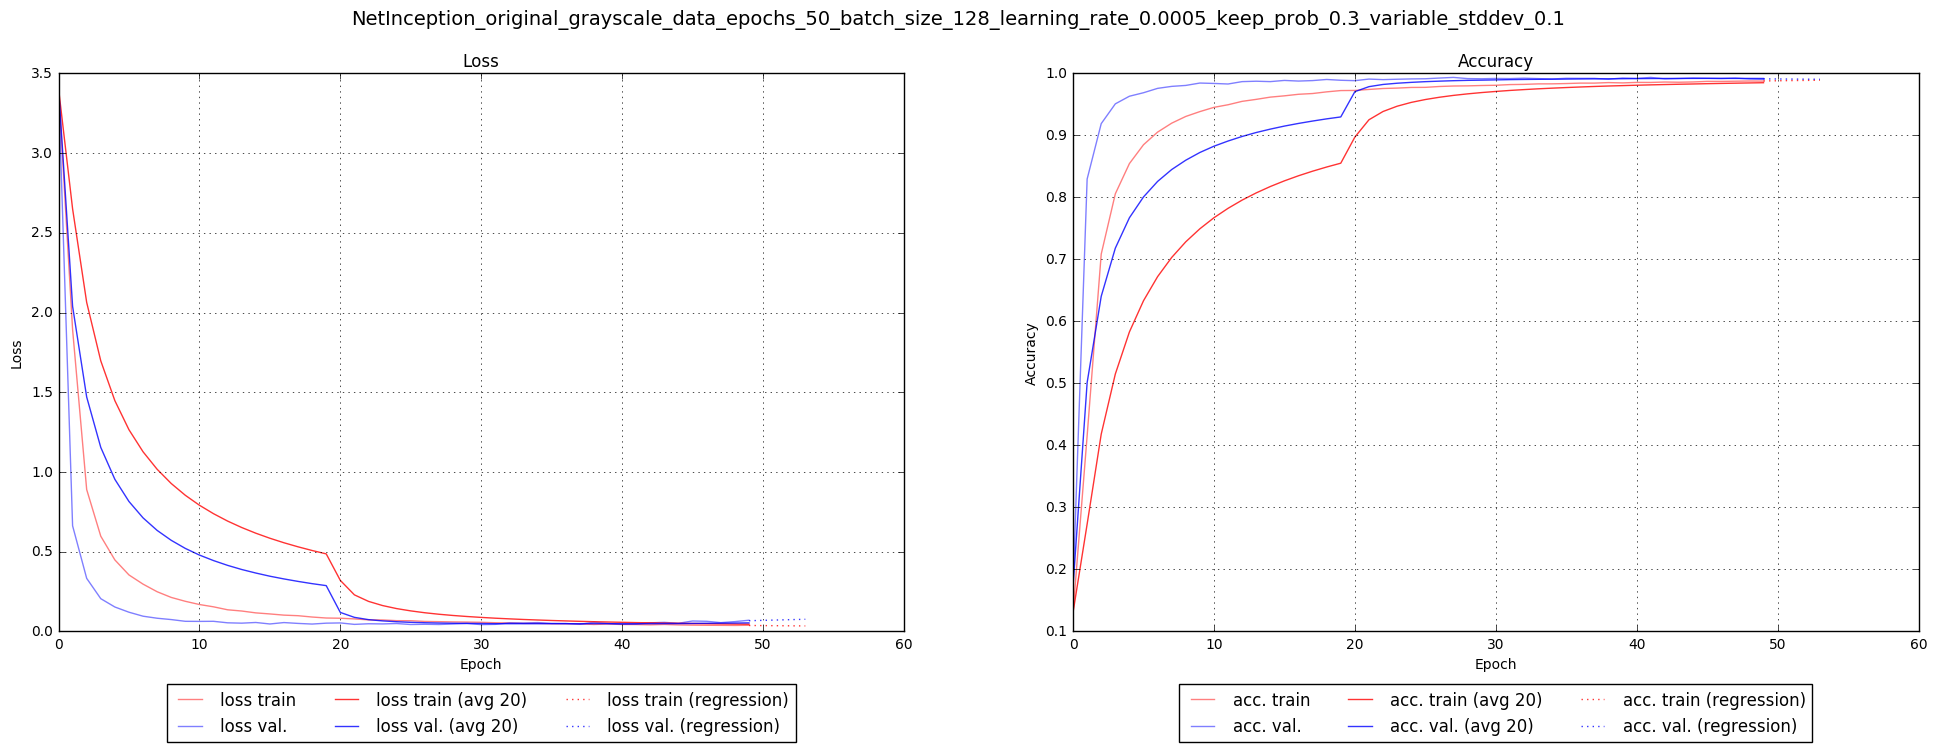

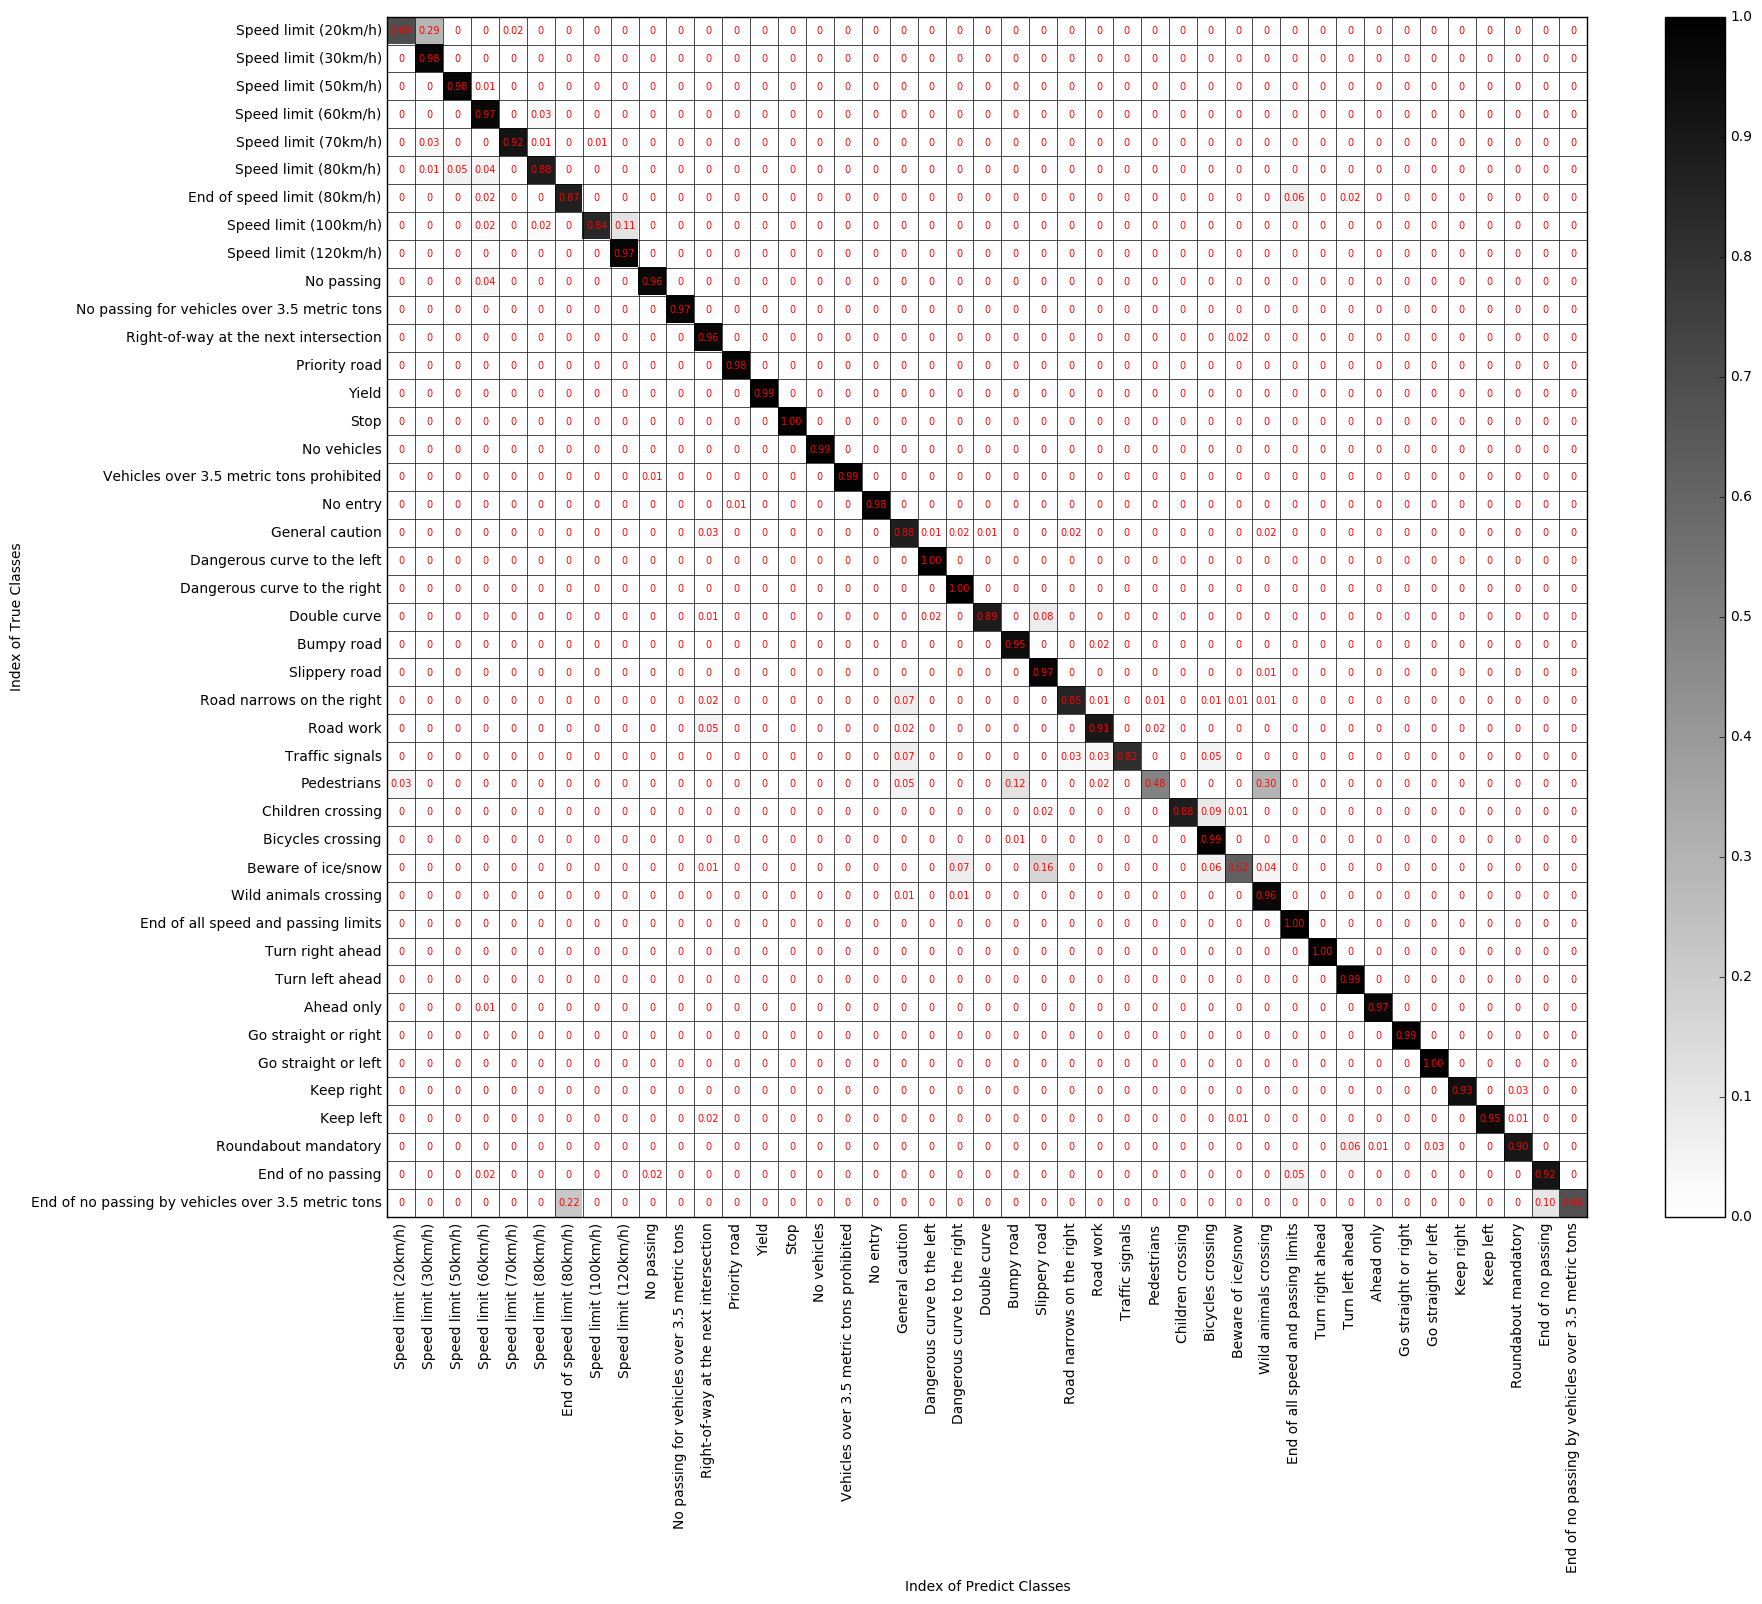

In [2]:
def test_basic_lenet_inception_rotate_2_data():
    provider = augment_data_random_rotate(2)
#     provider = grayscale(provider)
    provider = normalise_image_positive(provider)
    lenet = NetInception(TrafficDataSets(provider),
                  name="original_grayscale_data",
                  epochs=50, batch_size=128, variable_mean=0, variable_stddev=0.1,
                  learning_rate=0.0005,
                  drop_out_keep_prob=0.3)
    lenet.train()
    Image(filename=lenet.file_name) 
    Image(filename=lenet.file_name_confusion_matrix) 
    
test_basic_lenet_inception_rotate_2_data()

2017-01-07 08:00:59,378 - training data 75612
2017-01-07 08:01:04,678 - EPOCH 1 training loss = 6.465 accuracy = 0.019 Validation loss = 3.742 accuracy = 0.030
2017-01-07 08:01:09,939 - EPOCH 2 training loss = 3.748 accuracy = 0.039 Validation loss = 3.593 accuracy = 0.080
2017-01-07 08:01:15,181 - EPOCH 3 training loss = 3.659 accuracy = 0.048 Validation loss = 3.531 accuracy = 0.084
2017-01-07 08:01:20,281 - EPOCH 4 training loss = 3.582 accuracy = 0.059 Validation loss = 3.470 accuracy = 0.102
2017-01-07 08:01:25,544 - EPOCH 5 training loss = 3.464 accuracy = 0.068 Validation loss = 3.267 accuracy = 0.121
2017-01-07 08:01:30,708 - EPOCH 6 training loss = 3.366 accuracy = 0.093 Validation loss = 3.195 accuracy = 0.174
2017-01-07 08:01:35,890 - EPOCH 7 training loss = 3.282 accuracy = 0.121 Validation loss = 3.056 accuracy = 0.220
2017-01-07 08:01:41,104 - EPOCH 8 training loss = 3.128 accuracy = 0.156 Validation loss = 2.846 accuracy = 0.249
2017-01-07 08:01:46,302 - EPOCH 9 training

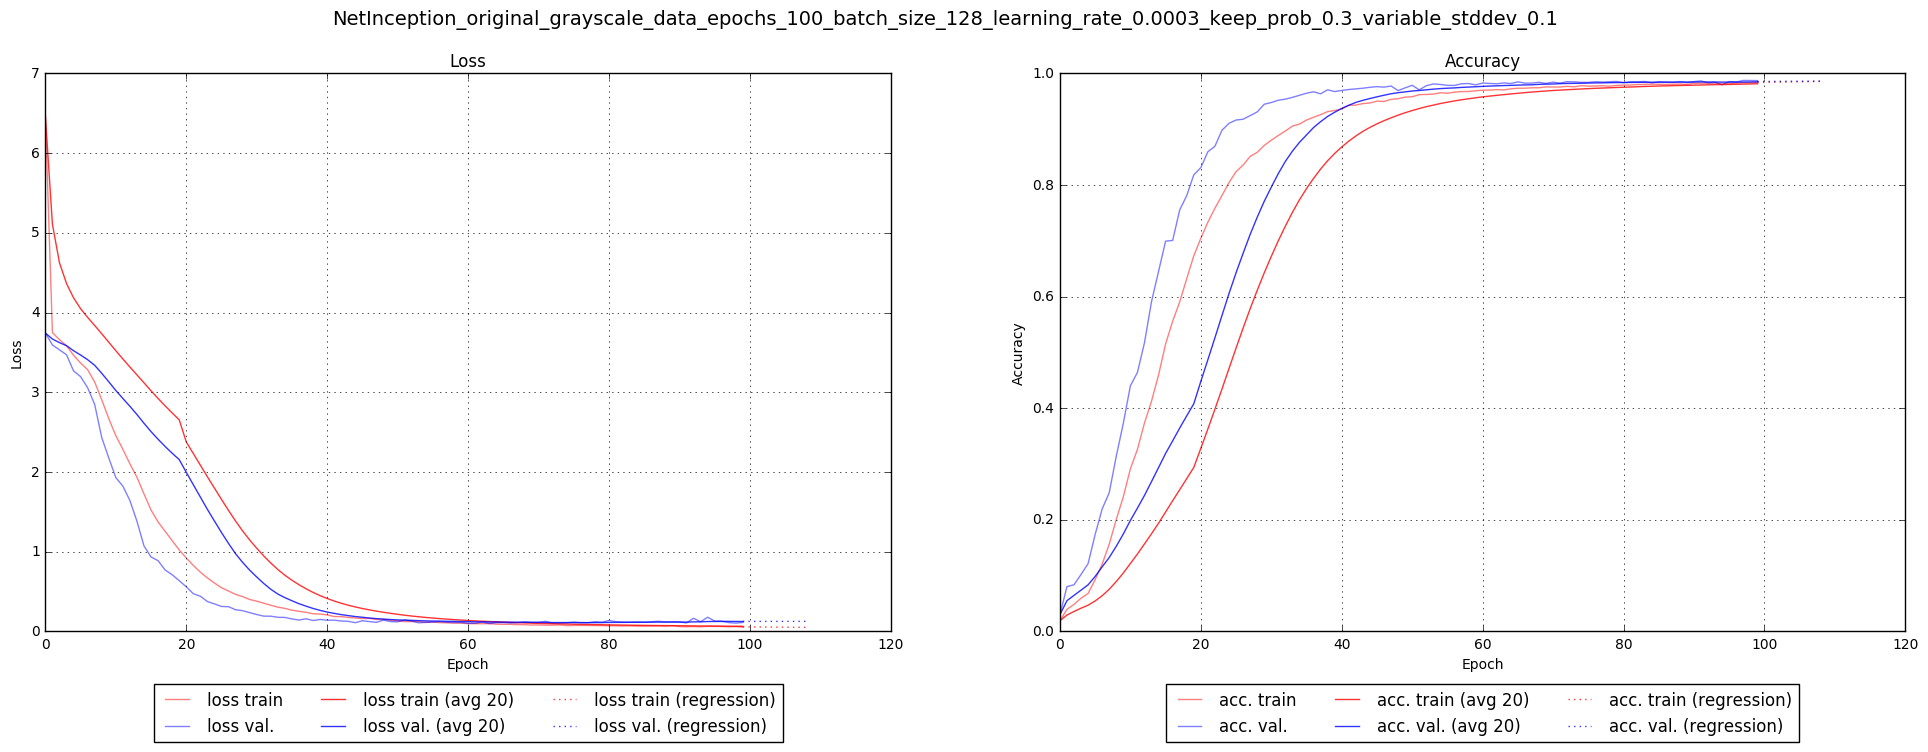

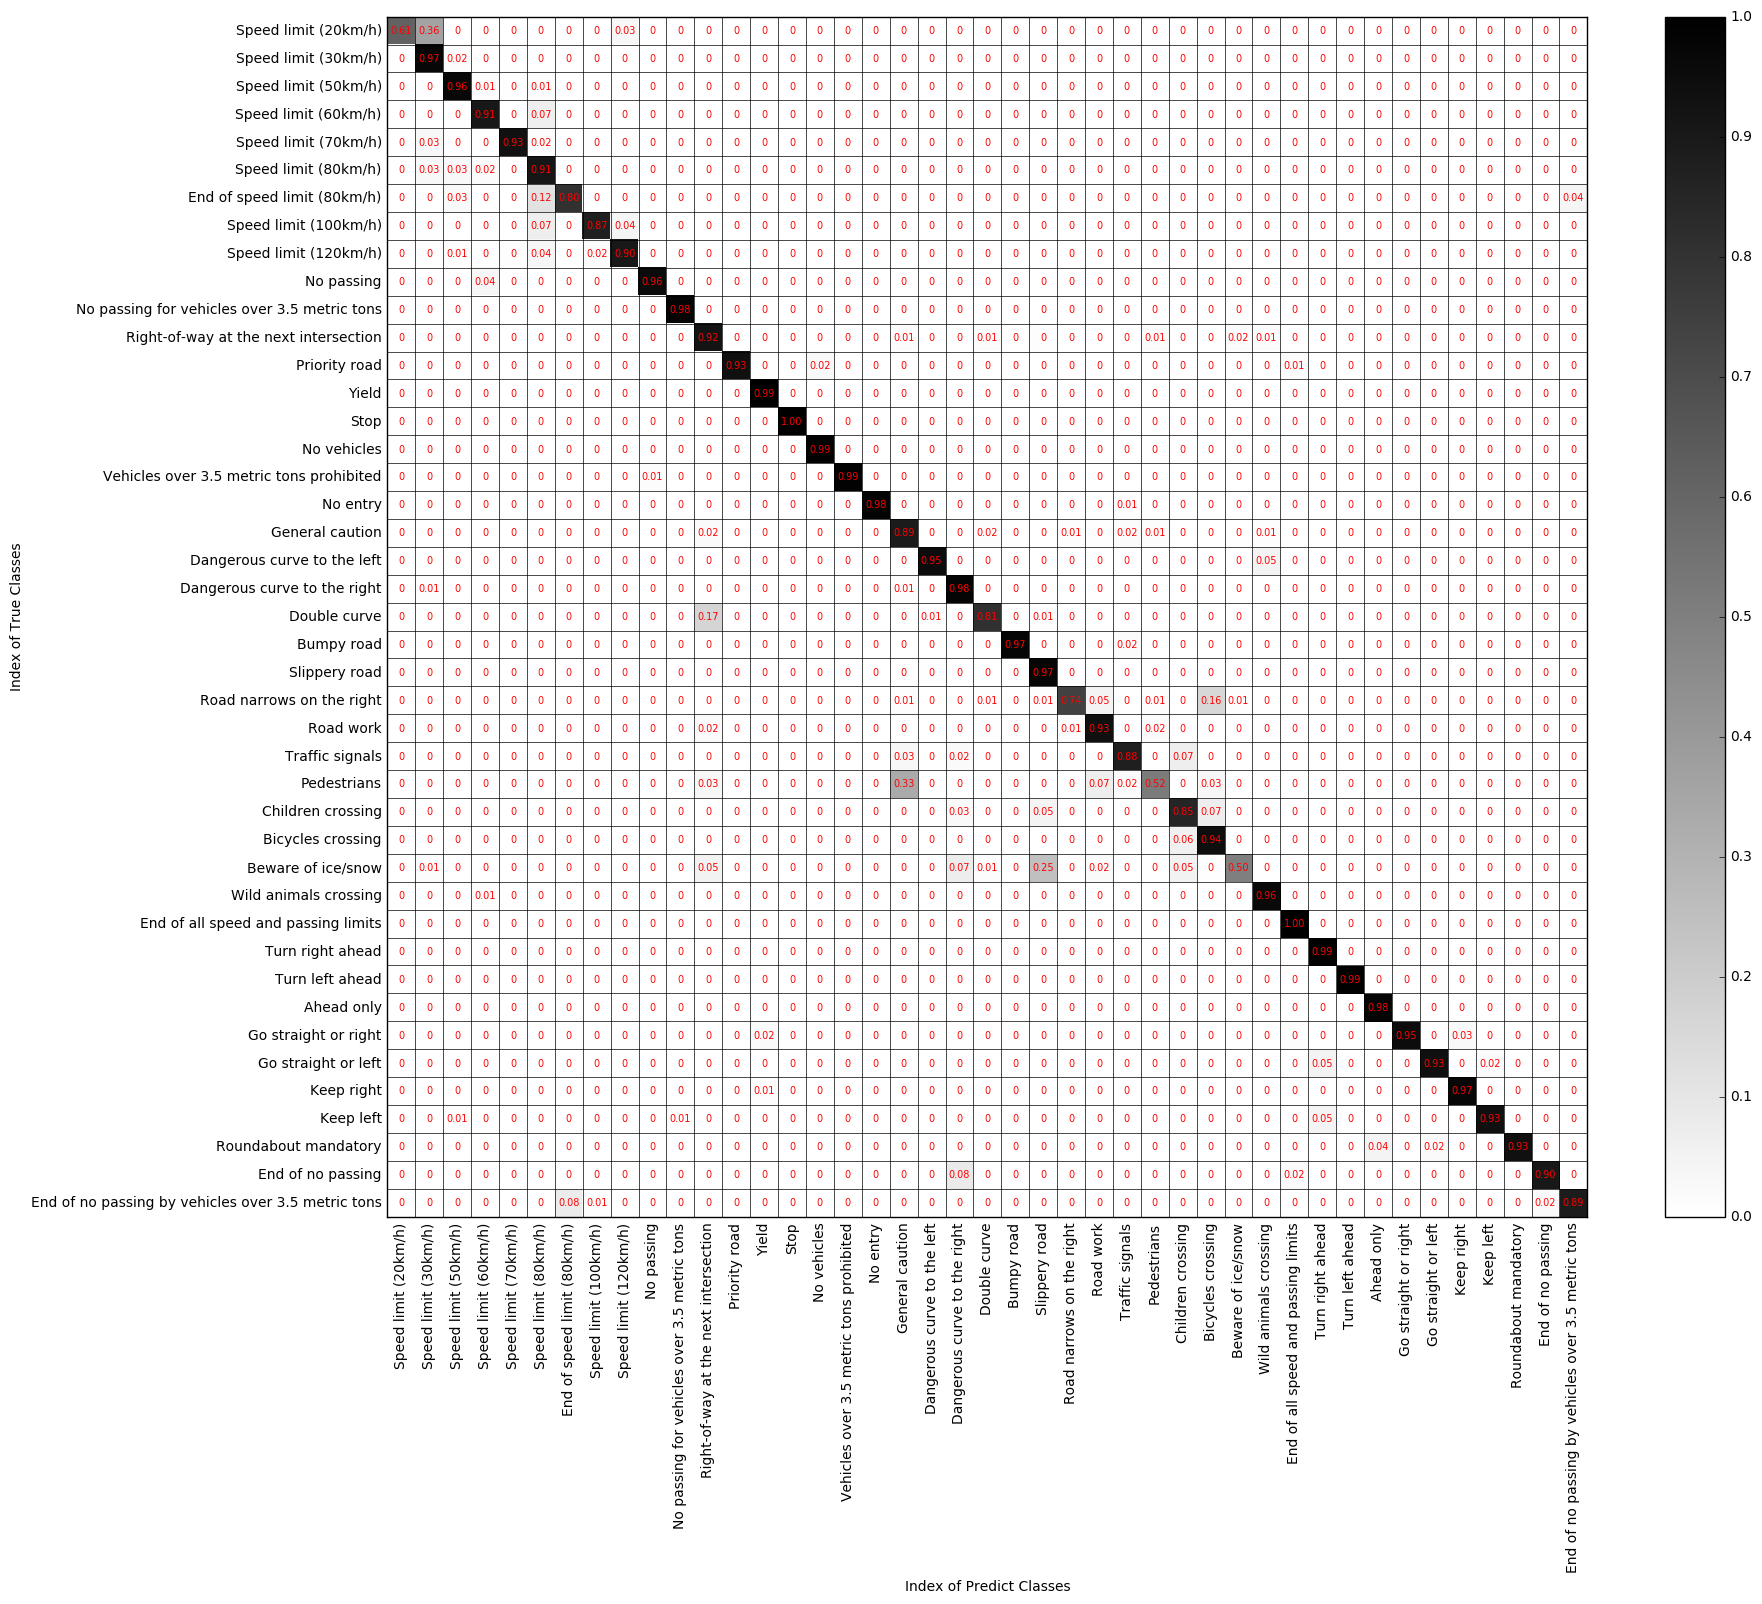

In [5]:
def test_basic_lenet_inception_augmented_data():
    """
    The basic one lenet
    GrayScale Images
    DropOut: NO
    """
    provider = rotated_data_provider
#     provider = grayscale(provider)
    lenet = NetInception(TrafficDataSets(provider),
                  name="original_grayscale_data",
                  epochs=100, batch_size=128, variable_mean=0, variable_stddev=0.1,
                  learning_rate=0.0003,
                  drop_out_keep_prob=0.3)
    lenet.train()
    Image(filename=lenet.file_name) 
    Image(filename=lenet.file_name_confusion_matrix) 
    
test_basic_lenet_inception_augmented_data()

2017-01-08 00:25:07,920 - training data 31367
2017-01-08 00:25:10,732 - EPOCH 1 training loss = 4.114 accuracy = 0.147 Validation loss = 2.225 accuracy = 0.419
2017-01-08 00:25:13,756 - EPOCH 2 training loss = 1.890 accuracy = 0.481 Validation loss = 1.000 accuracy = 0.719
2017-01-08 00:25:16,545 - EPOCH 3 training loss = 1.094 accuracy = 0.682 Validation loss = 0.591 accuracy = 0.831
2017-01-08 00:25:19,476 - EPOCH 4 training loss = 0.765 accuracy = 0.778 Validation loss = 0.409 accuracy = 0.882
2017-01-08 00:25:22,488 - EPOCH 5 training loss = 0.585 accuracy = 0.830 Validation loss = 0.324 accuracy = 0.906
2017-01-08 00:25:25,404 - EPOCH 6 training loss = 0.468 accuracy = 0.860 Validation loss = 0.271 accuracy = 0.930
2017-01-08 00:25:28,361 - EPOCH 7 training loss = 0.386 accuracy = 0.886 Validation loss = 0.238 accuracy = 0.936
2017-01-08 00:25:31,195 - EPOCH 8 training loss = 0.333 accuracy = 0.900 Validation loss = 0.217 accuracy = 0.943
2017-01-08 00:25:34,034 - EPOCH 9 training

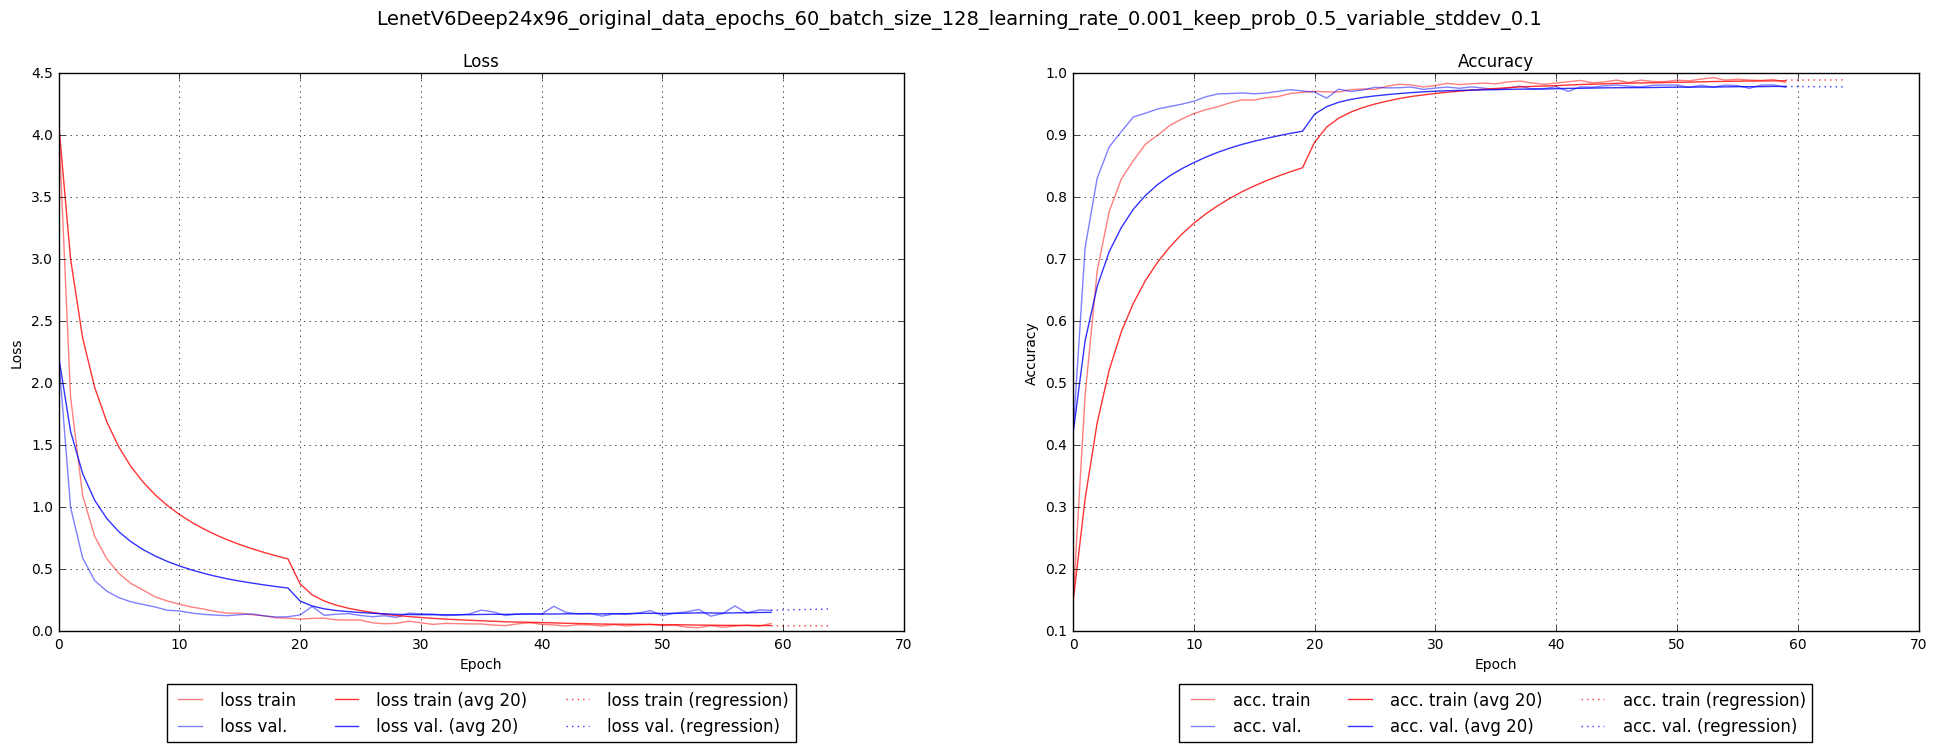

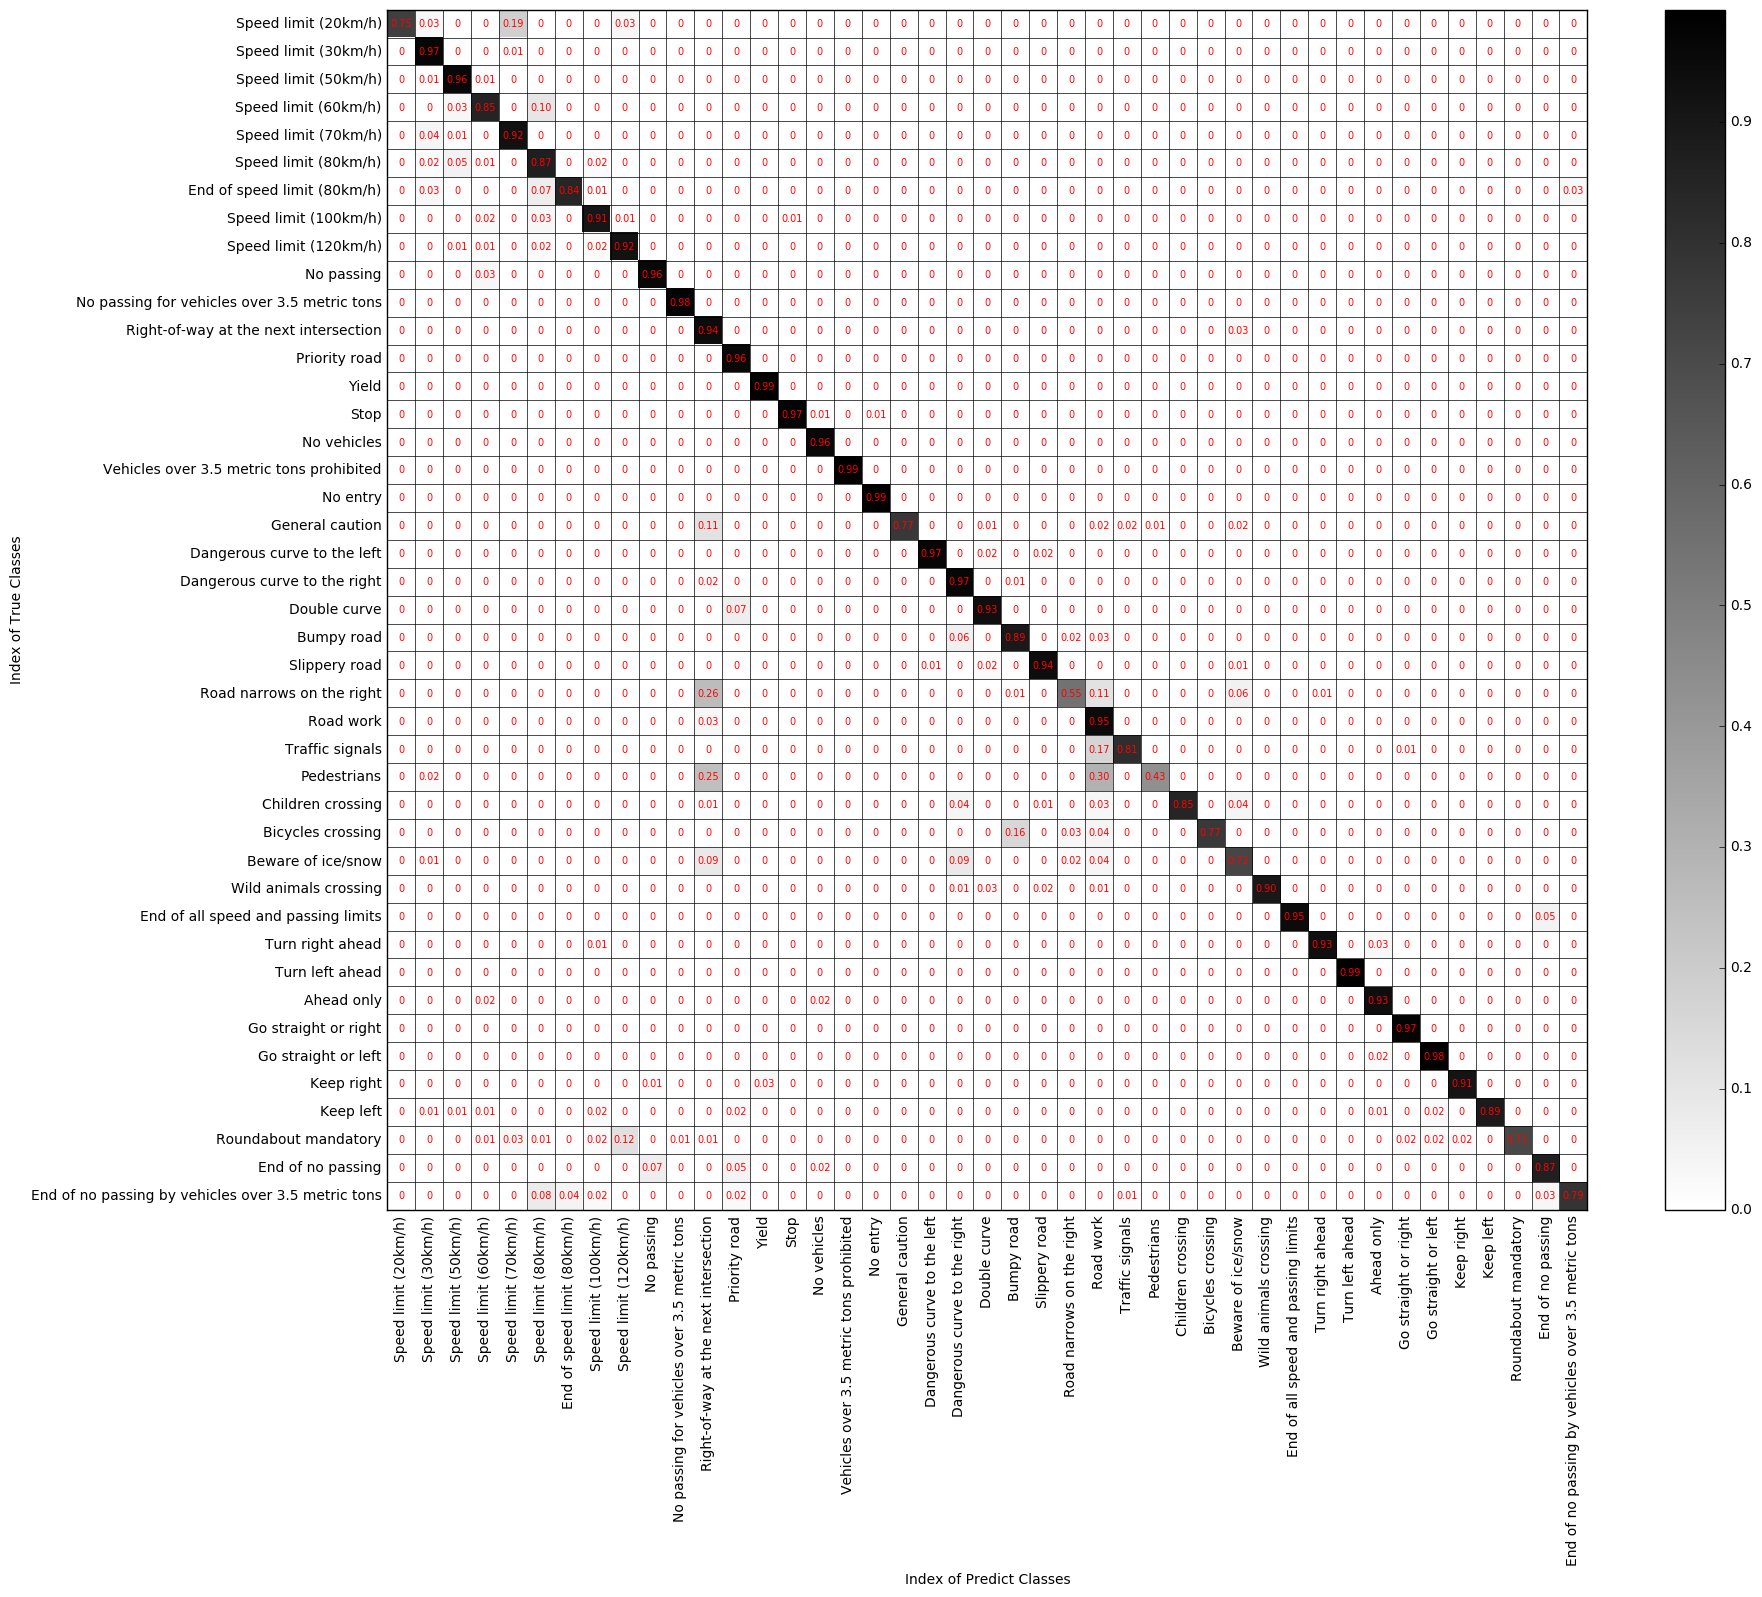

In [3]:
def test_lenet_v6():
    provider = original_data_provider
    lenet = LenetV6Deep24x96(TrafficDataSets(provider),
                  name="original_data",
                  epochs=60, batch_size=128, variable_mean=0, variable_stddev=0.1,
                  learning_rate=0.001,
                  drop_out_keep_prob=0.5)
    lenet.train()
    Image(filename=lenet.file_name) 
    Image(filename=lenet.file_name_confusion_matrix) 
    Image(filename=lenet.file_name_wrong_predicts)
    
test_lenet_v6()

2017-01-08 04:07:39,172 - training data 31367
2017-01-08 04:07:42,331 - EPOCH 1 training loss = 1.977 accuracy = 0.453 Validation loss = 0.583 accuracy = 0.835
2017-01-08 04:07:45,366 - EPOCH 2 training loss = 0.642 accuracy = 0.799 Validation loss = 0.252 accuracy = 0.933
2017-01-08 04:07:48,255 - EPOCH 3 training loss = 0.383 accuracy = 0.880 Validation loss = 0.184 accuracy = 0.950
2017-01-08 04:07:51,343 - EPOCH 4 training loss = 0.275 accuracy = 0.917 Validation loss = 0.125 accuracy = 0.967
2017-01-08 04:07:54,371 - EPOCH 5 training loss = 0.217 accuracy = 0.934 Validation loss = 0.106 accuracy = 0.972
2017-01-08 04:07:57,389 - EPOCH 6 training loss = 0.170 accuracy = 0.948 Validation loss = 0.094 accuracy = 0.978
2017-01-08 04:08:00,519 - EPOCH 7 training loss = 0.142 accuracy = 0.956 Validation loss = 0.090 accuracy = 0.975
2017-01-08 04:08:03,467 - EPOCH 8 training loss = 0.126 accuracy = 0.960 Validation loss = 0.093 accuracy = 0.977
2017-01-08 04:08:06,594 - EPOCH 9 training

TypeError: Cannot handle this data type

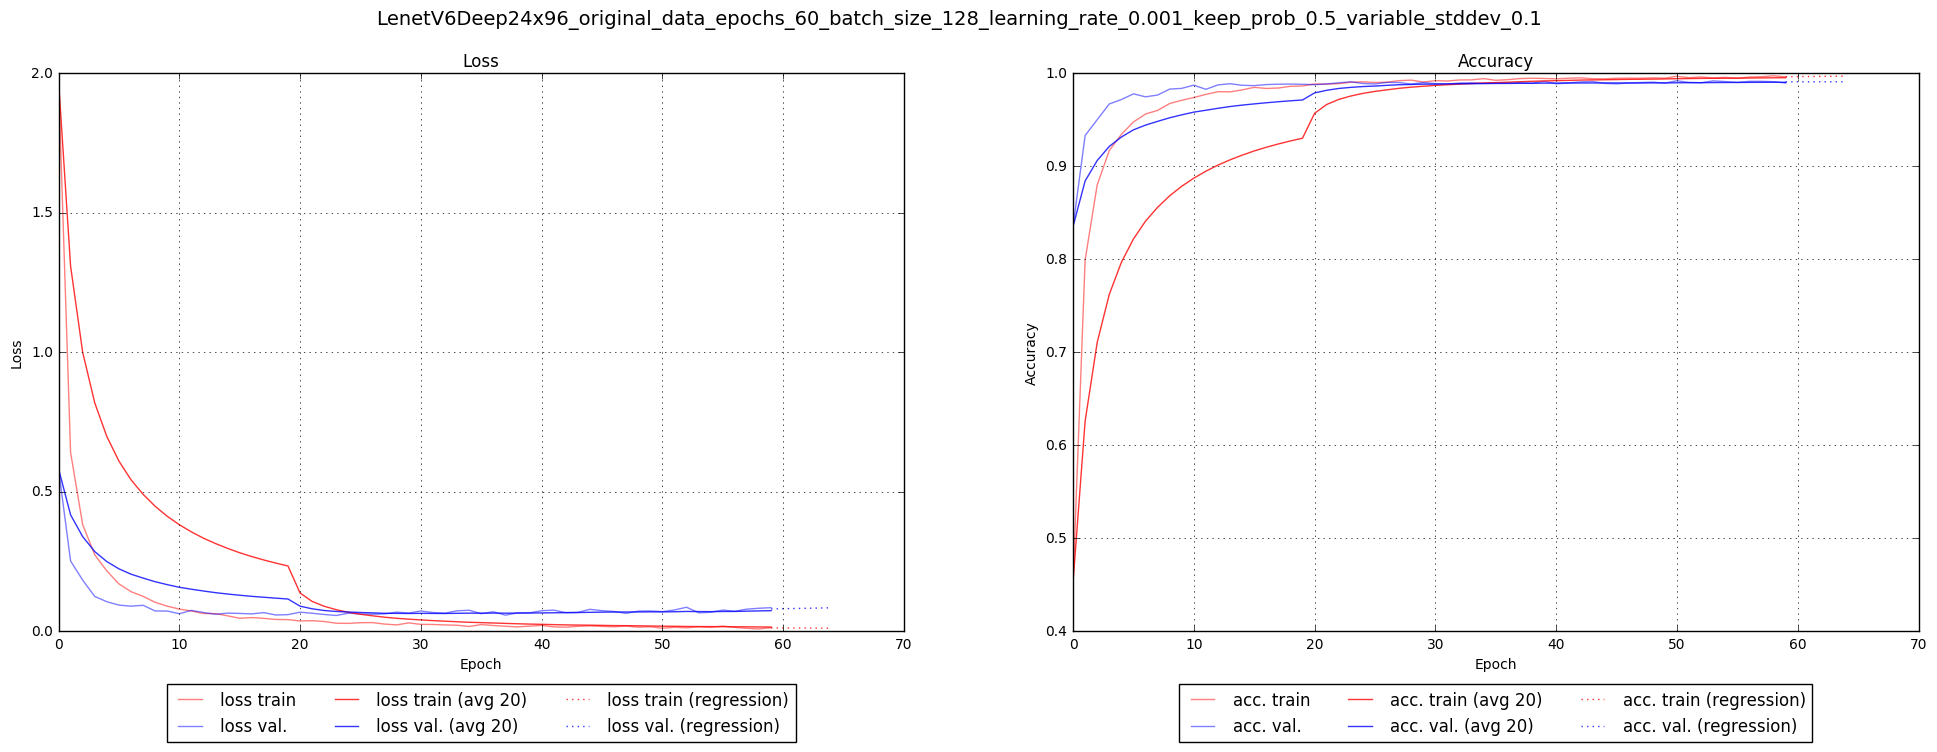

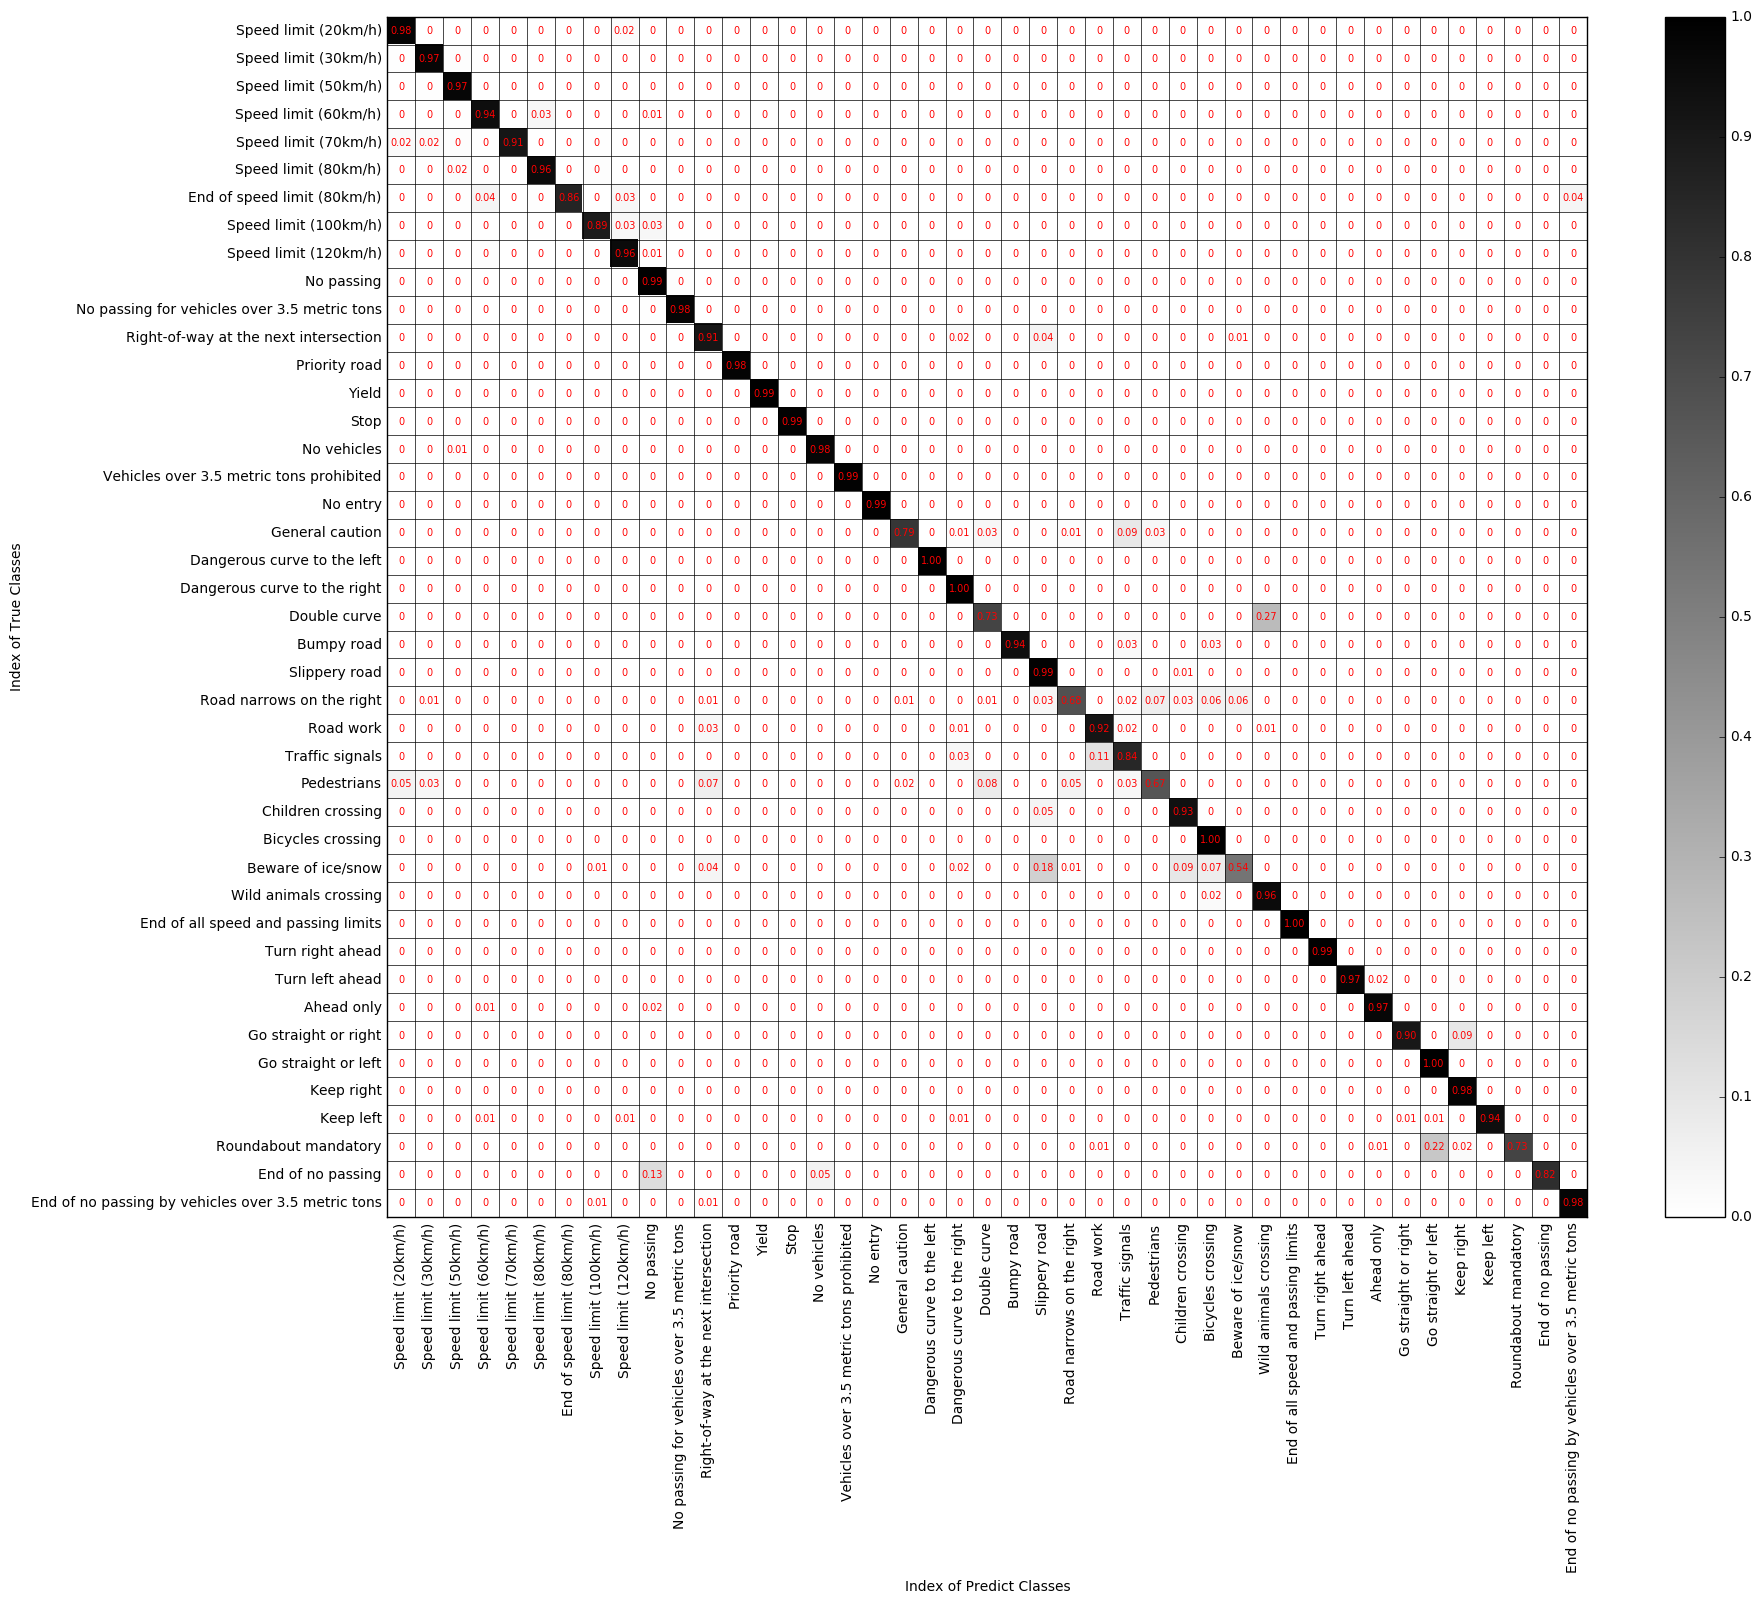

In [2]:
def test_lenet_v6_whitning():
    provider = original_data_provider
    provider = normalise_image_whitening(provider)
    lenet = LenetV6Deep24x96(TrafficDataSets(provider),
                  name="original_data",
                  epochs=60, batch_size=128, variable_mean=0, variable_stddev=0.1,
                  learning_rate=0.001,
                  drop_out_keep_prob=0.5)
    lenet.train()
    Image(filename=lenet.file_name) 
    Image(filename=lenet.file_name_confusion_matrix) 
    Image(filename=lenet.file_name_wrong_predicts)
    
test_lenet_v6_whitning()

2017-01-08 02:16:46,151 - training data 75612
2017-01-08 02:16:51,964 - EPOCH 1 training loss = 3.858 accuracy = 0.141 Validation loss = 3.773 accuracy = 0.028
2017-01-08 02:16:57,104 - EPOCH 2 training loss = 3.644 accuracy = 0.058 Validation loss = 2.508 accuracy = 0.291
2017-01-08 02:17:02,095 - EPOCH 3 training loss = 1.355 accuracy = 0.599 Validation loss = 0.657 accuracy = 0.806
2017-01-08 02:17:07,130 - EPOCH 4 training loss = 0.652 accuracy = 0.803 Validation loss = 0.407 accuracy = 0.884
2017-01-08 02:17:12,195 - EPOCH 5 training loss = 0.428 accuracy = 0.871 Validation loss = 0.297 accuracy = 0.908
2017-01-08 02:17:17,271 - EPOCH 6 training loss = 0.318 accuracy = 0.905 Validation loss = 0.227 accuracy = 0.936
2017-01-08 02:17:22,329 - EPOCH 7 training loss = 0.255 accuracy = 0.924 Validation loss = 0.219 accuracy = 0.940
2017-01-08 02:17:27,421 - EPOCH 8 training loss = 0.196 accuracy = 0.941 Validation loss = 0.220 accuracy = 0.939
2017-01-08 02:17:32,480 - EPOCH 9 training

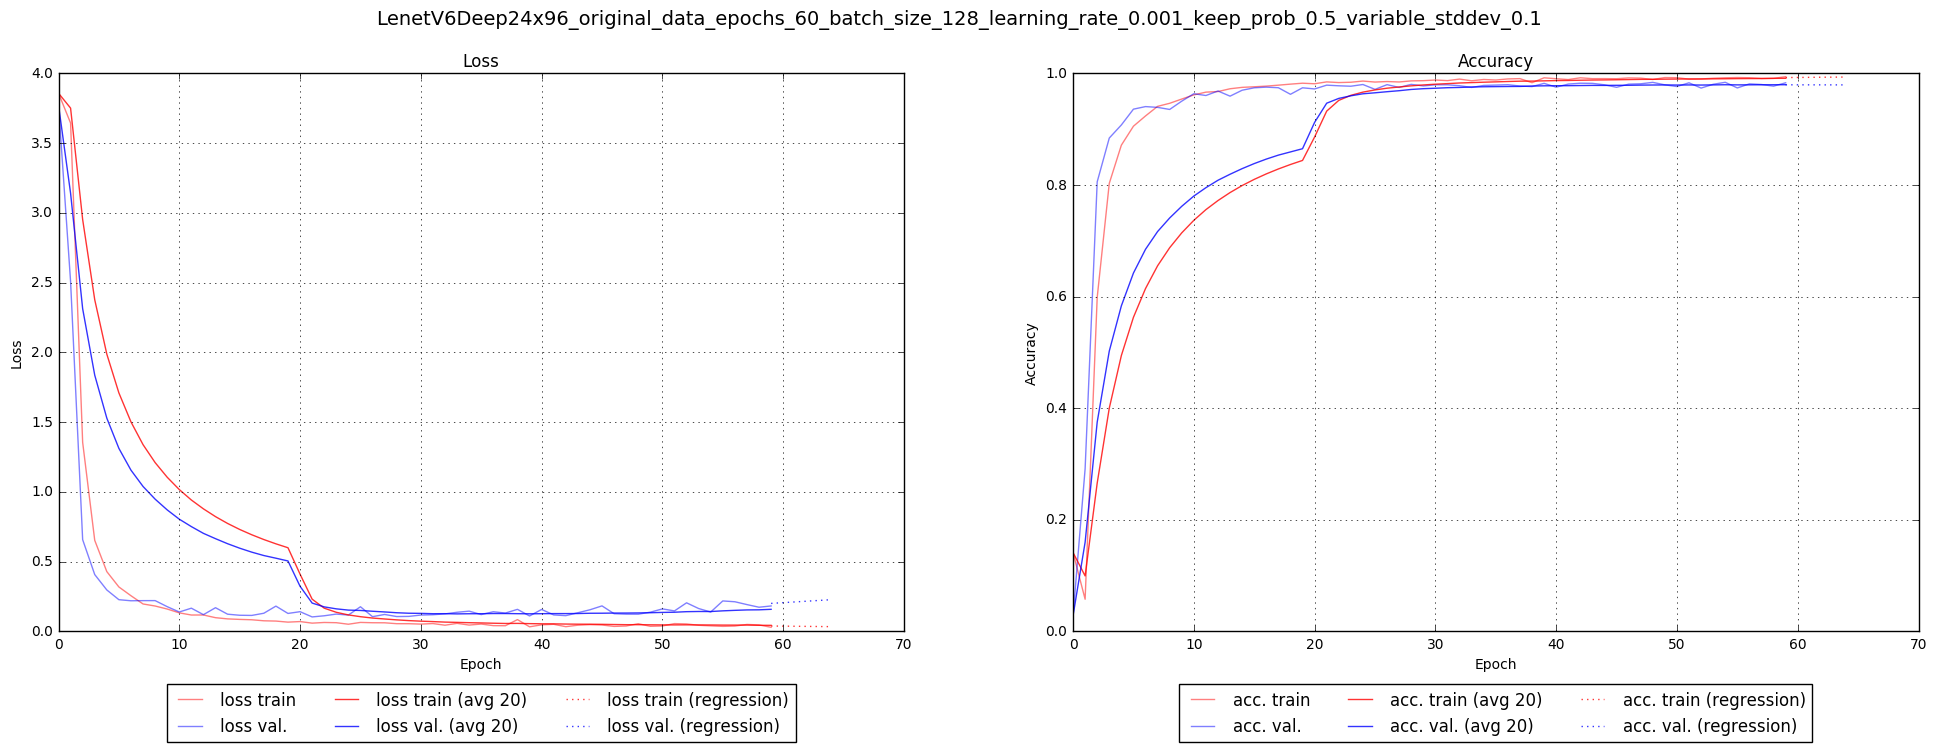

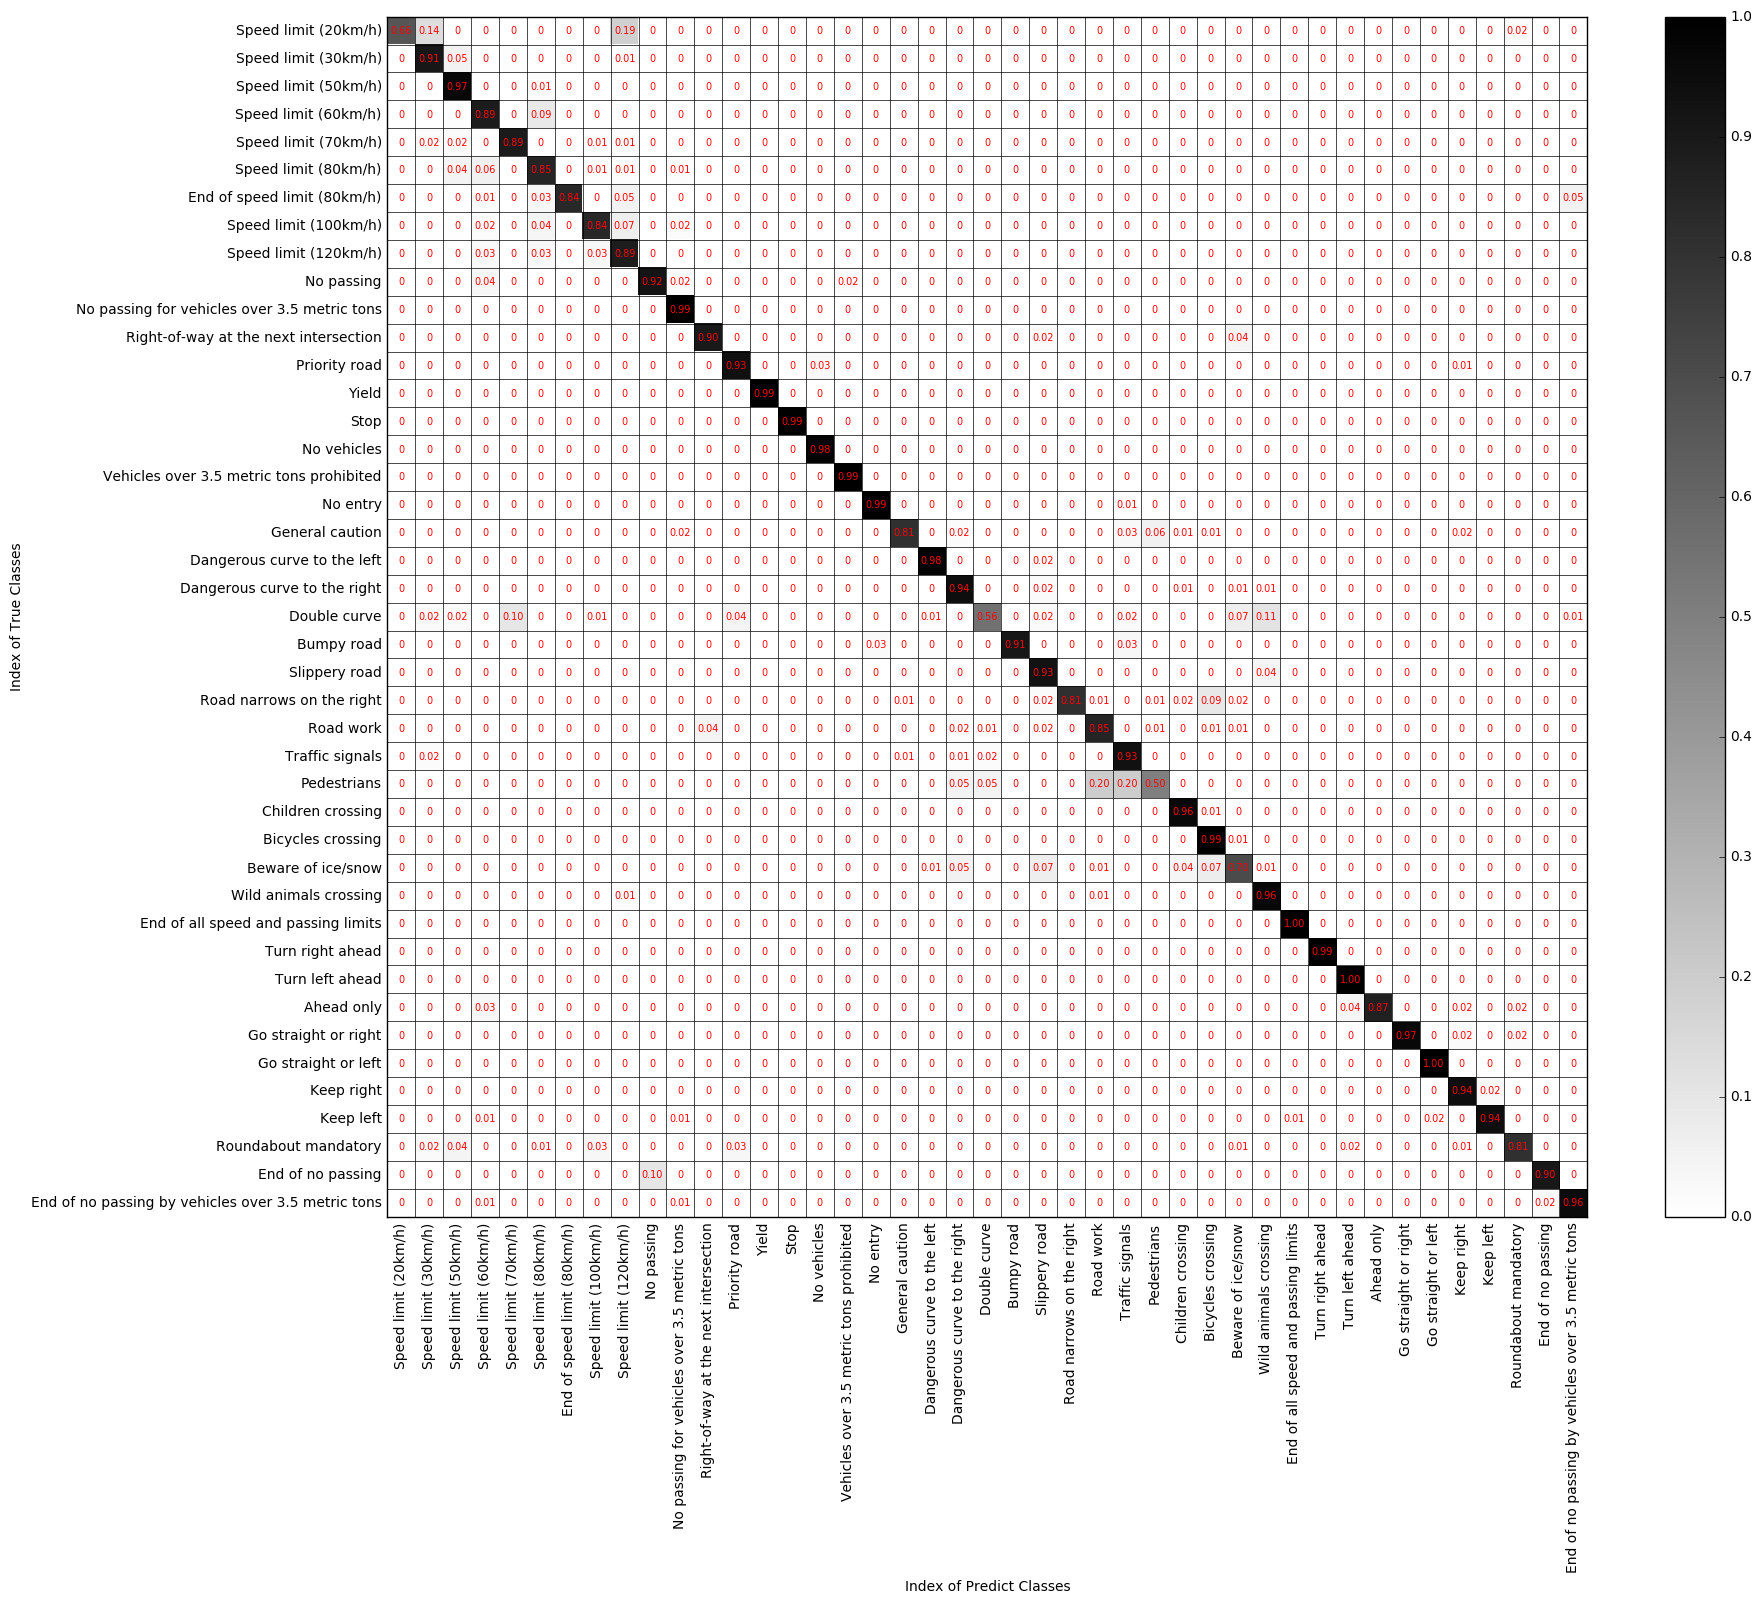

In [6]:
def test_lenet_v6_rotated():
    provider = rotated_data_provider
    lenet = LenetV6Deep24x96(TrafficDataSets(provider),
                  name="original_data",
                  epochs=60, batch_size=128, variable_mean=0, variable_stddev=0.1,
                  learning_rate=0.001,
                  drop_out_keep_prob=0.5)
    lenet.train()
    Image(filename=lenet.file_name) 
    Image(filename=lenet.file_name_confusion_matrix) 
    Image(filename=lenet.file_name_wrong_predicts)
    
test_lenet_v6_rotated()

2017-01-08 02:53:27,978 - training data 31367
2017-01-08 02:53:30,843 - EPOCH 1 training loss = 4.896 accuracy = 0.068 Validation loss = 3.341 accuracy = 0.177
2017-01-08 02:53:33,908 - EPOCH 2 training loss = 3.256 accuracy = 0.150 Validation loss = 2.647 accuracy = 0.309
2017-01-08 02:53:36,946 - EPOCH 3 training loss = 2.731 accuracy = 0.255 Validation loss = 1.966 accuracy = 0.457
2017-01-08 02:53:39,788 - EPOCH 4 training loss = 2.256 accuracy = 0.347 Validation loss = 1.555 accuracy = 0.530
2017-01-08 02:53:42,803 - EPOCH 5 training loss = 1.937 accuracy = 0.414 Validation loss = 1.297 accuracy = 0.574
2017-01-08 02:53:45,639 - EPOCH 6 training loss = 1.709 accuracy = 0.465 Validation loss = 1.132 accuracy = 0.645
2017-01-08 02:53:48,667 - EPOCH 7 training loss = 1.507 accuracy = 0.521 Validation loss = 0.909 accuracy = 0.717
2017-01-08 02:53:51,645 - EPOCH 8 training loss = 1.329 accuracy = 0.569 Validation loss = 0.783 accuracy = 0.751
2017-01-08 02:53:54,586 - EPOCH 9 training

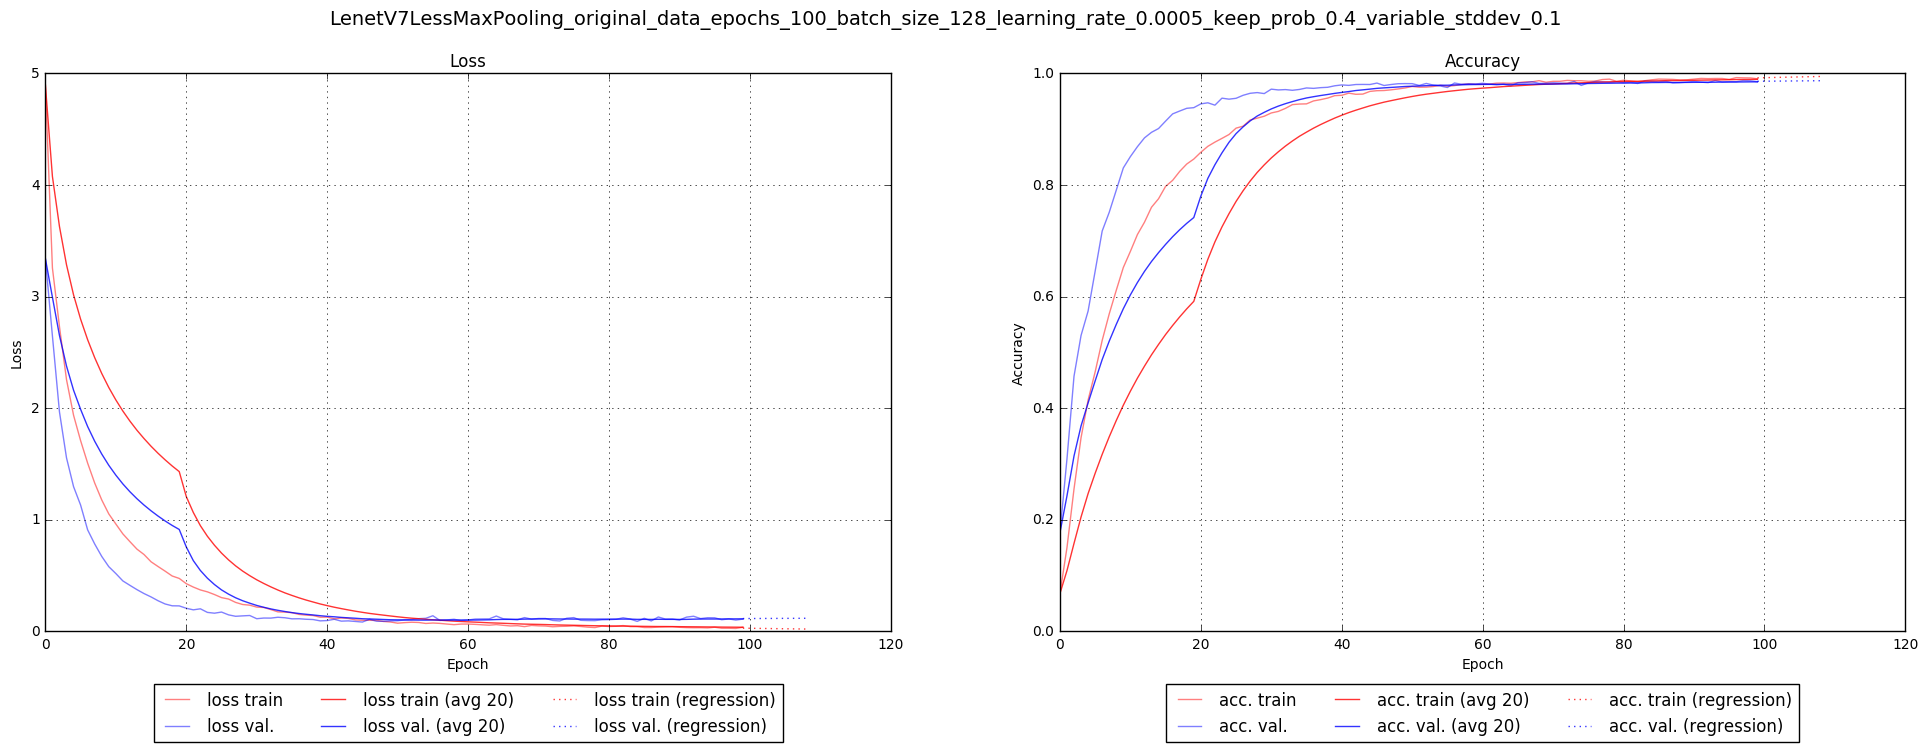

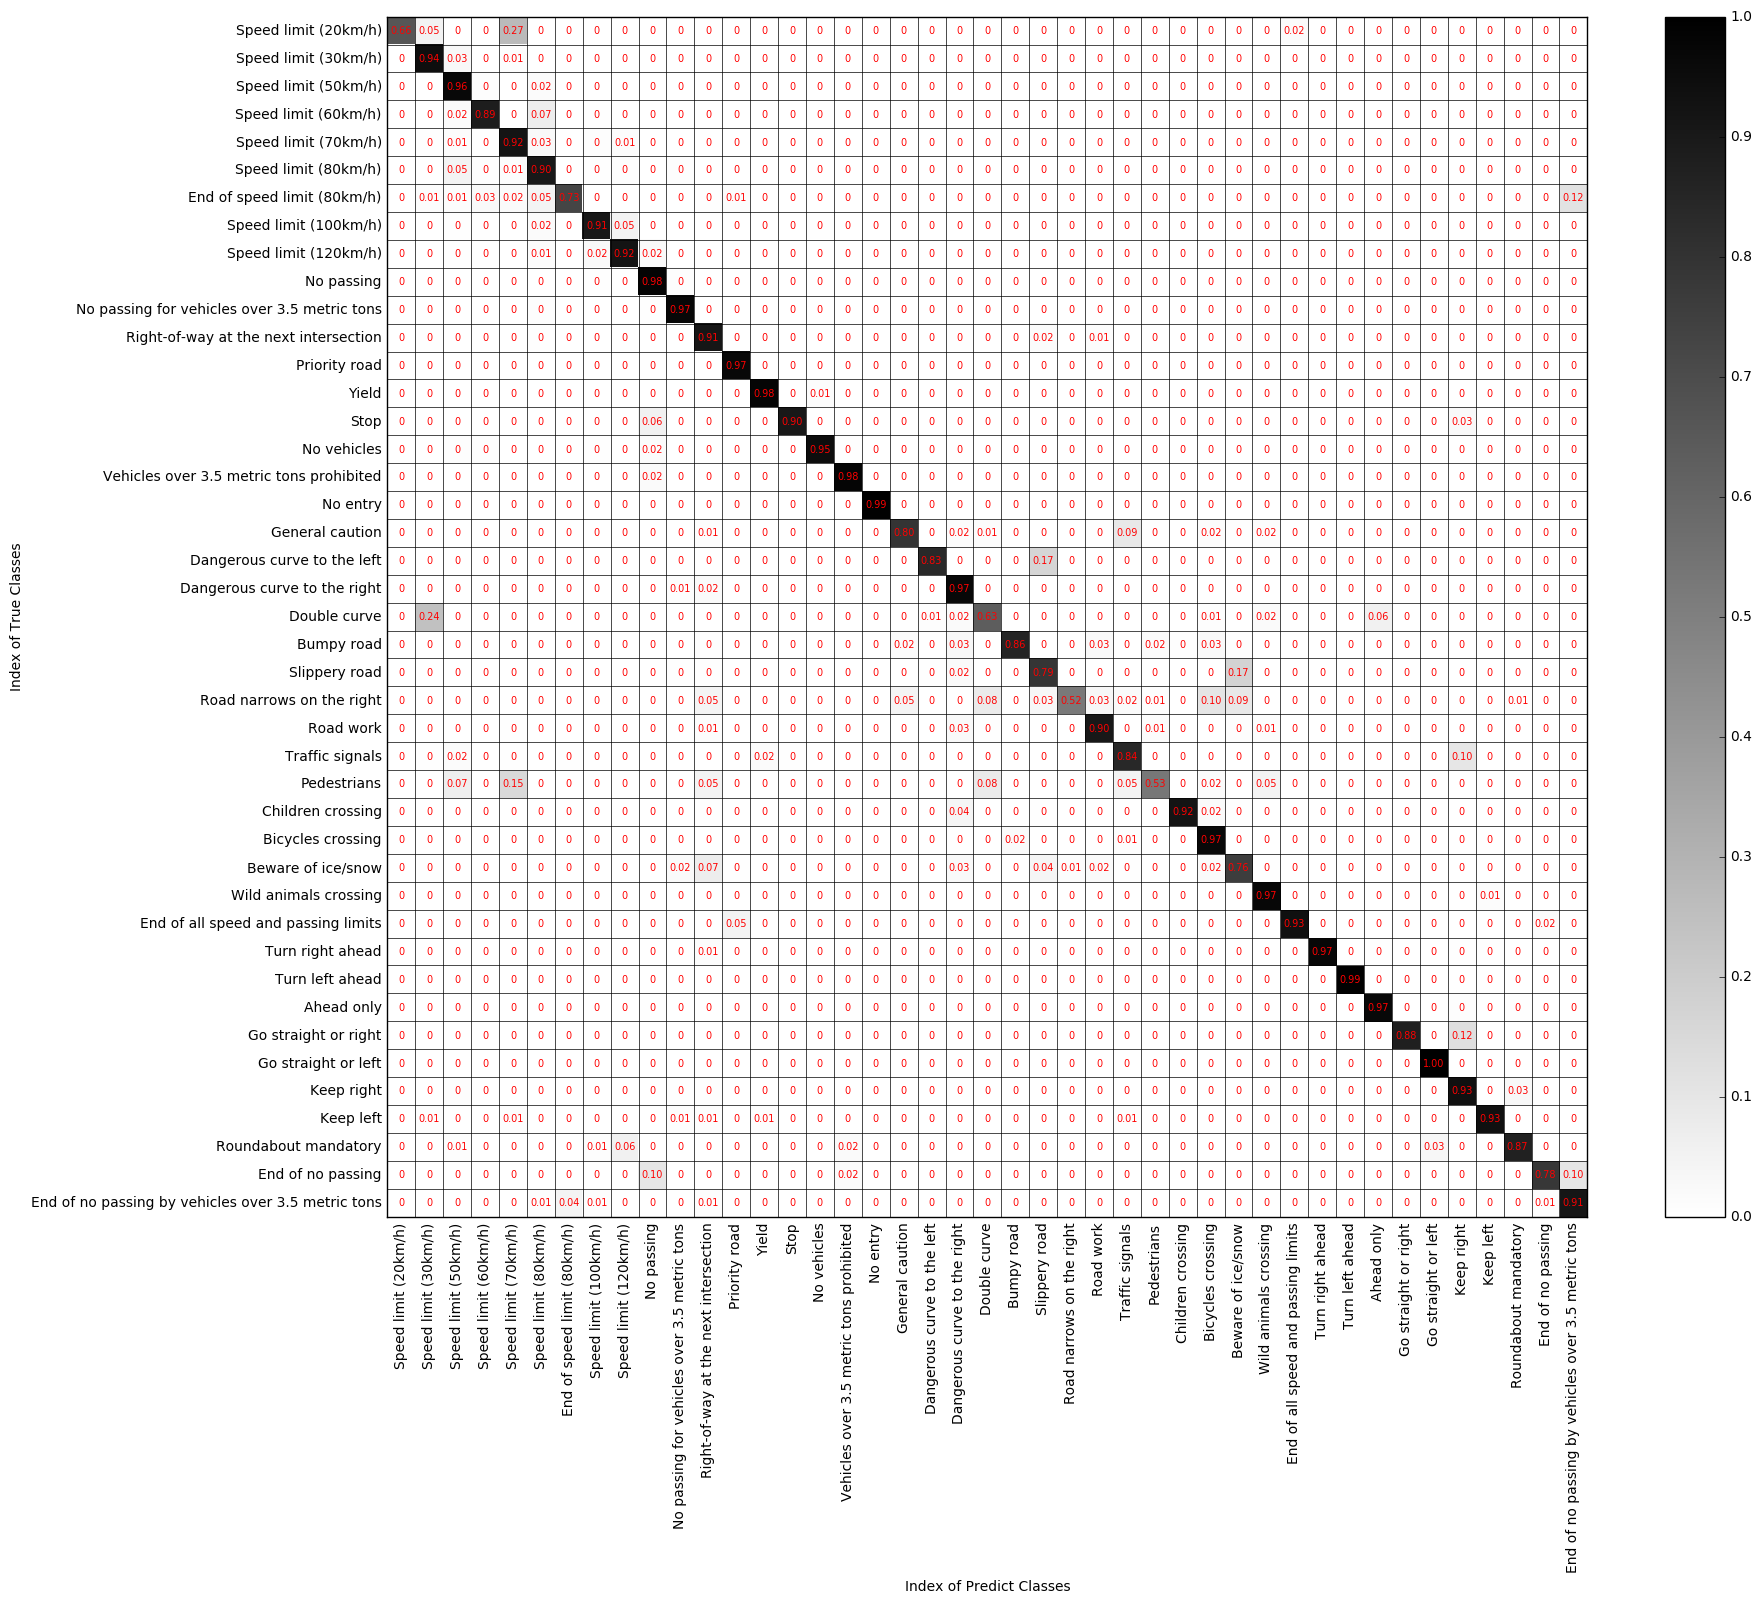

In [3]:
def test_lenet_LenetV7LessMaxPooling():
    provider = original_data_provider
    lenet = LenetV7LessMaxPooling(TrafficDataSets(provider),
                  name="original_data",
                  epochs=100, batch_size=128, variable_mean=0, variable_stddev=0.1,
                  learning_rate=0.0005,
                  drop_out_keep_prob=0.4)
    lenet.train()
    Image(filename=lenet.file_name) 
    Image(filename=lenet.file_name_confusion_matrix) 
    Image(filename=lenet.file_name_wrong_predicts)
    
test_lenet_LenetV7LessMaxPooling()

2017-01-08 04:50:29,988 - training data 31367
2017-01-08 04:50:33,066 - EPOCH 1 training loss = 4.560 accuracy = 0.158 Validation loss = 2.181 accuracy = 0.417
2017-01-08 04:50:35,949 - EPOCH 2 training loss = 2.218 accuracy = 0.376 Validation loss = 1.391 accuracy = 0.594
2017-01-08 04:50:38,876 - EPOCH 3 training loss = 1.661 accuracy = 0.502 Validation loss = 0.995 accuracy = 0.703
2017-01-08 04:50:41,763 - EPOCH 4 training loss = 1.304 accuracy = 0.601 Validation loss = 0.694 accuracy = 0.794
2017-01-08 04:50:44,756 - EPOCH 5 training loss = 1.031 accuracy = 0.676 Validation loss = 0.527 accuracy = 0.852
2017-01-08 04:50:47,794 - EPOCH 6 training loss = 0.851 accuracy = 0.732 Validation loss = 0.434 accuracy = 0.874
2017-01-08 04:50:50,782 - EPOCH 7 training loss = 0.735 accuracy = 0.772 Validation loss = 0.355 accuracy = 0.905
2017-01-08 04:50:53,621 - EPOCH 8 training loss = 0.625 accuracy = 0.805 Validation loss = 0.307 accuracy = 0.914
2017-01-08 04:50:56,591 - EPOCH 9 training

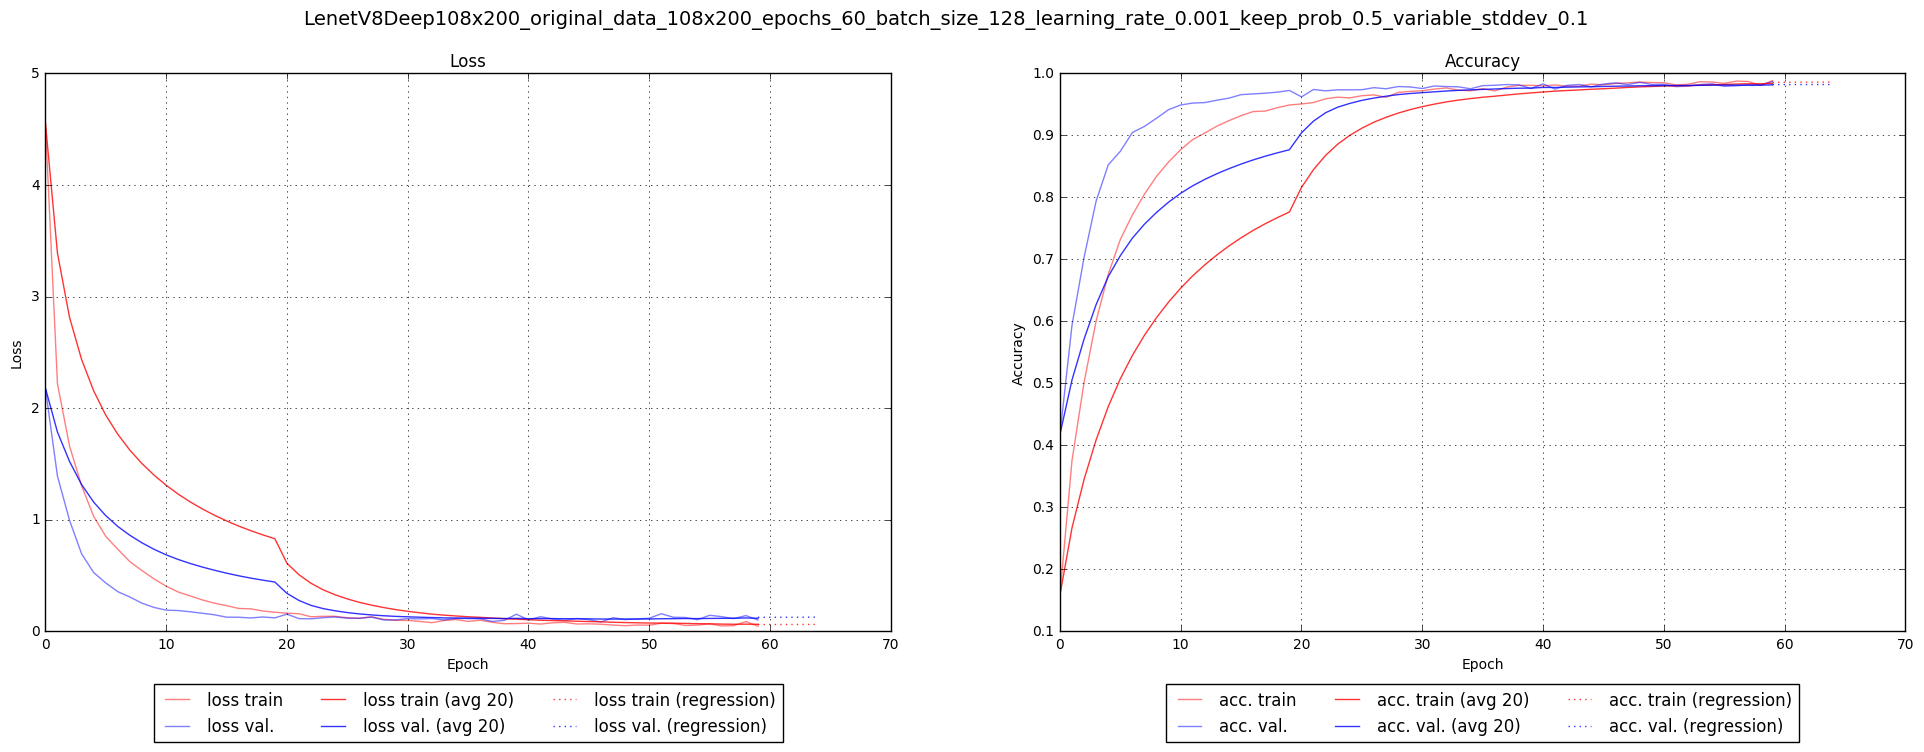

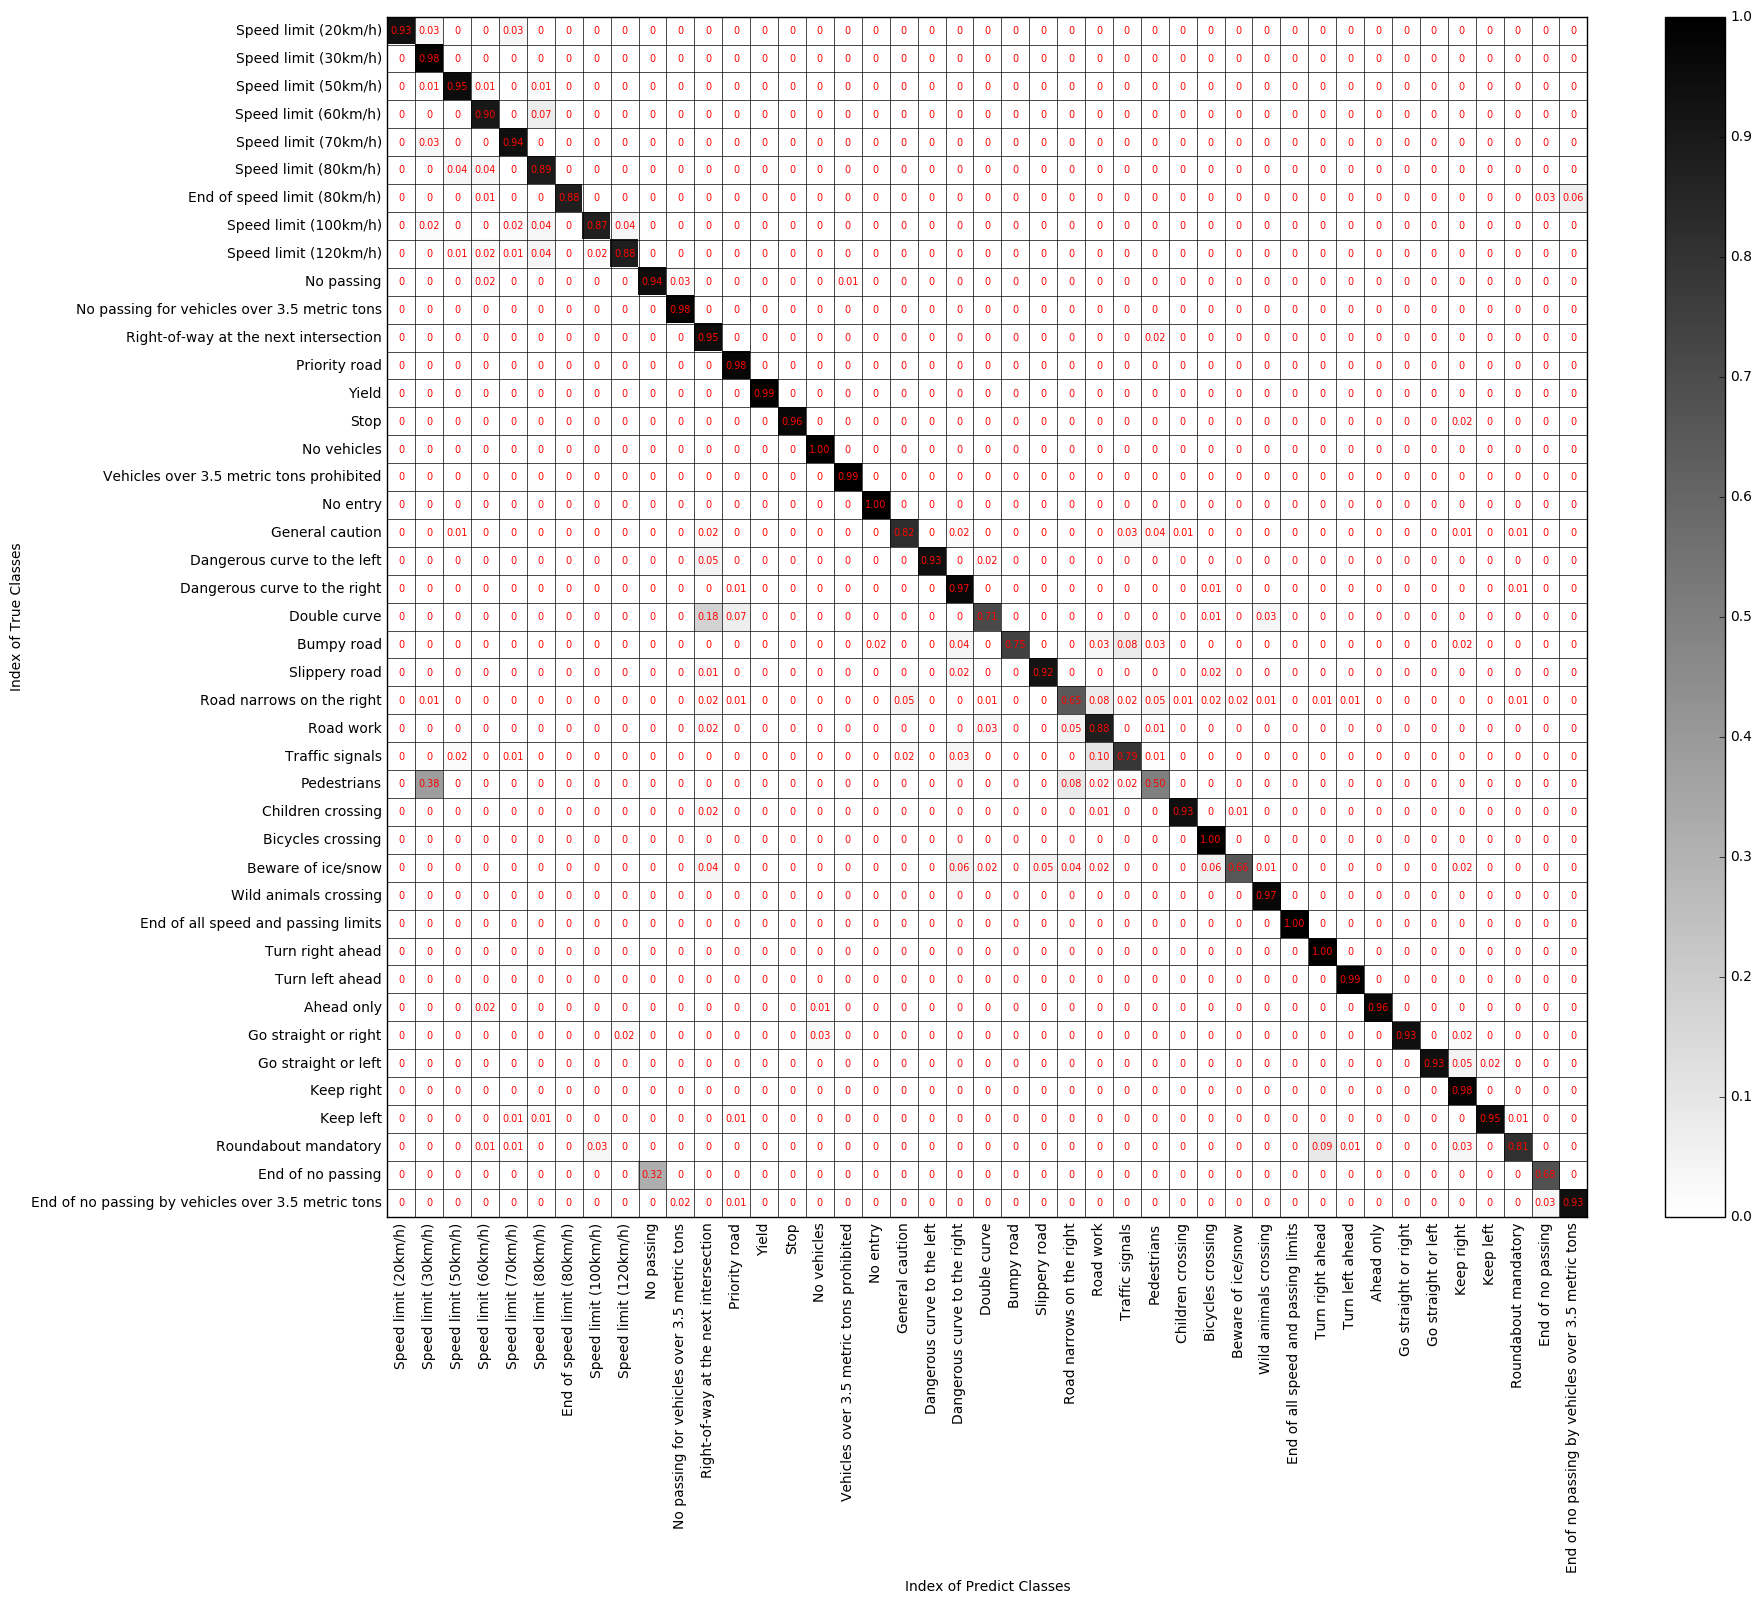

In [3]:
def test_lenet_v8_108x200():
    provider = original_data_provider
#     provider = normalise_image_whitening(provider)
    lenet = LenetV8Deep108x200(TrafficDataSets(provider),
                  name="original_data_108x200",
                  epochs=60, batch_size=128, variable_mean=0, variable_stddev=0.1,
                  learning_rate=0.001,
                  drop_out_keep_prob=0.5)
    lenet.train()
    Image(filename=lenet.file_name) 
    Image(filename=lenet.file_name_confusion_matrix) 
    Image(filename=lenet.file_name_wrong_predicts)
    
test_lenet_v8_108x200()

In [1]:
def test_lenet_v8_108x200_whitning():
    # 0.949
    provider = original_data_provider
    provider = normalise_image_whitening(provider)
    lenet = LenetV8Deep108x200(TrafficDataSets(provider),
                  name="original_data_108x200",
                  epochs=80, batch_size=128, variable_mean=0, variable_stddev=0.1,
                  learning_rate=0.001,
                  drop_out_keep_prob=0.5)
    lenet.train()
    Image(filename=lenet.file_name) 
    Image(filename=lenet.file_name_confusion_matrix) 
    Image(filename=lenet.file_name_wrong_predicts)
    
test_lenet_v8_108x200_whitning()

NameError: name 'original_data_provider' is not defined

2017-01-08 10:31:30,660 - training data 31367
2017-01-08 10:31:50,664 - EPOCH 1 training loss = 3.595 accuracy = 0.077 Validation loss = 3.106 accuracy = 0.272
2017-01-08 10:31:53,668 - EPOCH 2 training loss = 2.985 accuracy = 0.218 Validation loss = 2.295 accuracy = 0.433
2017-01-08 10:31:56,757 - EPOCH 3 training loss = 2.481 accuracy = 0.328 Validation loss = 1.841 accuracy = 0.525
2017-01-08 10:31:59,816 - EPOCH 4 training loss = 2.148 accuracy = 0.396 Validation loss = 1.538 accuracy = 0.585
2017-01-08 10:32:02,898 - EPOCH 5 training loss = 1.916 accuracy = 0.447 Validation loss = 1.319 accuracy = 0.646
2017-01-08 10:32:05,986 - EPOCH 6 training loss = 1.731 accuracy = 0.491 Validation loss = 1.134 accuracy = 0.693
2017-01-08 10:32:08,955 - EPOCH 7 training loss = 1.565 accuracy = 0.533 Validation loss = 0.997 accuracy = 0.741
2017-01-08 10:32:11,981 - EPOCH 8 training loss = 1.441 accuracy = 0.564 Validation loss = 0.900 accuracy = 0.777
2017-01-08 10:32:14,959 - EPOCH 9 training

TypeError: Cannot handle this data type

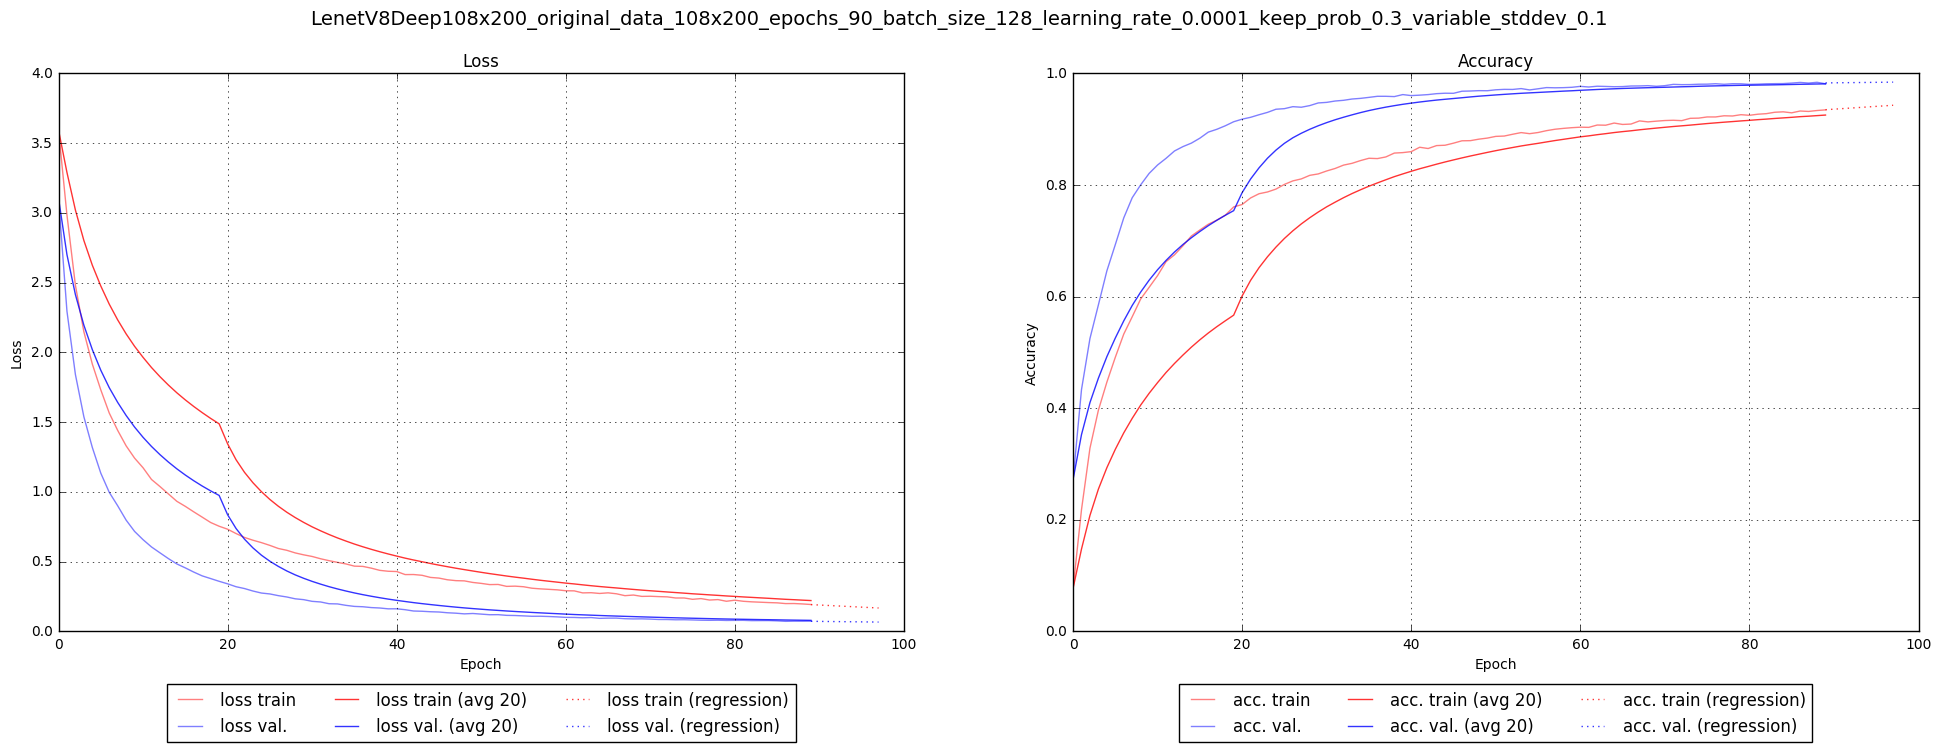

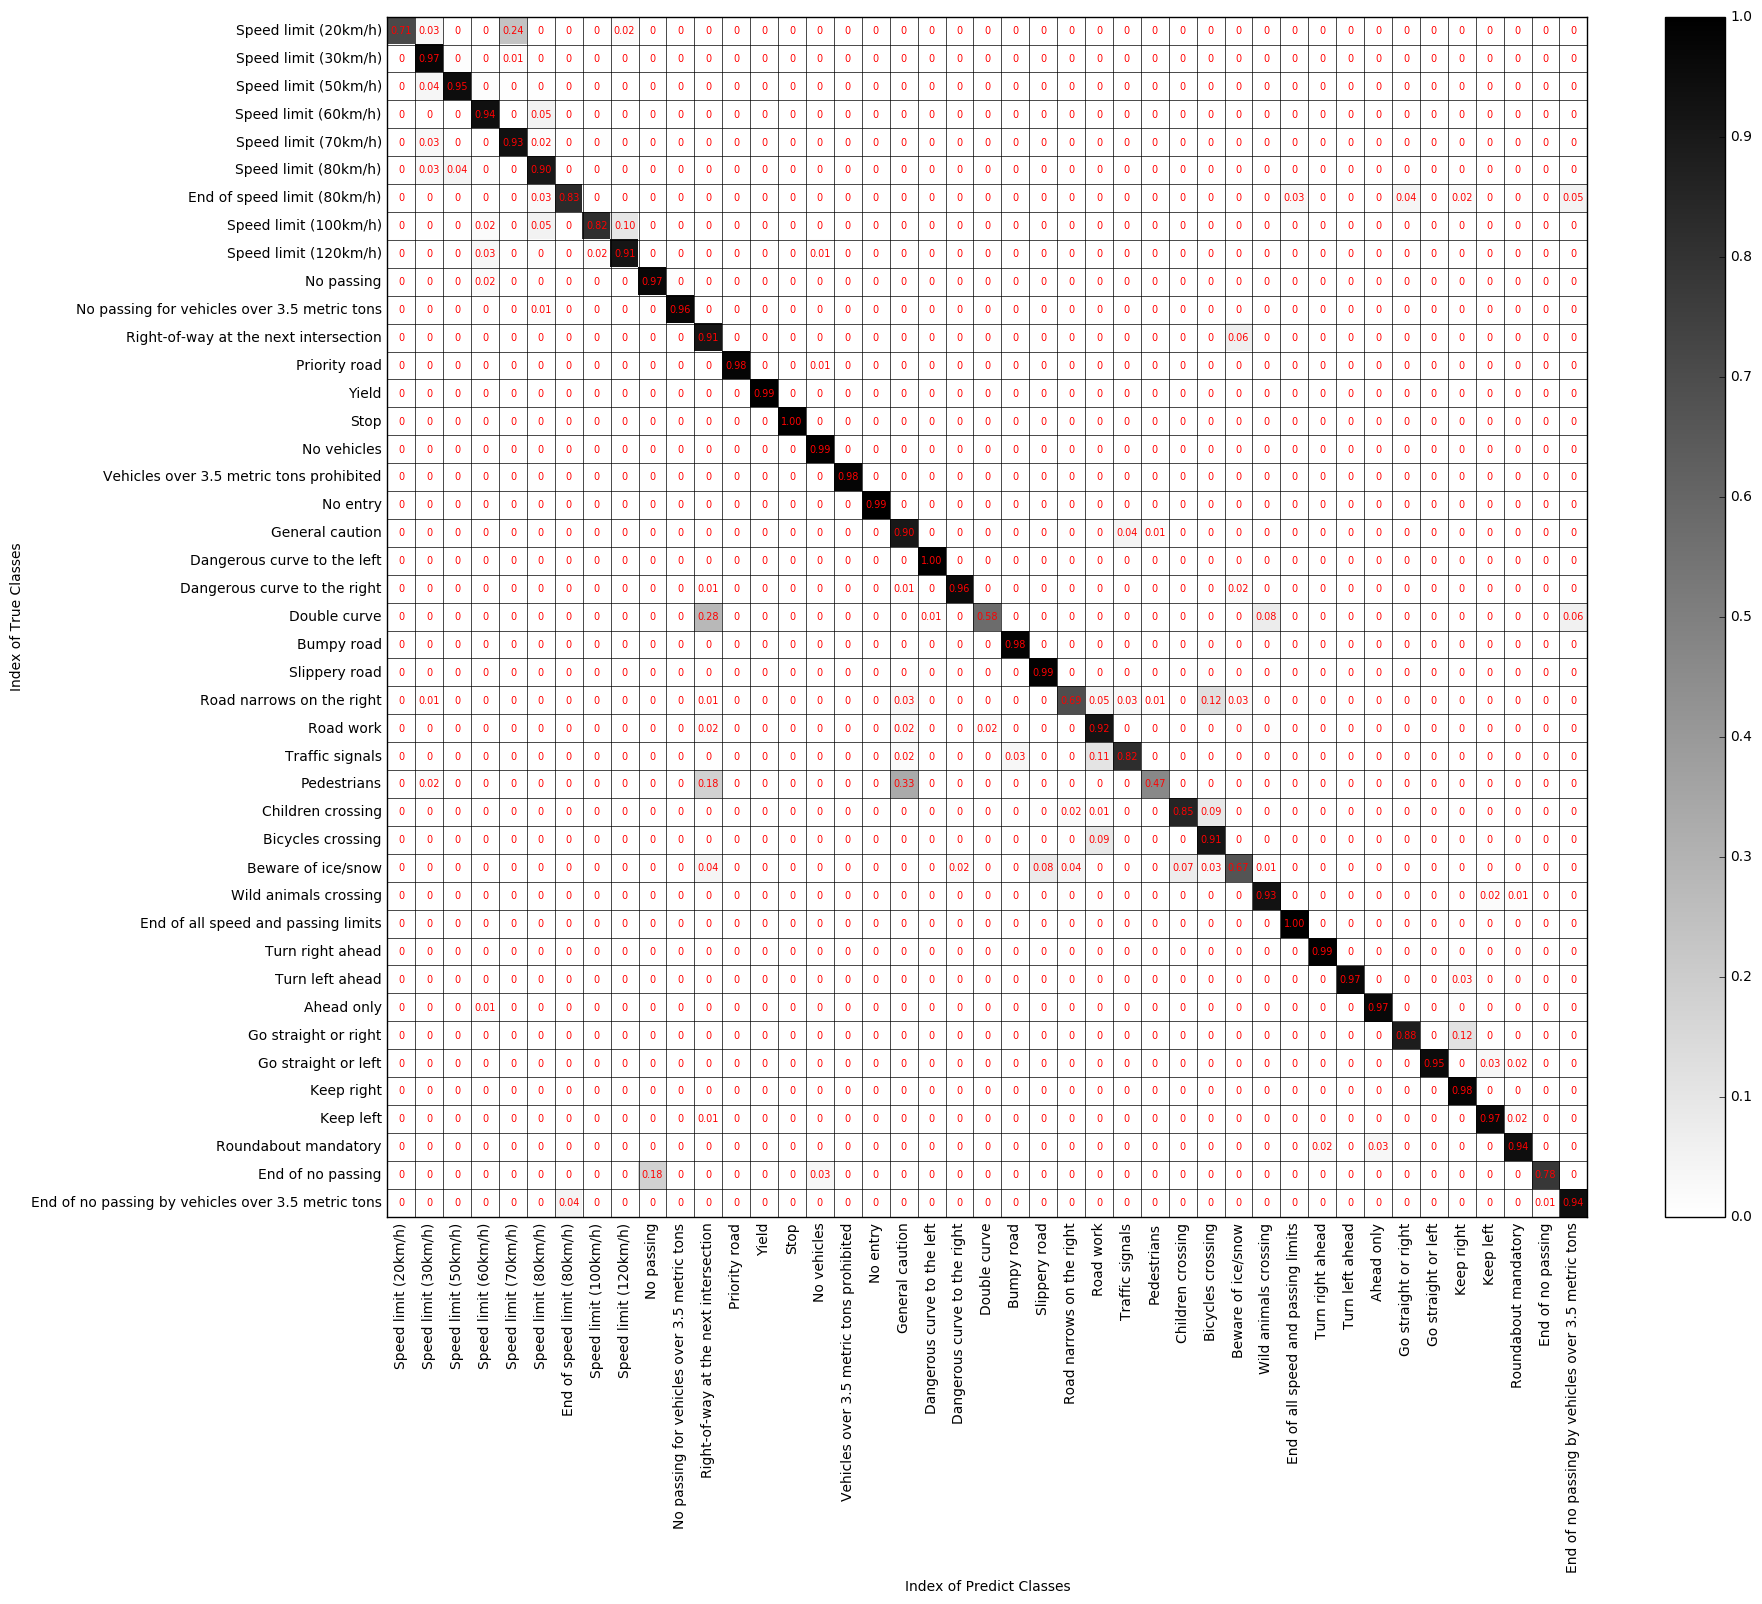

In [3]:
def test_lenet_v8_108x200_whitning_learning_rate():
    # 0.932
    provider = original_data_provider
    provider = normalise_image_whitening(provider)
    lenet = LenetV8Deep108x200(TrafficDataSets(provider),
                  name="original_data_108x200",
                  epochs=150, batch_size=128, variable_mean=0, variable_stddev=0.1,
                  learning_rate=0.0001,
                  drop_out_keep_prob=0.3)
    lenet.train()
    Image(filename=lenet.file_name) 
    Image(filename=lenet.file_name_confusion_matrix) 
    Image(filename=lenet.file_name_wrong_predicts)
    
test_lenet_v8_108x200_whitning_learning_rate()

2017-01-08 14:01:13,392 - training data 75312
2017-01-08 14:01:17,708 - EPOCH 1 training loss = 3.137 accuracy = 0.163 Validation loss = 1.815 accuracy = 0.517
2017-01-08 14:01:21,928 - EPOCH 2 training loss = 1.721 accuracy = 0.478 Validation loss = 0.900 accuracy = 0.759
2017-01-08 14:01:26,207 - EPOCH 3 training loss = 1.153 accuracy = 0.633 Validation loss = 0.623 accuracy = 0.845
2017-01-08 14:01:30,435 - EPOCH 4 training loss = 0.900 accuracy = 0.711 Validation loss = 0.468 accuracy = 0.875
2017-01-08 14:01:34,690 - EPOCH 5 training loss = 0.751 accuracy = 0.756 Validation loss = 0.371 accuracy = 0.901
2017-01-08 14:01:38,910 - EPOCH 6 training loss = 0.653 accuracy = 0.787 Validation loss = 0.319 accuracy = 0.919
2017-01-08 14:01:43,146 - EPOCH 7 training loss = 0.578 accuracy = 0.809 Validation loss = 0.259 accuracy = 0.935
2017-01-08 14:01:47,270 - EPOCH 8 training loss = 0.518 accuracy = 0.827 Validation loss = 0.234 accuracy = 0.942
2017-01-08 14:01:51,470 - EPOCH 9 training

TypeError: Cannot handle this data type

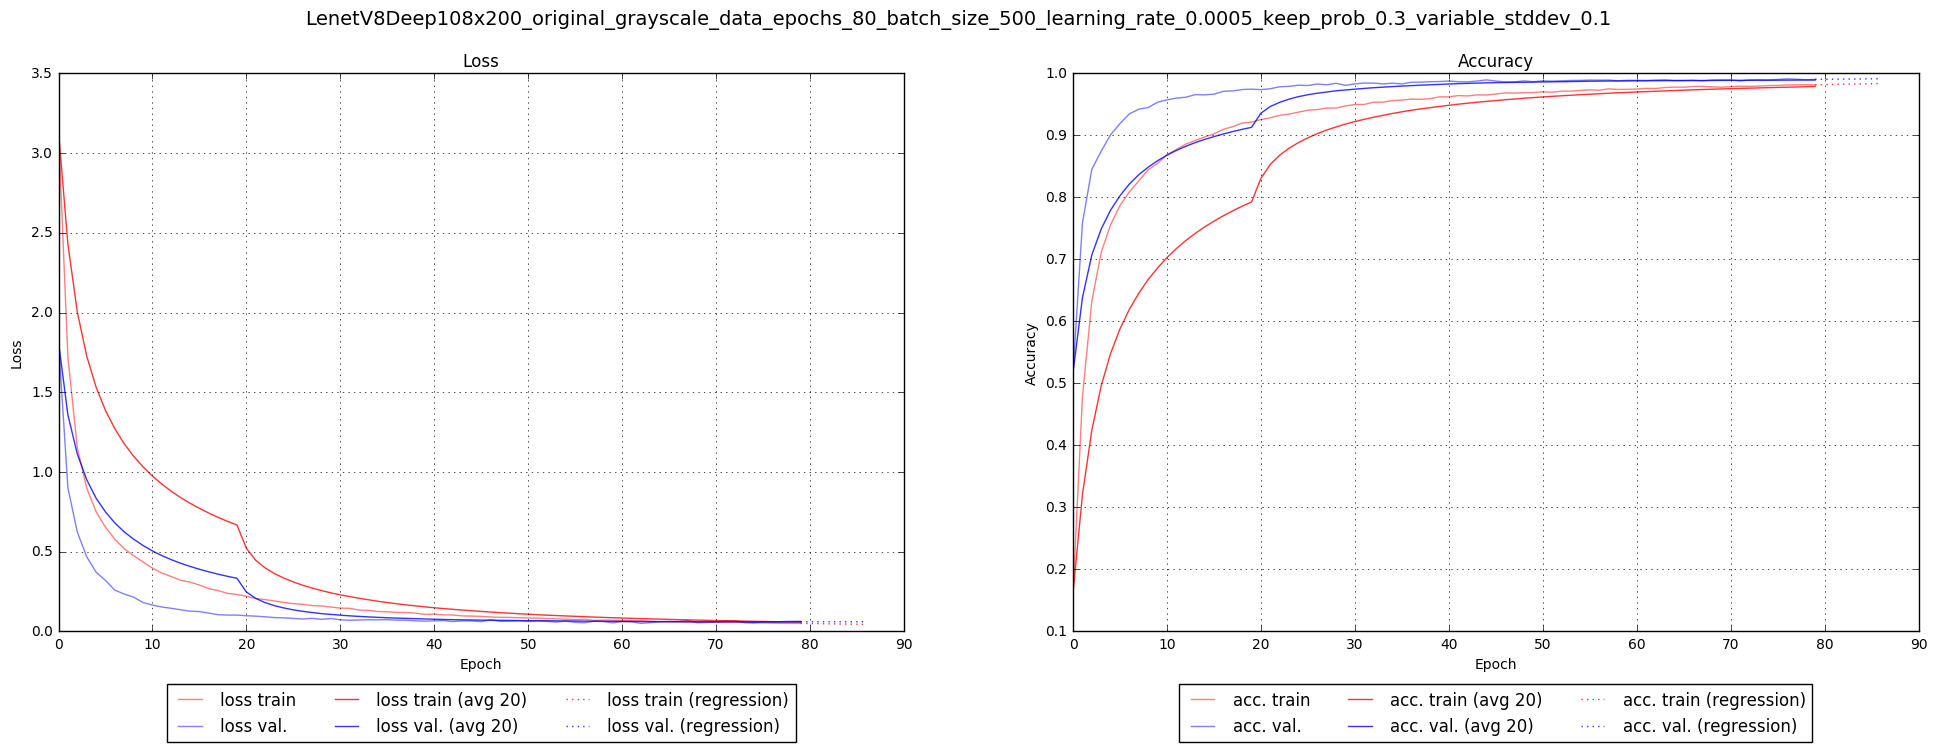

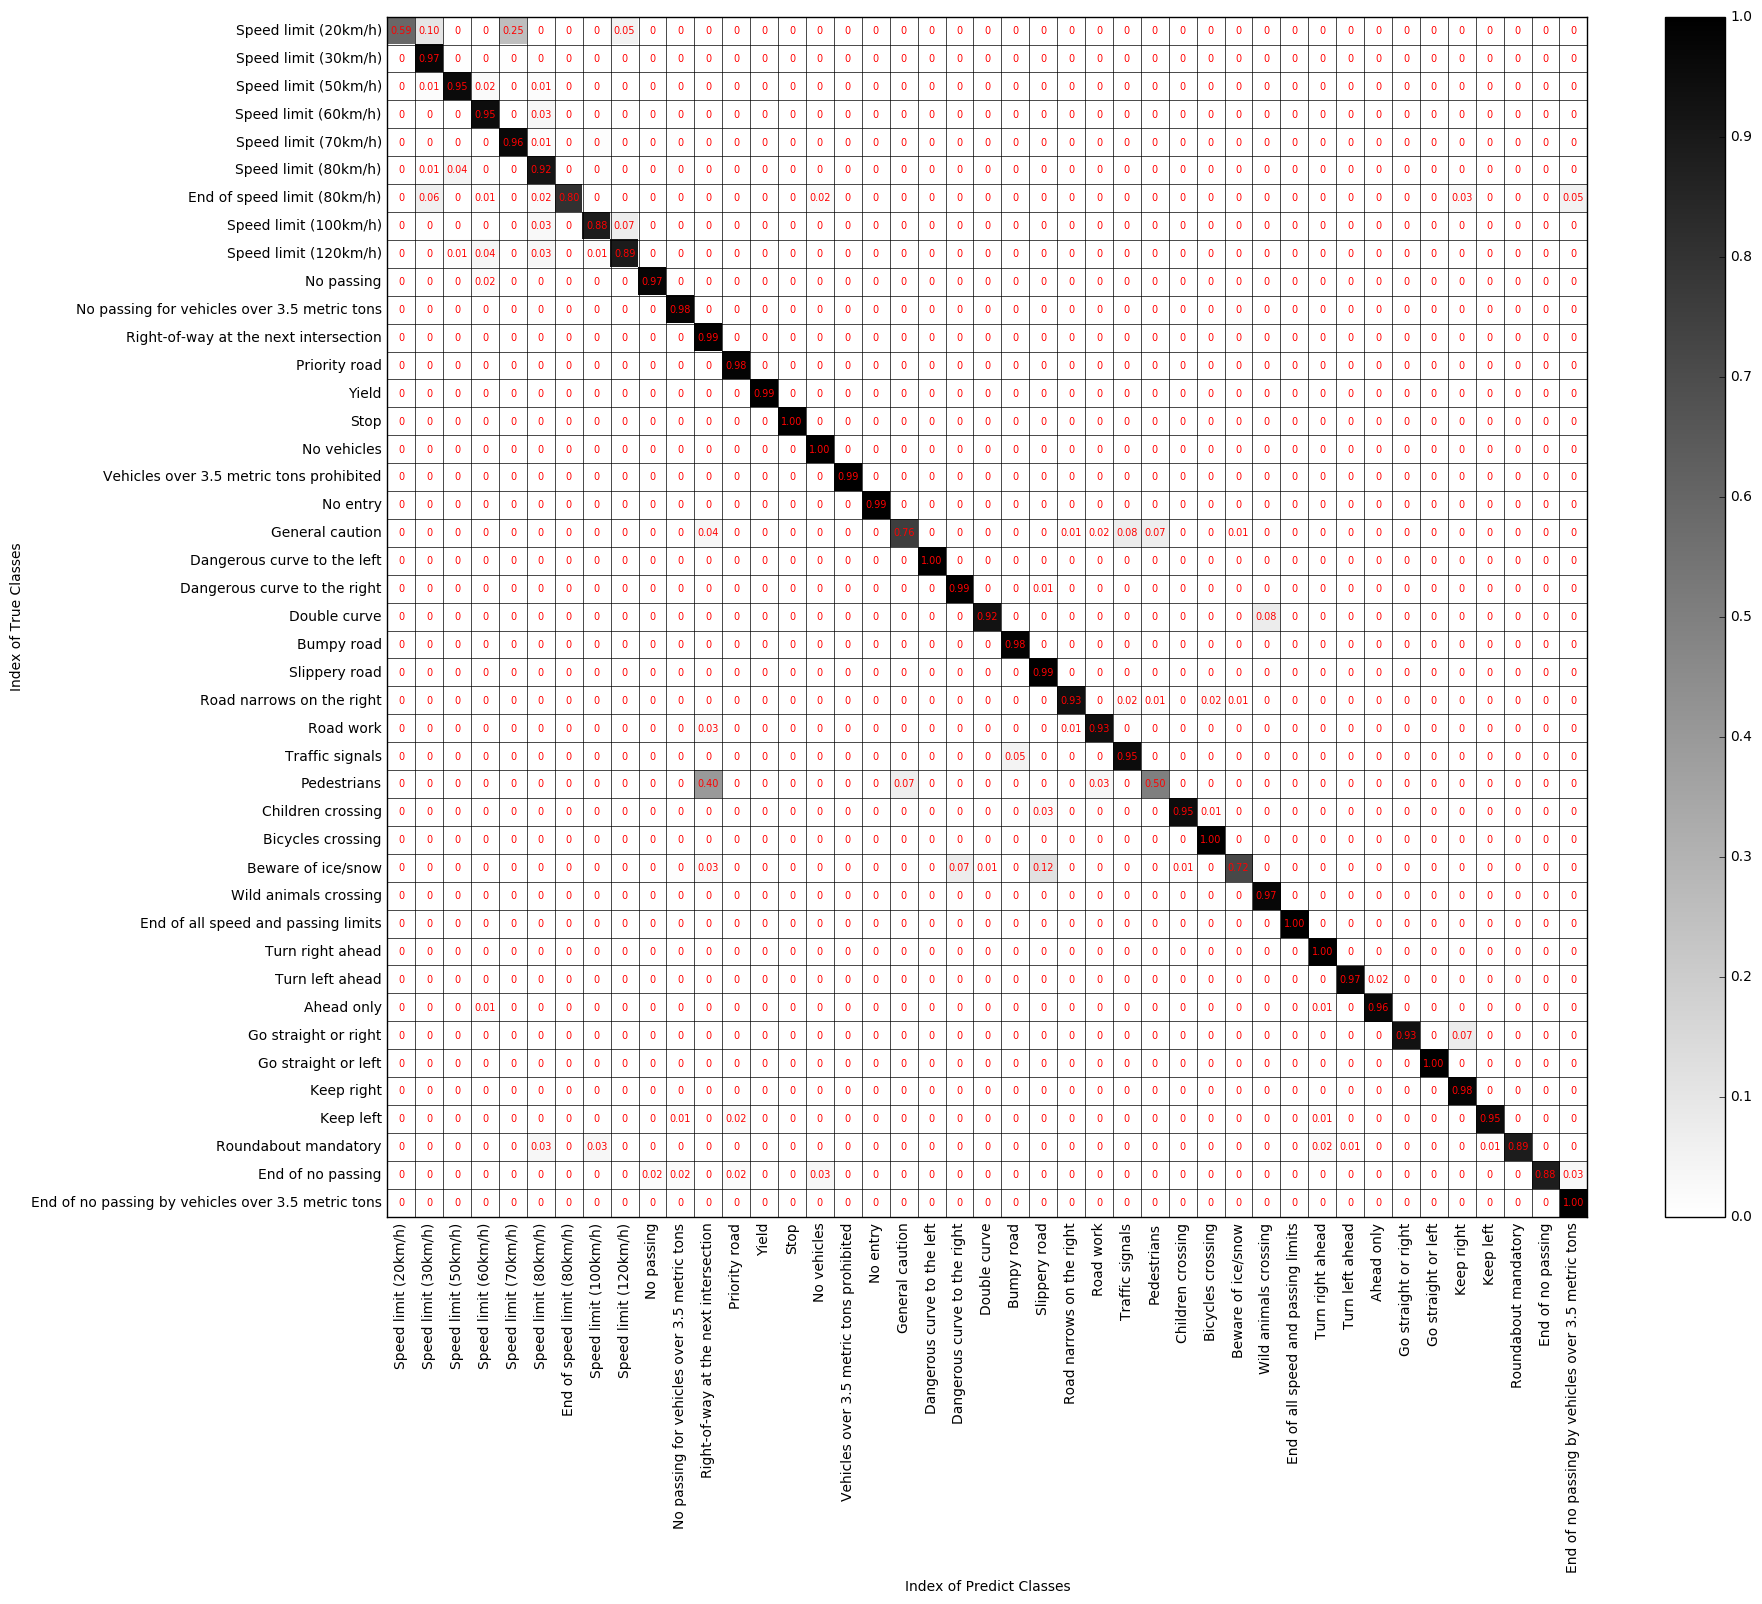

In [6]:
def test_lenet_108x200_augment_data():
    """
    0.952, 20% validation, 3 rotate
    0.943, 40% validation, 3 zoomin
    0.949, 40% validation, 3 zoomin or rotate
    """
#     provider = TrafficDataRealFileProviderAutoSplitValidationData(split_validation_from_train=True, validation_size=0.20)
    provider = rotated_data_provider
#     images, labels = enhance_with_random_rotate(provider.X_train, provider.y_train, 2)
#     images, labels = enhance_with_random_zoomin(provider.X_train, provider.y_train, 4)
#     images, labels = enhance_with_brightness_contrast(provider.X_train, provider.y_train, 4)
#     images, labels = enhance_with_random_zoomin_and_rotate(provider.X_train, provider.y_train, 3)
#     provider = provider.to_other_provider(X_train_overwrite=images, y_train_overwrite=labels)
#     provider = grayscale(provider)
    provider = normalise_image_whitening(provider)
    lenet = LenetV8Deep108x200(TrafficDataSets(provider),
                  name="original_grayscale_data",
                  epochs=80, batch_size=500, variable_mean=0, variable_stddev=0.1,
                  learning_rate=0.0005, 
                  drop_out_keep_prob=0.3)
    lenet.train()
    Image(filename=lenet.file_name) 
    Image(filename=lenet.file_name_confusion_matrix) 
    Image(filename=lenet.file_name_wrong_predicts) 
    
test_lenet_108x200_augment_data()

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [ ]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [ ]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.